In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
import sklearn
import scipy
import statsmodels
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests
import matplotlib.cm as cm
import etcpy
import evo_etc
from functools import reduce
import multiprocessing
from copy import deepcopy

In [2]:
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
dfchemo = pd.read_csv('../data/Chemostat_exp_data.txt',sep='\t',index_col=0)

In [3]:
# Convenient pickle wrappers
def load_pickle(filename):
    return pickle.load(open(file=filename,mode='rb'))


def load_pickle_model(filename):
        # This function loads simulated results, but deletes the particles in order to save memory
        model = load_pickle(filename)
        del model.all_particles
        return model
        

def dump_pickle(obj,filename):
    return pickle.dump(obj=obj,file=open(file=filename, mode='wb'))

### Load data

In [4]:
model_skeleton = load_pickle("../results/permuted_smcabc_res/simulation_skeleton.pkl")

In [5]:
model_skeleton["model"] = list(map(load_pickle_model,model_skeleton.outfile))

In [6]:
model_frame = model_skeleton.set_index(["origin","status"])

In [7]:
reference_model = model_frame.loc[("unpermuted","original"),"model"]

In [8]:
models = model_frame.model

In [9]:
!pwd

/home/jakobpp/BayesianGEM/code


### Visualize particle population

In [10]:
model_frame["particle_df"] = load_pickle("../results/permuted_smcabc_res/particle_df.pkl")

In [11]:
unique_origins = model_frame.index.get_level_values("origin").unique()

In [12]:
combined_df = load_pickle("../results/permuted_smcabc_res/combined_particle_df.pkl")

In [13]:
pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_full_ordination.pkl")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(63139,)
(61724,)
(62675,)
(62990,)
(63474,)
(62980,)
(62952,)
(63087,)


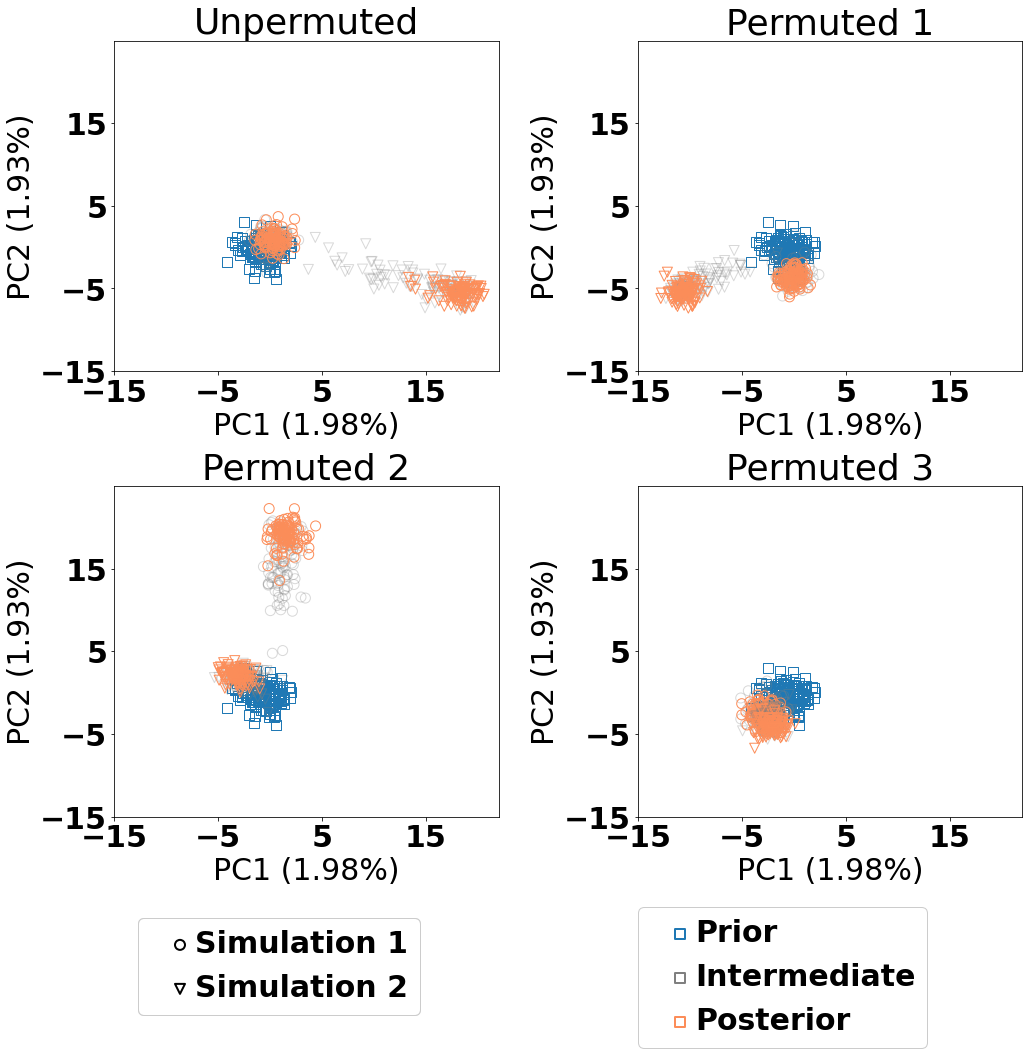

In [14]:
thinning_rng = np.random.default_rng(3052)
i=1
plt.figure(figsize=(15,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df["period"].to_numpy()
prior = combined_df["origin"].to_numpy()
model = combined_df["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
PCS, EV = pca_ordination
for origin in proper_names.keys():
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-15,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-15,22))
    plt.ylim((-15,25))
    plt.title(proper_names[origin])
    plt.tight_layout()
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
legend_period = plt.legend(handles_period, all_periods, loc=(0,-.7), framealpha=1, handletextpad=-.5)
legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc=(-1.3,-.6), framealpha=1,handletextpad=-.5)
plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_status)
plt.gcf().subplots_adjust(bottom=.22)
plt.savefig("../figures/pca.png",dpi=300)
plt.show()

## $R^2$ convergence plots

In [15]:
def r2_on_data(Yobs, simulated_data_one):
    r2_diff_dbs = [r2_score(Yobs[db],simulated_data_one[db]) for db in Yobs]
    return np.mean(r2_diff_dbs)

In [16]:
Yobs_batch = GEMS.aerobic_exp_data()
Yobs_chemo = GEMS.chemostat_exp_data()
#Yobs_batch_an = GEMS.anaerobic_exp_data()
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
Yobs_batch_an = {'data':dfan_batch.loc[sel_temp,'r_an'].values}

Yobs = {'rae':Yobs_batch['data'],
        'chemostat':Yobs_chemo['data'],
        'ran':Yobs_batch_an['data']}

In [17]:
def plot_convergence_inner(model, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    # r2s_history = np.array([r2_on_data(Yobs, item) if item is not None else 0 for
    #                         item in model.all_simulated_data[:offset*maxiter]])
    r2s_history = -np.array(model.all_distances[:offset*maxiter])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(model.all_simulated_data):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

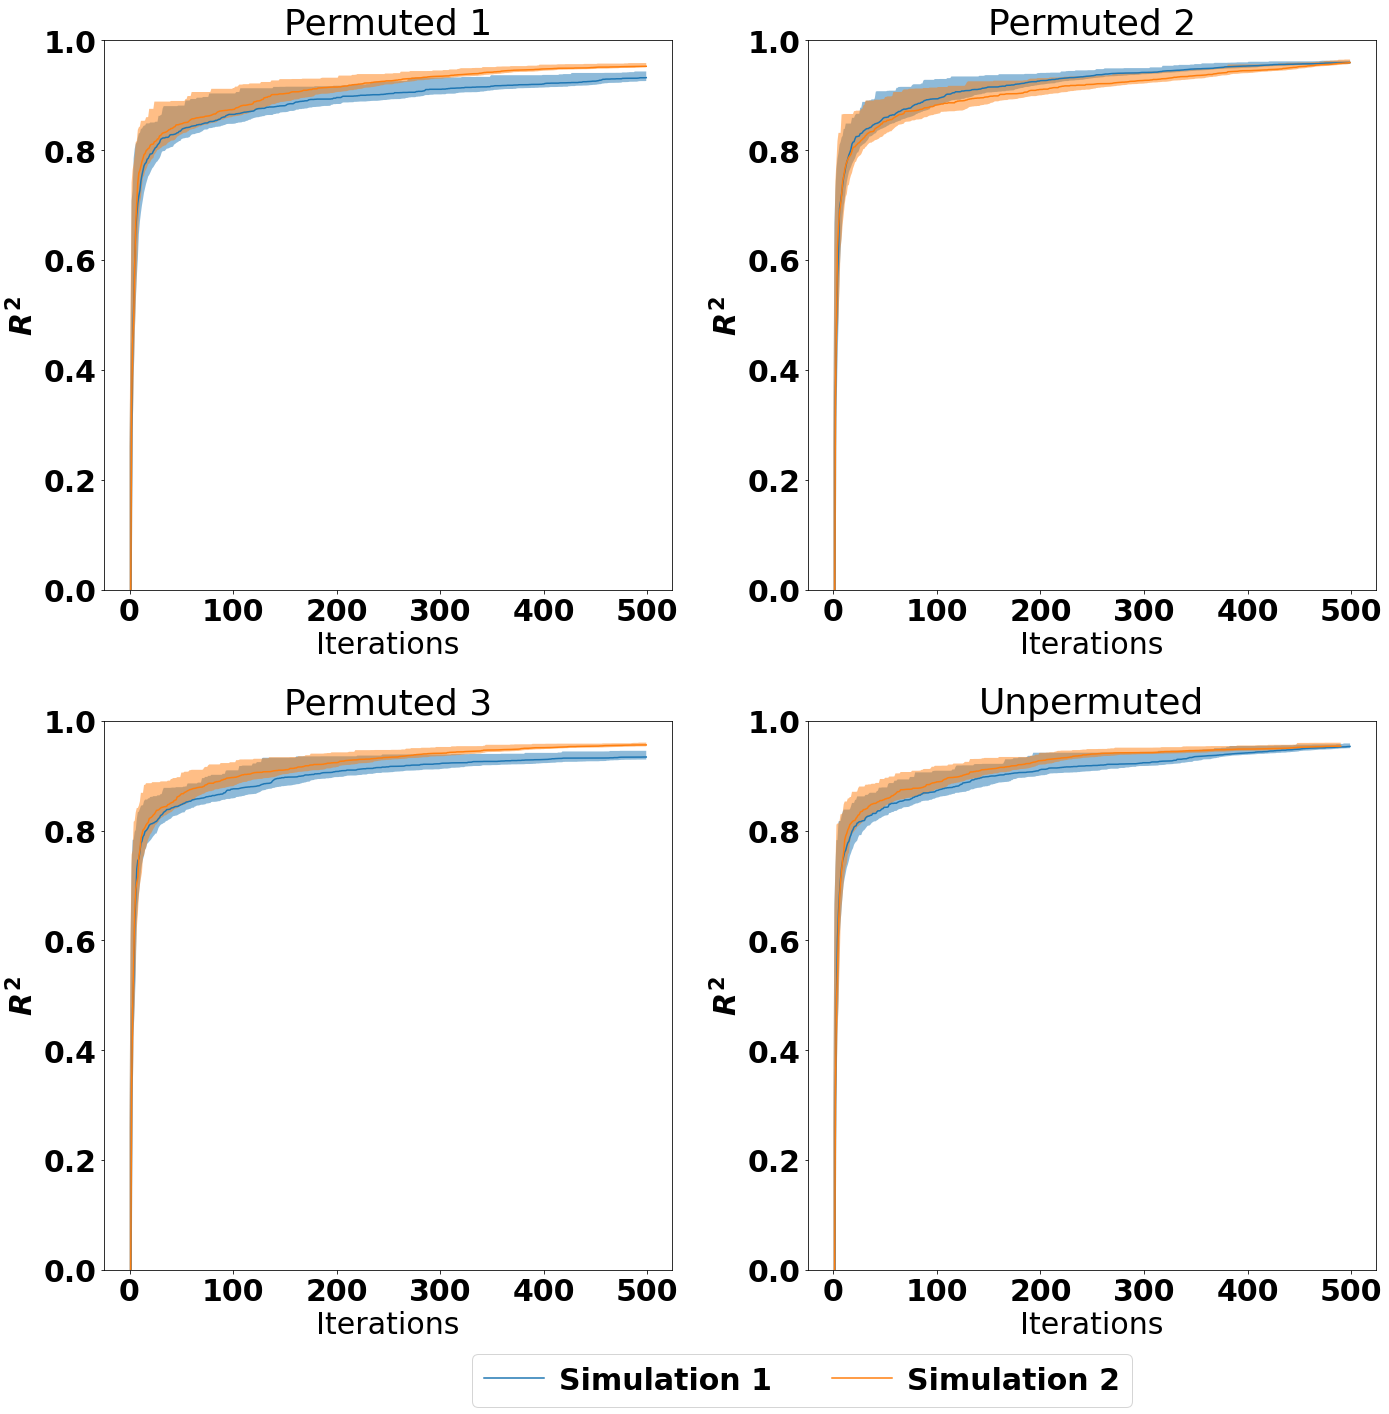

In [18]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
maxiter = 500
i = 1
plt.figure(figsize=(20,20))
for index, series in model_frame["model"].groupby("origin"):
    plt.subplot(2,2,i)
    models = series[index]
    original_model = models["original"]
    replicate_model = models["replicate"]
    plot_convergence_inner(original_model,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_model,maxiter, label = 'Simulation 2')
    if i==4:
        handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title(proper_names[index])
    i += 1
    plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.gcf().legend(handles,labels, loc=(.34,0.005),ncol=2,handletextpad=0.5)
plt.savefig("../figures/R2.pdf")
plt.show()

## Create integrated plot for Unpermuted and Permuted 1

In [19]:
reduced_pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_reduced_ordination.pkl")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(63139,)
(61724,)
(62675,)
(62990,)


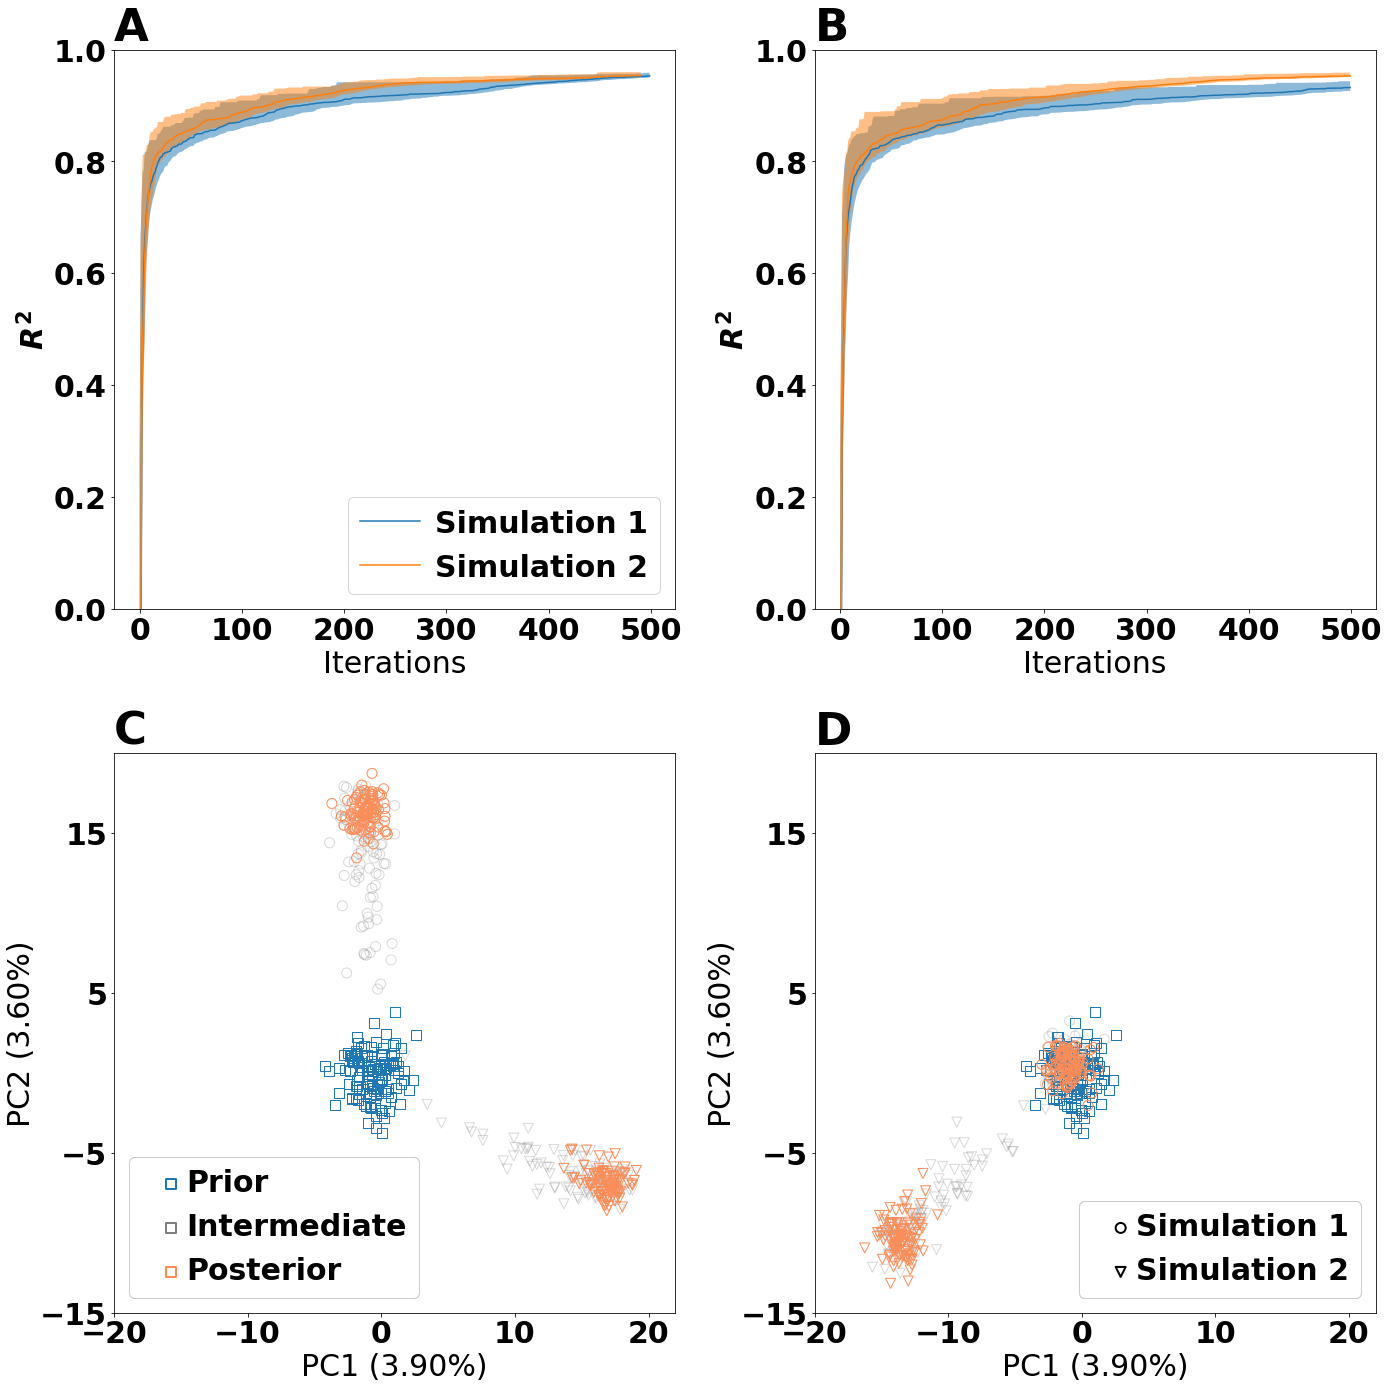

In [20]:
thinning_rng = np.random.default_rng(8049)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df["period"].to_numpy()
prior = combined_df["origin"].to_numpy()
model = combined_df["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
plt.figure(figsize=(20,20))
i=2
for index, series in model_frame.query("origin in ('unpermuted','permuted_0')")["model"].groupby("origin"):
    plt.subplot(2,2,i)
    models = series[index]
    original_model = models["original"]
    replicate_model = models["replicate"]
    plot_convergence_inner(original_model,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_model,maxiter, label = 'Simulation 2')
    if i==1:
        plt.legend(loc="lower right",handletextpad=0.5)
        # handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title("A" if index=="unpermuted" else "B",loc="left",fontsize=45,fontweight="bold")
    i -= 1
    plt.tight_layout()
    
PCS, EV = reduced_pca_ordination
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
i=3
for origin in ["unpermuted","permuted_0"]:
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-20,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-20,22))
    plt.ylim((-15,20))
    plt.title("C" if origin=="unpermuted" else "D",loc="left",fontsize=45,fontweight="bold")
    if origin == "unpermuted":
        legend_period = plt.legend(handles_period, all_periods, loc="lower left", framealpha=1, handletextpad=-.5)
        plt.gca().add_artist(legend_period)
    else:
        legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc="lower right", framealpha=1,handletextpad=-.5)
        plt.gca().add_artist(legend_status)
    plt.tight_layout()

plt.savefig("../figures/bayesian_fig.png",dpi=300)
plt.show()

# Results of evolutionary algorithm

In [21]:
evolution_model = load_pickle_model('../results/smcevo_gem_three_conditions_save_all_particles_refined.pkl')

In [22]:
def plot_convergence_and_compare_evolution(model, reference_model, maxiter=100, legend = True):
    plot_convergence_inner(model, generation_size=100, maxiter=maxiter, label = 'Evolutionary')
    plot_convergence_inner(reference_model, maxiter=maxiter, label = 'Bayesian')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend(loc="lower right",handletextpad=0.5)
    plt.tight_layout()

In [23]:
evolution_combined_df = load_pickle("../results/evo_combined_particle_df.pkl")

In [24]:
PCS_evo,EV_evo = load_pickle("../results/evo_pca_full_ordination.pkl")

In [25]:
model = evolution_combined_df.values[:,-1]
period = evolution_combined_df.values[:,-2]
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}

In [26]:
markers = ["o","v"]
marker_dict = {'Bayesian': "o", 'Evolutionary': 'v'}
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)

def create_evo_pca_plot(legend = True):
    for label in ["Bayesian","Evolutionary"]:
        label_idxs = np.nonzero(model == label)[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(this_idxs["Intermediate"])
        print(label_idxs.shape)
            # plt.scatter(PCS[:,0],PCS_evo[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        # It does really only make sense display priors for the Bayesian approach as the evolutionary algorithm generates
        # seed individuals by another method and it thus is most fair to show the Bayesian priors for both of them
        if label == "Bayesian":
            plt.scatter(PCS_evo[this_idxs['Prior'],0],PCS_evo[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none', s=100)
        plt.scatter(PCS_evo[this_idxs["Intermediate"],0],PCS_evo[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.5,label='Intermediate',marker=marker, facecolors='none',s=100)
        plt.scatter(PCS_evo[this_idxs['Posterior'],0],PCS_evo[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    plt.xlabel('PC1 ({:.2f}%)'.format(EV_evo[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV_evo[1]*100))
    # plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
    plt.xticks(np.arange(-10,50,10))
    plt.tight_layout()
    colors = ['#1f78b4', 'grey', '#fc8d59']
    labels_period = ["Prior", "Intermediate", 'Posterior']
    labels_status = ['Bayesian', "Evolutionary"]
    if legend:
        f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
        handles_period = [f("s", color) for color in colors]
        handles_model = [f(marker, "k") for marker in markers]
        legend_period = plt.legend(handles_period, labels_period, loc=(.5,.1), framealpha=1)
        legend_model = plt.legend(handles_model, labels_status, loc=(.1,.1), framealpha=1)
        plt.gca().add_artist(legend_period)
        plt.gca().add_artist(legend_model)

[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)


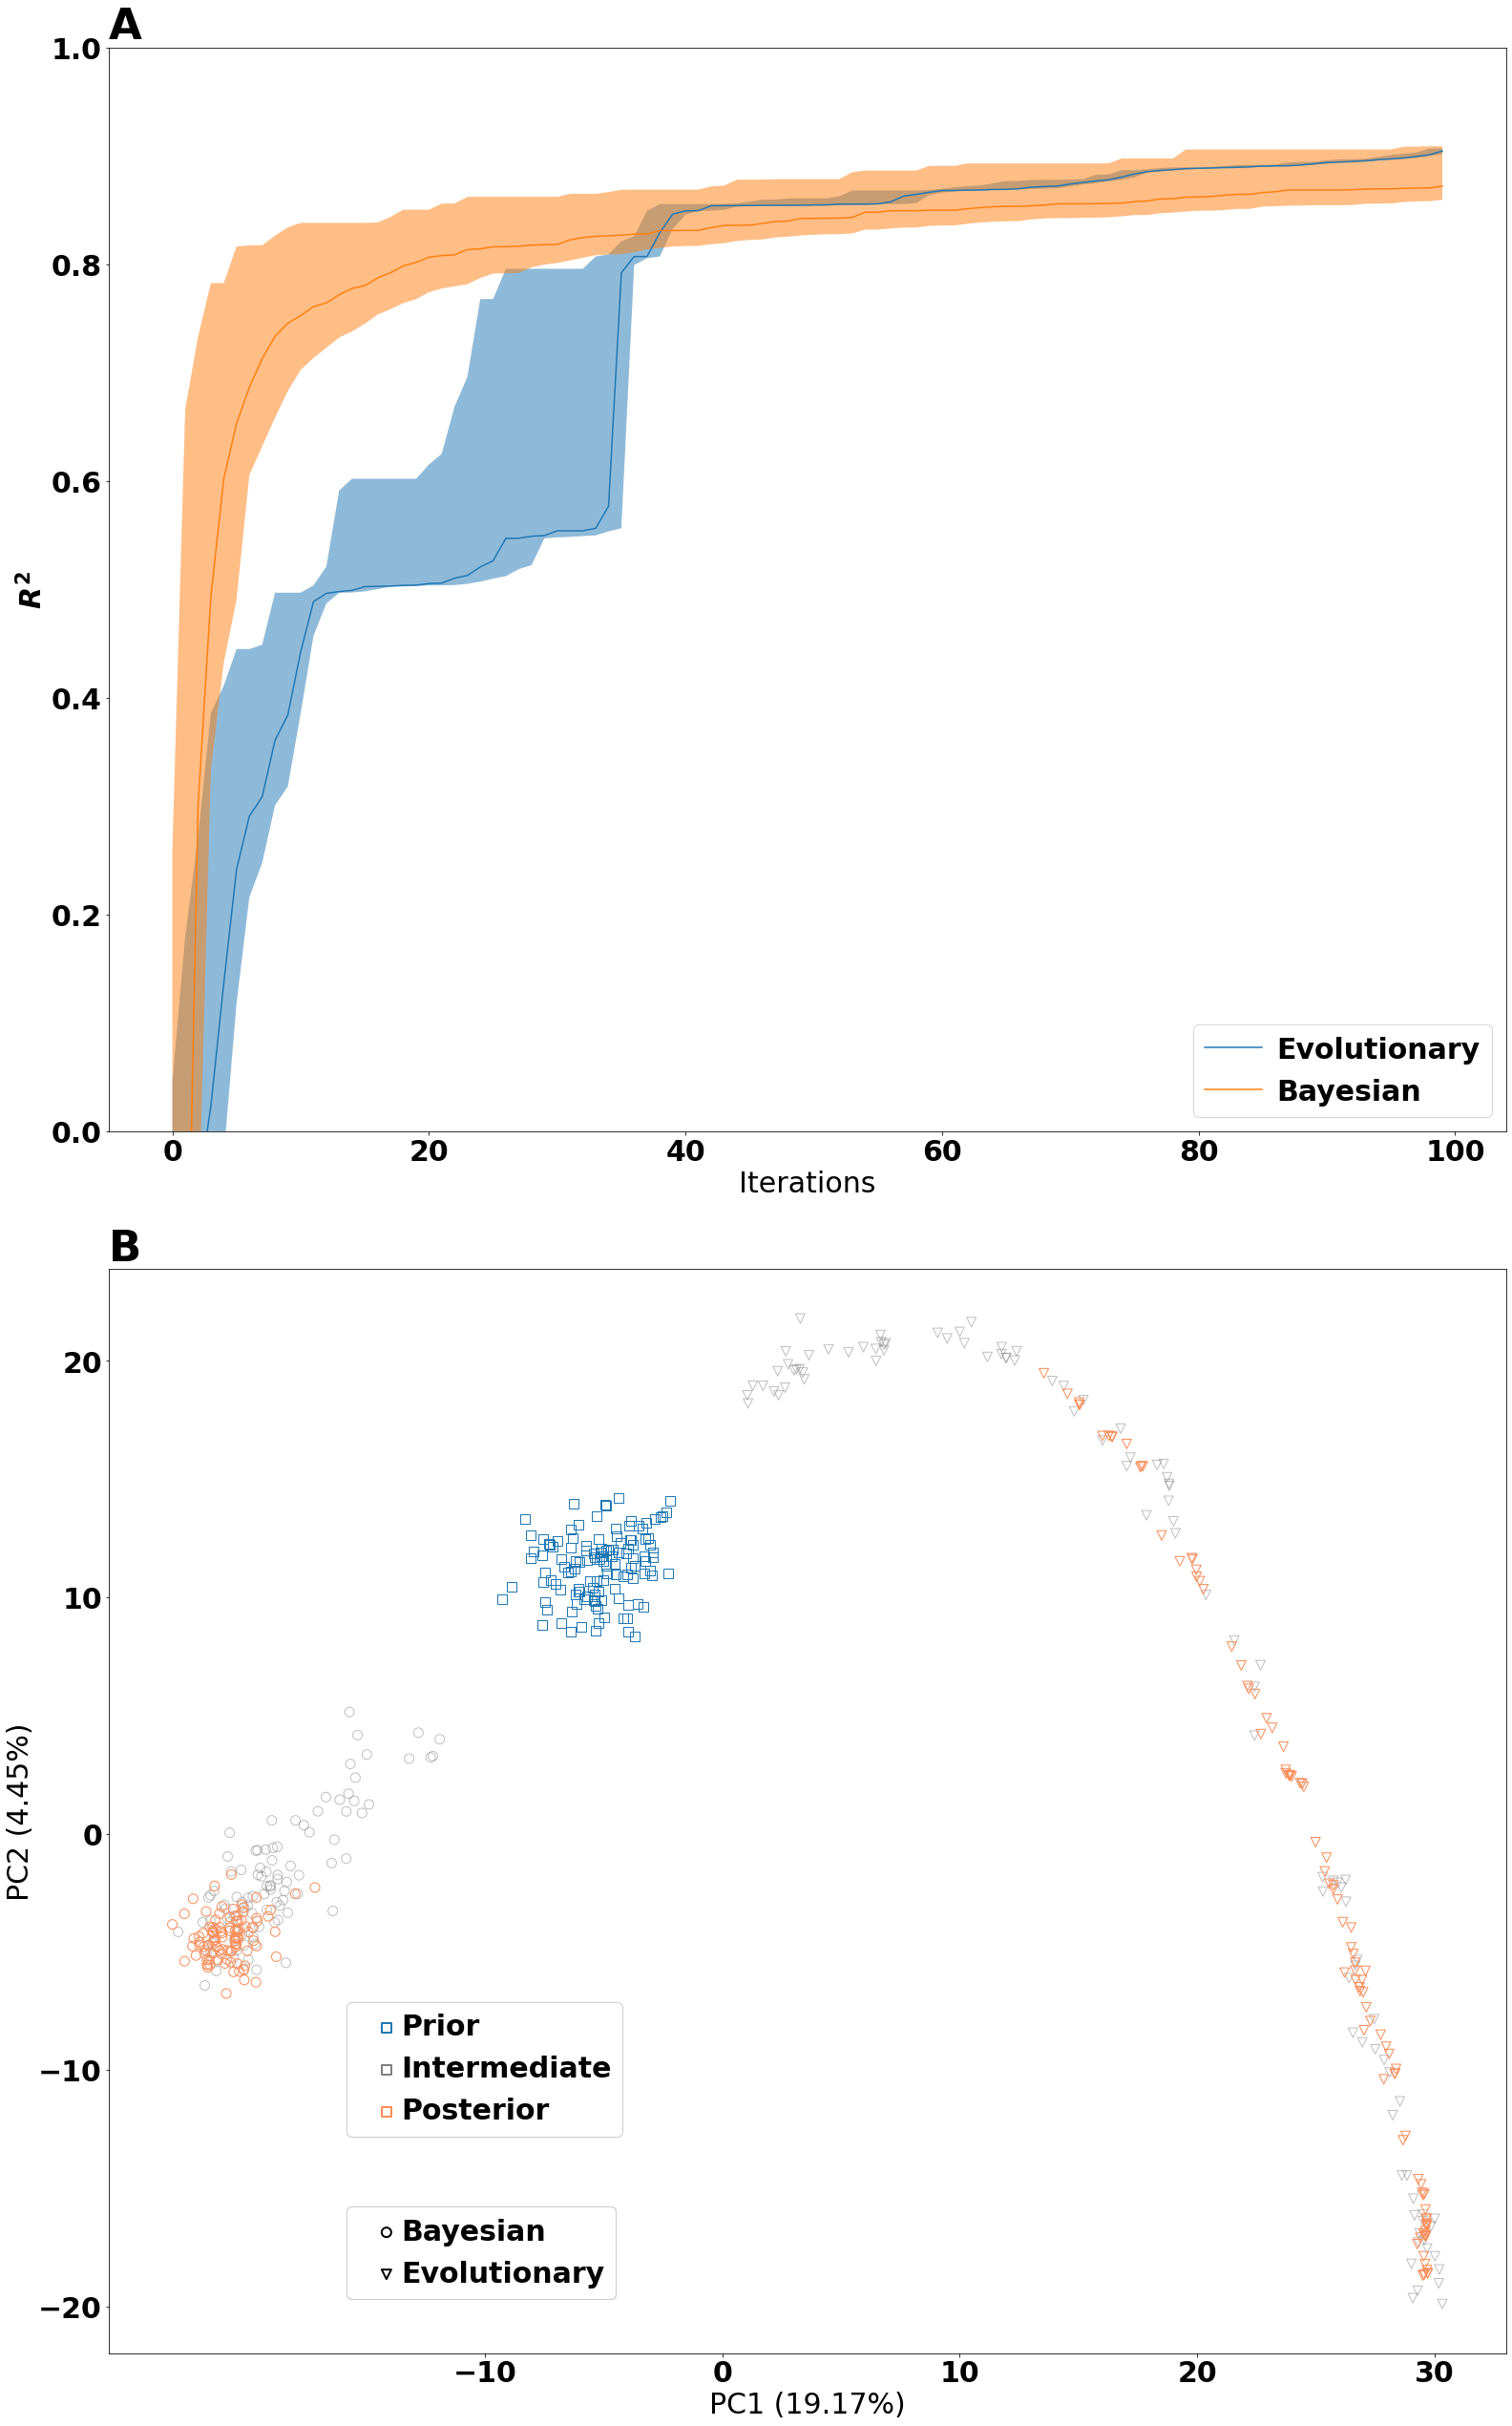

In [27]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
labels_period = ["Prior", "Intermediate", 'Posterior']
labels_status = ['Bayesian', "Evolutionary"]
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)
plt.figure(figsize=(18+5,2*18))
plt.subplot(2,1,1)
plt.title("A",loc="left",fontsize=45,fontweight="bold")
plot_convergence_and_compare_evolution(evolution_model, reference_model, maxiter = 100)
plt.subplot(2,1,2)
plt.title("B",loc="left",fontsize=45,fontweight="bold")
create_evo_pca_plot(legend = False)
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in markers]
legend_period = plt.legend(handles_period, labels_period, loc=(.17,.20), framealpha=1, handletextpad=-0.5)
legend_model = plt.legend(handles_model, labels_status, loc=(.17,.05), framealpha=1,handletextpad=-0.5)
plt.gca().add_artist(legend_period)
plt.gca().add_artist(legend_model)
plt.savefig("../figures/evo_fig.png",dpi=600,bbox_inches = 'tight')


In [28]:
np.median(-np.sort(reference_model.all_distances)[0:99])

0.9531292853589542

In [29]:
np.median(-np.sort(evolution_model.all_distances)[0:99])

0.9511213513744128

In [30]:
tsne_frame = load_pickle("../results/evo_tsne_res/tsne_skeleton.pkl")

In [32]:
tsne_frame["ordination"] = list(map(load_pickle, tsne_frame["outfile"]))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135

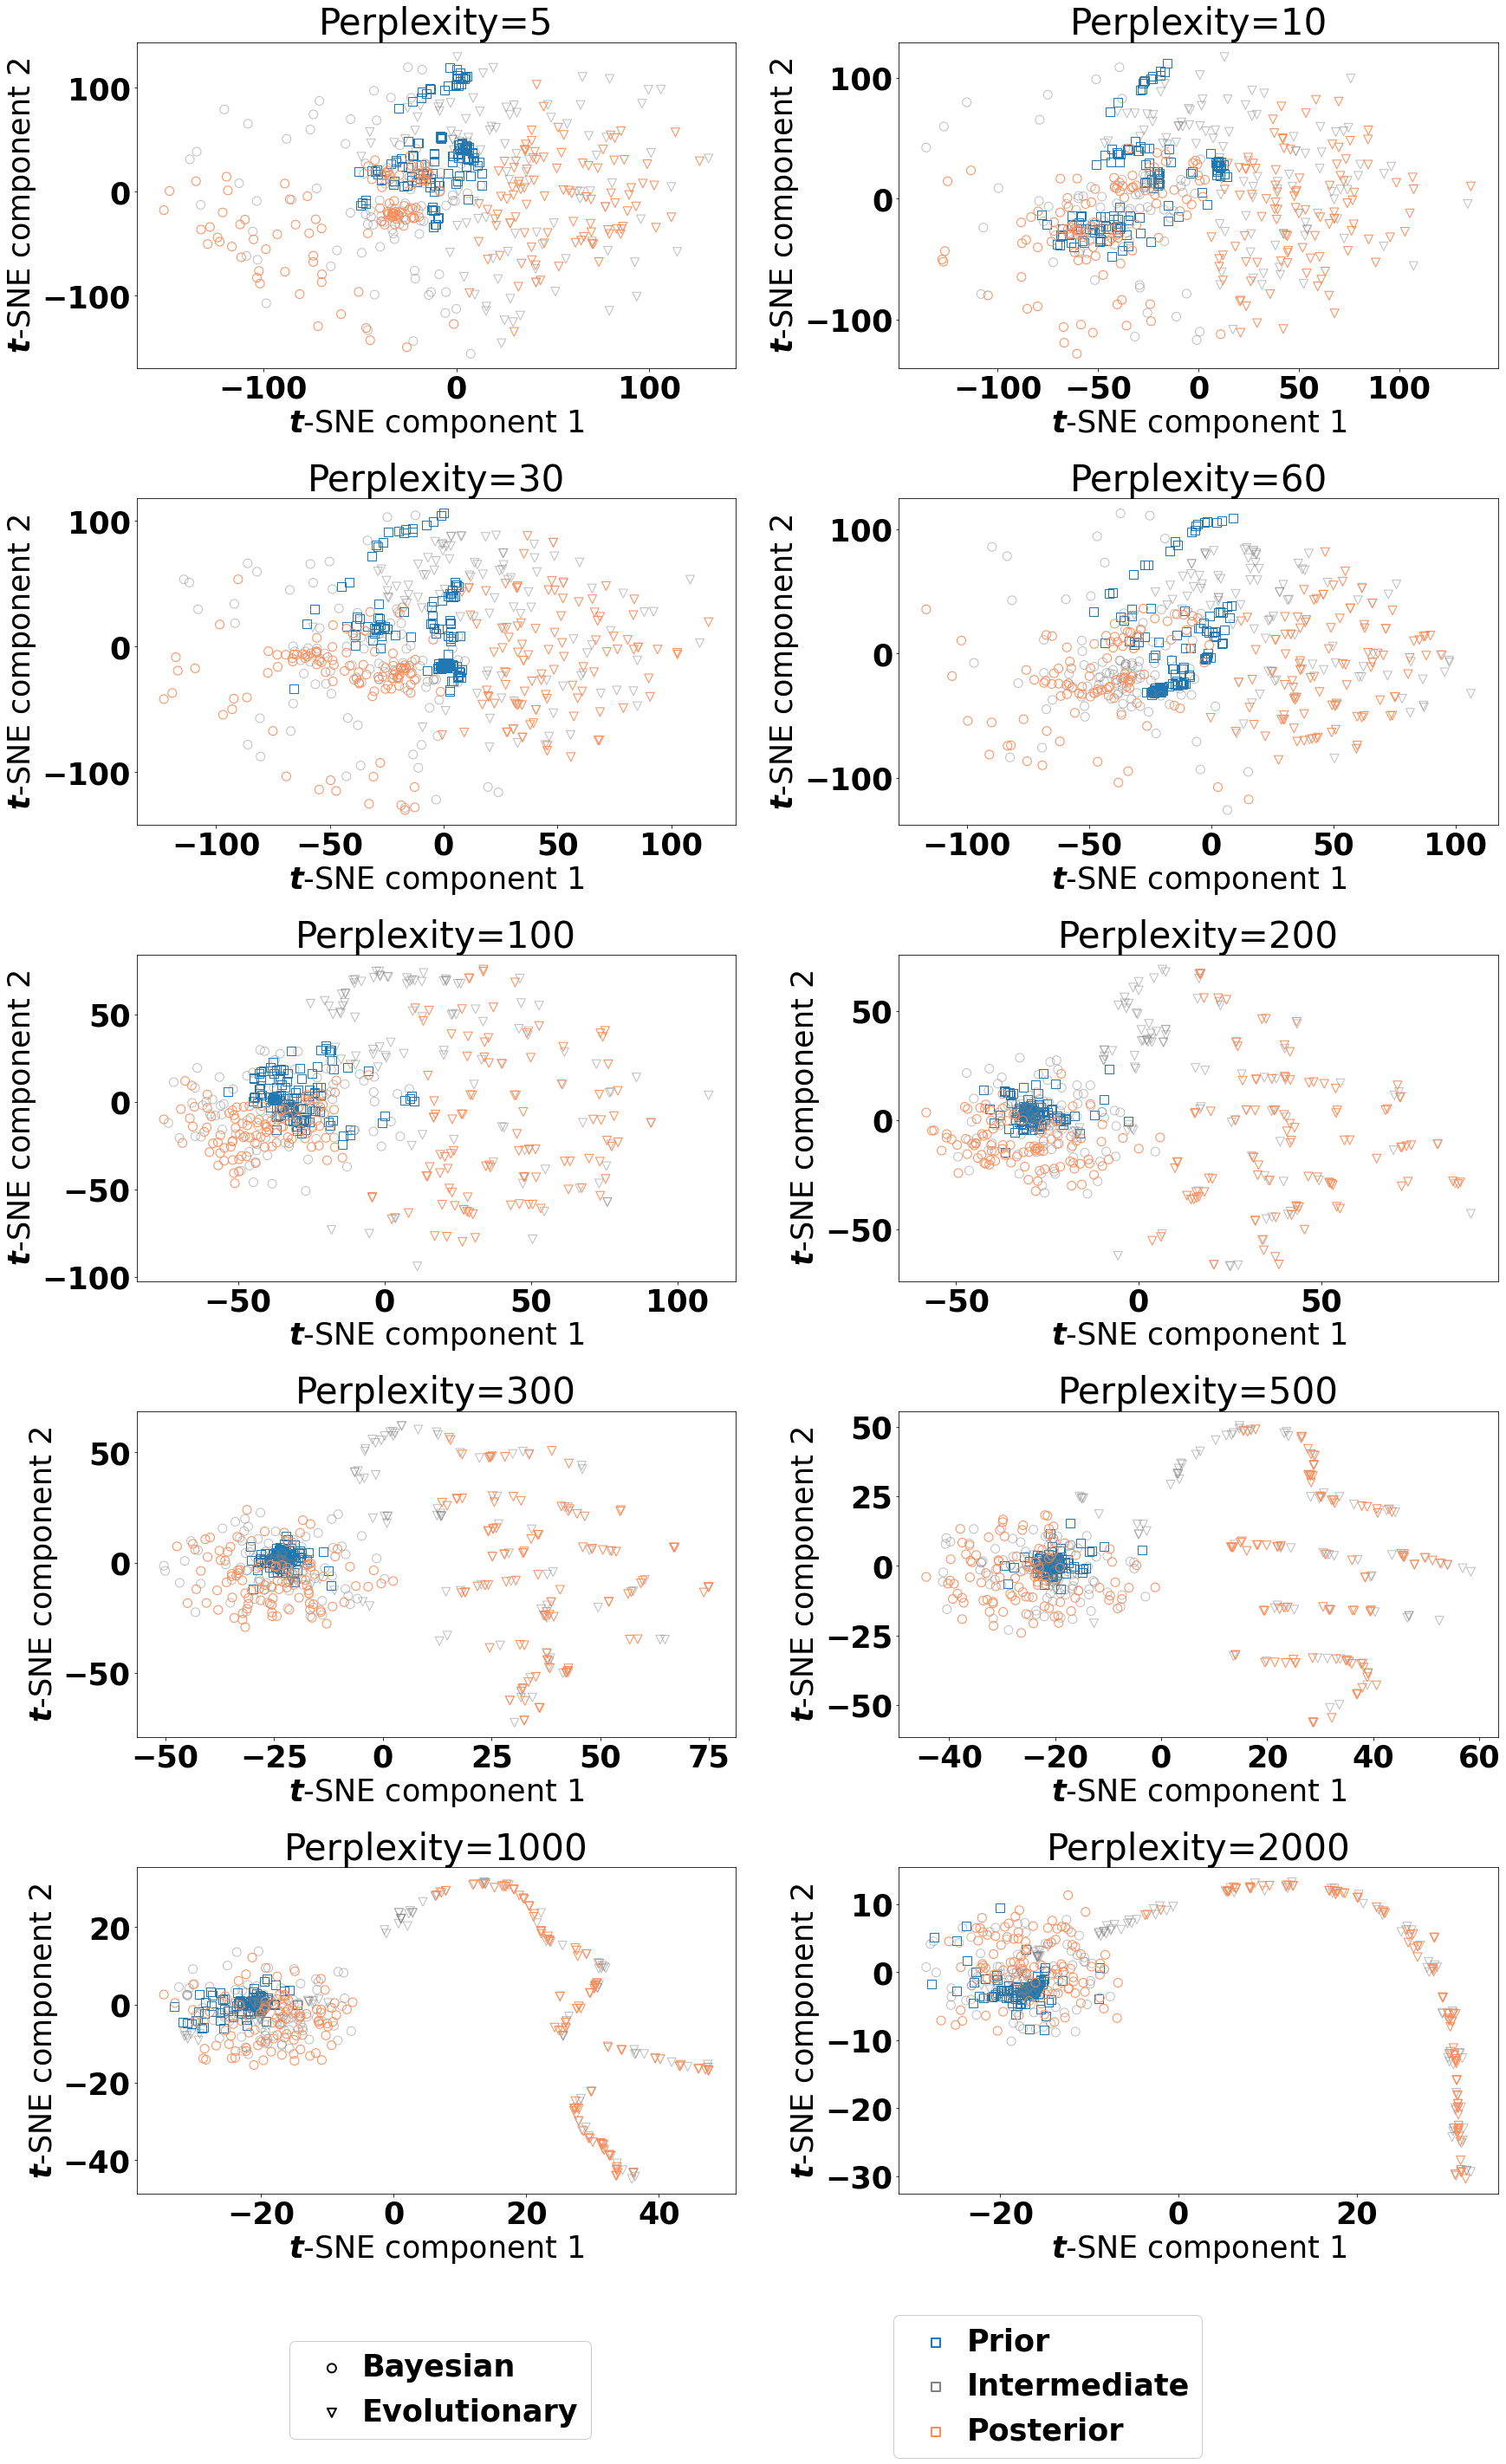

In [34]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 35}
labels_period = ["Prior", "Intermediate", 'Posterior']
labels_status = ['Bayesian', "Evolutionary"]
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)
plt.figure(figsize=(25,40))
model = evolution_combined_df.values[:,-1]
period = evolution_combined_df.values[:,-2]
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
markers = ["o","v"]
marker_dict = {'Bayesian': "o", 'Evolutionary': 'v'}
matplotlib.rc('font', **font)
tsne_thinning_rng = np.random.default_rng(5024)
def create_evo_tsne_plot(tsne_res,legend = True, perplexity = None):
    for label in ["Bayesian","Evolutionary"]:
        label_idxs = np.nonzero(model == label)[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(this_idxs["Intermediate"])
        print(label_idxs.shape)
            # plt.scatter(PCS[:,0],PCS_evo[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])

        this_idxs["Intermediate"] = tsne_thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = tsne_thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        # It does really only make sense display priors for the Bayesian approach as the evolutionary algorithm generates
        # seed individuals by another method and it thus is most fair to show the Bayesian priors for both of them
        if label == "Bayesian":
            plt.scatter(tsne_res[this_idxs['Prior'],0],tsne_res[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                    marker="s",facecolors='none', s=100)
        plt.scatter(tsne_res[this_idxs["Intermediate"],0],tsne_res[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.5,label='Intermediate',marker=marker, facecolors='none',s=100)
        plt.scatter(tsne_res[this_idxs['Posterior'],0],tsne_res[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    plt.xlabel(r'$t$-SNE component 1')
    plt.ylabel(r'$t$-SNE component 2')
    # plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)    
    if perplexity is not None:
        plt.title(f"Perplexity={perplexity}")
    plt.tight_layout()
    colors = ['#1f78b4', 'grey', '#fc8d59']
    labels_period = ["Prior", "Intermediate", 'Posterior']
    labels_status = ['Bayesian', "Evolutionary"]
    if legend:
        f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
        handles_period = [f("s", color) for color in colors]
        handles_model = [f(marker, "k") for marker in markers]
        legend_period = plt.legend(handles_period, labels_period, loc=(.5,-0.35), framealpha=1, handletextpad=0)
        legend_model = plt.legend(handles_model, labels_status, loc=(.1,-0.3), framealpha=1, handletextpad=0)
        plt.gca().add_artist(legend_period)
        plt.gca().add_artist(legend_model)
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in markers]
legend_period = plt.legend(handles_period, labels_period, loc=(.6,-0.16), framealpha=1, handletextpad=0)
legend_model = plt.legend(handles_model, labels_status, loc=(.1,-0.15), framealpha=1, handletextpad=0)

for i, (perplexity,_, ordination) in tsne_frame.iterrows():
    plt.subplot(5,2,i+1)
    create_evo_tsne_plot(ordination,False, perplexity=perplexity)

plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_model)
plt.gcf().subplots_adjust(bottom=.11)
plt.savefig("../figures/evo_tsne.png",dpi=300)
plt.show()

# Effects on pathway level

In [35]:
fva_results = load_pickle("../results/permuted_smcabc_res/fva_at_three_conditions.pkl")

In [36]:
fva_results

origin     status                                           particle  \
0    unpermuted   original  {'O13525_Tm': 331.6638596175288, 'O13525_Topt'...   
1    unpermuted   original  {'O13525_Tm': 320.8117136606959, 'O13525_Topt'...   
2    unpermuted   original  {'O13525_Tm': 325.1114607019797, 'O13525_Topt'...   
3    unpermuted   original  {'O13525_Tm': 328.06580038410783, 'O13525_Topt...   
4    unpermuted   original  {'O13525_Tm': 332.6392528598742, 'O13525_Topt'...   
..          ...        ...                                                ...   
155  permuted_2  replicate  {'O13525_Tm': 330.1971646826934, 'O13525_Topt'...   
156  permuted_2  replicate  {'O13525_Tm': 325.3997674288382, 'O13525_Topt'...   
157  permuted_2  replicate  {'O13525_Tm': 328.0381286580098, 'O13525_Topt'...   
158  permuted_2  replicate  {'O13525_Tm': 335.41589645137054, 'O13525_Topt...   
159  permuted_2  replicate  {'O13525_Tm': 333.0197128453676, 'O13525_Topt'...   

                                               fva_res  
0                    reaction       T   minimum   m...  
1                    reaction       T   minimum   m...  
2                    reaction       T   minimum   m...  
3                    reaction       T   minimum   m...  
4                    reaction       T   minimum   m...  
..                                                 ...  
155                  reaction       T   minimum   m...  
156                  reaction       T   minimum   m...  
157                  reaction       T   minimum   m...  
158                  reaction       T   minimum   m...  
159                  reaction       T   minimum   m...  

[160 rows x 4 columns]

In [37]:
evo_fva_results = load_pickle("../results/evo_fva.pkl")

In [38]:
evo_fva_results

particle  \
0   {'P22438_Topt': 306.3548647753577, 'P46681_dCp...   
1   {'P22438_Topt': 311.886047351078, 'P46681_dCpt...   
2   {'P22438_Topt': 311.8860470422647, 'P46681_dCp...   
3   {'P22438_Topt': 310.6580307638588, 'P46681_dCp...   
4   {'P22438_Topt': 307.82349846062664, 'P46681_dC...   
5   {'P22438_Topt': 311.8883783972634, 'P46681_dCp...   
6   {'P22438_Topt': 311.886047351078, 'P46681_dCpt...   
7   {'P22438_Topt': 311.886047351078, 'P46681_dCpt...   
8   {'P22438_Topt': 310.6017199631328, 'P46681_dCp...   
9   {'P22438_Topt': 311.8916210136895, 'P46681_dCp...   
10  {'P22438_Topt': 306.3561341838288, 'P46681_dCp...   
11  {'P22438_Topt': 311.8860492228331, 'P46681_dCp...   
12  {'P22438_Topt': 311.8868734879213, 'P46681_dCp...   
13  {'P22438_Topt': 315.118210282361, 'P46681_dCpt...   
14  {'P22438_Topt': 311.8856619156808, 'P46681_dCp...   
15  {'P22438_Topt': 311.89117096105986, 'P46681_dC...   
16  {'P22438_Topt': 306.3548647753577, 'P46681_dCp...   
17  {'P22438_Topt': 311.86774870495253, 'P46681_dC...   
18  {'P22438_Topt': 309.75942050859663, 'P46681_dC...   
19  {'P22438_Topt': 311.886047351078, 'P46681_dCpt...   

                                              fva_res  
0                   reaction       T       minimum...  
1                   reaction       T       minimum...  
2                   reaction       T       minimum...  
3                   reaction       T       minimum...  
4                   reaction       T   minimum   m...  
5                   reaction       T   minimum   m...  
6                   reaction       T       minimum...  
7                   reaction       T       minimum...  
8                   reaction       T       minimum...  
9                   reaction       T       minimum...  
10                  reaction       T       minimum...  
11                  reaction       T       minimum...  
12                  reaction       T       minimum...  
13                  reaction       T   minimum   m...  
14                  reaction       T       minimum...  
15                  reaction       T       minimum...  
16                  reaction       T       minimum...  
17                  reaction       T   minimum   m...  
18                  reaction       T       minimum...  
19                  reaction       T       minimum...

In [39]:
flattened_df_list = []
for _, row in fva_results.drop(columns=["particle"]).iterrows():
    df = row["fva_res"].copy()
    df["origin"] = row["origin"]
    df["status"] = row["status"]
    flattened_df_list.append(df)
for _, row in evo_fva_results.drop(columns=["particle"]).iterrows():
    df = row["fva_res"].copy()
    df["origin"] = "unpermuted"
    df["status"] = "evolutionary"
    flattened_df_list.append(df)

combined_fva_frame = (
    pd.concat(flattened_df_list).
    assign(range= lambda df: df["maximum"] - df["minimum"],
                                                         midpoint= lambda df: (df["maximum"] + df["minimum"]) / 2).
    drop(columns=["minimum", "maximum"])
        )

In [40]:
combined_fva_frame

reaction       T  condition      origin        status  \
0                 r_0006  289.15    aerobic  unpermuted      original   
1                 r_0026  289.15    aerobic  unpermuted      original   
2                 r_0043  289.15    aerobic  unpermuted      original   
3                 r_0044  289.15    aerobic  unpermuted      original   
4                 r_0070  289.15    aerobic  unpermuted      original   
...                  ...     ...        ...         ...           ...   
6738    draw_prot_P00410  311.65  chemostat  unpermuted  evolutionary   
6739    draw_prot_P00420  311.65  chemostat  unpermuted  evolutionary   
6740    draw_prot_P00163  311.65  chemostat  unpermuted  evolutionary   
6741  prot_pool_exchange  311.65  chemostat  unpermuted  evolutionary   
6742                NGAM  311.65  chemostat  unpermuted  evolutionary   

             range      midpoint  
0     9.619831e-06  9.614964e-03  
1     1.588743e-04  7.943714e-05  
2    -0.000000e+00  0.000000e+00  
3    -0.000000e+00  0.000000e+00  
4    -0.000000e+00  0.000000e+00  
...            ...           ...  
6738  9.008745e-08  4.791287e-07  
6739  1.128709e-07  6.003022e-07  
6740  1.710277e-07  8.498872e-07  
6741  9.966820e-05  8.928017e-02  
6742  0.000000e+00  8.001988e+00  

[26702280 rows x 7 columns]

In [41]:
aggregated_fva_res = (
    combined_fva_frame.replace([np.inf, -np.inf],np.nan).
    dropna(how="all").
    groupby(["origin","status","condition","reaction","T"]).
    agg(["mean","std","count"])
                     )

In [42]:
aggregated_fva_res

range                  \
                                                     mean       std count   
origin     status    condition reaction  T                                  
permuted_0 original  aerobic   NGAM      289.15  0.000000  0.000000    20   
                                         295.15  0.000000  0.000000    20   
                                         299.15  0.000000  0.000000    20   
                                         302.15  0.000000  0.000000    20   
                                         307.15  0.000000  0.000000    20   
...                                                   ...       ...   ...   
unpermuted replicate chemostat r_4045No1 309.15  0.021647  0.003030    20   
                                         310.15  0.010512  0.004281    20   
                                         310.65  0.008967  0.002390    20   
                                         311.15  0.009334  0.002370    20   
                                         311.65  0.009487  0.002379    20   

                                                 midpoint                  
                                                     mean       std count  
origin     status    condition reaction  T                                 
permuted_0 original  aerobic   NGAM      289.15  0.740002  0.000000    20  
                                         295.15  0.745046  0.000000    20  
                                         299.15  0.801170  0.000000    20  
                                         302.15  1.180736  0.000000    20  
                                         307.15  6.524213  0.000000    20  
...                                                   ...       ...   ...  
unpermuted replicate chemostat r_4045No1 309.15  0.010823  0.001515    20  
                                         310.15  0.005256  0.002141    20  
                                         310.65  0.004484  0.001195    20  
                                         311.15  0.004667  0.001185    20  
                                         311.65  0.004743  0.001190    20  

[1335114 rows x 6 columns]

In [43]:
aggregated_fva_res[(aggregated_fva_res[("range","std")] > 100000) & (aggregated_fva_res[("range","count")] == 20)]

range  \
                                                             mean   
origin     status    condition reaction      T                      
permuted_0 original  chemostat r_2150No1     303.15  1.873795e+06   
                               r_2169_REVNo1 303.15  2.255863e+06   
                               r_2172_REVNo1 309.15  1.506711e+05   
                               r_2173_REVNo1 303.15  2.255863e+06   
           replicate chemostat r_0023_REVNo1 309.15  1.896863e+05   
                               r_2148No1     303.15  1.616284e+06   
                               r_2149No1     303.15  1.616284e+06   
                               r_2170_REVNo1 303.15  2.446121e+06   
                               r_2173_REVNo1 303.15  2.446121e+06   
                               r_2174_REVNo1 303.15  2.446121e+06   
permuted_1 original  chemostat r_0023No1     303.15  8.110553e+05   
                               r_0060No1     303.15  8.110553e+05   
                               r_0117No1     303.15  1.285784e+06   
                               r_0117_REVNo1 303.15  1.285784e+06   
                               r_2168_REVNo1 303.15  3.087104e+06   
                               r_2173_REVNo1 309.15  8.246328e+05   
           replicate chemostat r_0023No1     309.15  1.090240e+05   
                               r_0060_REVNo1 309.15  1.090240e+05   
                               r_2150No1     303.15  1.837185e+06   
permuted_2 original  chemostat r_0023No1     303.15  7.931300e+05   
                               r_0060_REVNo1 303.15  7.931300e+05   
                               r_2149_REVNo1 303.15  1.893452e+06   
                               r_2168_REVNo1 309.15  3.388701e+05   
           replicate chemostat r_0023_REVNo1 309.15  2.958256e+05   
                               r_2174No1     310.15  5.748980e+04   
unpermuted original  chemostat r_0023_REVNo1 303.15  7.557065e+05   
                                             309.15  9.469317e+04   
                               r_2148No1     303.15  2.086890e+06   
                               r_2149_REVNo1 303.15  2.086890e+06   
                               r_2168_REVNo1 303.15  2.472794e+06   
                               r_2171_REVNo1 309.15  2.385234e+05   
           replicate chemostat r_0023No1     303.15  7.773238e+05   
                               r_0023_REVNo1 303.15  7.773238e+05   
                               r_0060No1     303.15  7.773238e+05   
                               r_0117No1     303.15  9.738178e+05   
                               r_0117_REVNo1 303.15  9.738178e+05   
                               r_2148No1     303.15  1.934703e+06   
                               r_2149_REVNo1 303.15  1.934703e+06   
                               r_2172No1     309.15  5.869974e+05   
                               r_2172_REVNo1 303.15  2.855024e+06   
                               r_2173_REVNo1 303.15  2.855024e+06   

                                                                          \
                                                               std count   
origin     status    condition reaction      T                             
permuted_0 original  chemostat r_2150No1     303.15  493674.075931    20   
                               r_2169_REVNo1 303.15  962395.963516    20   
                               r_2172_REVNo1 309.15  215932.096766    20   
                               r_2173_REVNo1 303.15  962395.963515    20   
           replicate chemostat r_0023_REVNo1 309.15  119271.944371    20   
                               r_2148No1     303.15  656215.235759    20   
                               r_2149No1     303.15  656215.236814    20   
                               r_2170_REVNo1 303.15  887428.027932    20   
                               r_2173_REVNo1 303.15  887428.027933    20   
                               r_2174_REVNo1 303.15  887428.027932    20   
permuted_1 original  chemostat r_00

In [44]:
pd.isna(aggregated_fva_res["range"]["mean"])

origin      status     condition  reaction   T     
permuted_0  original   aerobic    NGAM       289.15    False
                                             295.15    False
                                             299.15    False
                                             302.15    False
                                             307.15    False
                                                       ...  
unpermuted  replicate  chemostat  r_4045No1  309.15    False
                                             310.15    False
                                             310.65    False
                                             311.15    False
                                             311.65    False
Name: mean, Length: 1335114, dtype: bool

In [45]:
def plot_range(result, what="mean"):
    epsilon = 1e-3
    # We do not want reactions which range can be extreme, so we remove them before doing something else
    extreme_reactions = result[(result[("range","mean")] > 100) & (result[("midpoint","mean")] > 100)]["reaction"].unique()
    refined_result = result.dropna(how="any").pipe(lambda df: df[~ df["reaction"].isin(extreme_reactions)])
    Ts = np.sort(np.unique(refined_result["T"]))
    reactions = np.sort(np.unique(refined_result["reaction"]))
    listed_results = {T: refined_result[refined_result["T"] == T].drop(columns=["T"]).sort_values(by="reaction")["range"][what].to_numpy() for T in Ts}
    y = np.row_stack(tuple(listed_results.values()))
    # Finds reactions which have zero range all over
    # print(y.shape)
    # nonzero_reactions = np.all(y > epsilon,axis=0)
    # print(nonzero_reactions.shape)
    # print(np.sum(nonzero_reactions))
    # y = y[:, nonzero_reactions]
    # print(y.shape)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(Ts,yp[1,:],marker="o")
    plt.fill_between(Ts,yp[0,:],yp[2,:],alpha=0.5)
    plt.xlabel("Temperature [K]")
    plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")

In [46]:
def plot_midpoint(result, what="mean"):
    epsilon = 1e-3
    # We do not want reactions which range can be extreme, so we remove them before doing something else
    extreme_reactions = result[(result[("range","mean")] > 100) & (result[("midpoint","mean")] > 100)]["reaction"].unique()
    refined_result = result.dropna(how="any").pipe(lambda df: df[~ df["reaction"].isin(extreme_reactions)])
    Ts = np.sort(np.unique(refined_result["T"]))
    reactions = np.sort(np.unique(refined_result["reaction"]))
    listed_results = {T: refined_result[refined_result["T"] == T].drop(columns=["T"]).sort_values(by="reaction")["midpoint"][what].to_numpy() for T in Ts}
    y = np.row_stack(tuple(listed_results.values()))
    # Finds reactions which have zero range all over
    # print(y.shape)
    # nonzero_reactions = np.all(y > epsilon,axis=0)
    # print(nonzero_reactions.shape)
    # print(np.sum(nonzero_reactions))
    # y = y[:, nonzero_reactions]
    # print(y.shape)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(Ts,yp[1,:],marker="o")
    plt.fill_between(Ts,yp[0,:],yp[2,:],alpha=0.5)
    plt.xlabel("Temperature [K]")
    plt.ylabel(r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")

/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


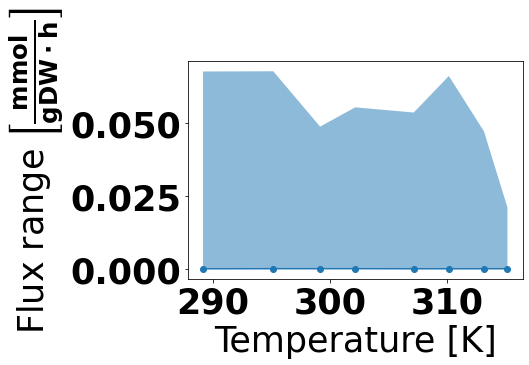

In [47]:
plot_range(aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index(),what="std")

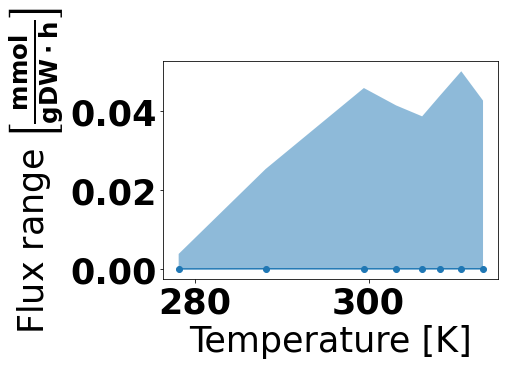

In [48]:
plot_range(aggregated_fva_res.loc[("unpermuted","original","anaerobic")].reset_index(),what="std")

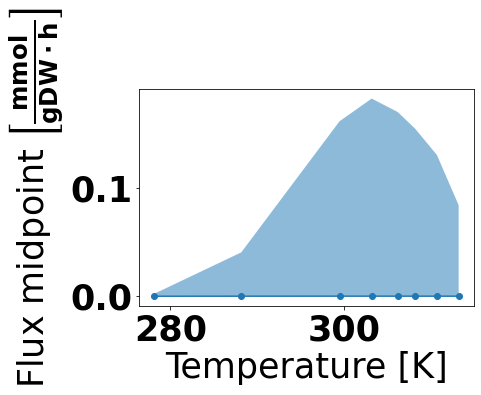

In [49]:
plot_midpoint(aggregated_fva_res.loc[("unpermuted","original","anaerobic")].reset_index(),what="mean")

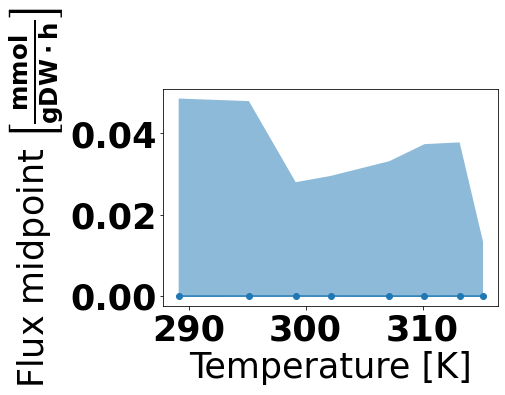

In [50]:
plot_midpoint(aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index(),what="std")

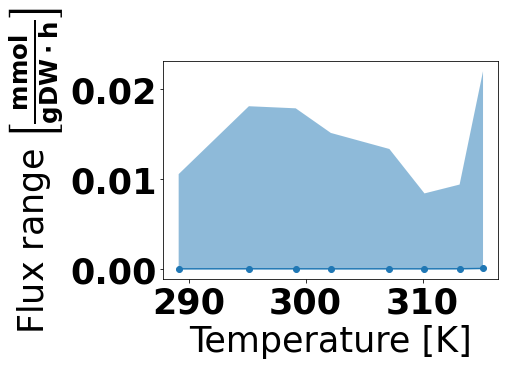

In [51]:
plot_range(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),what="std")

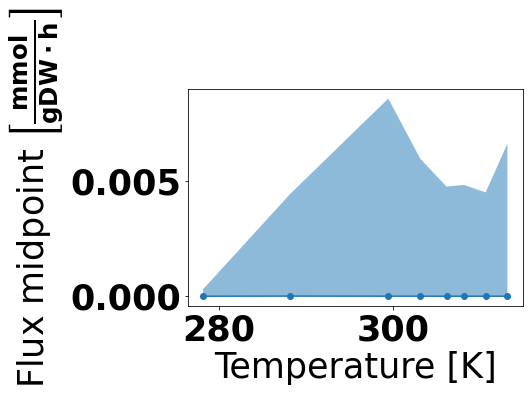

In [52]:
plot_midpoint(aggregated_fva_res.loc[("unpermuted","evolutionary","anaerobic")].reset_index(),what="std")

In [53]:
def plot_std_histogram(result):
    epsilon = 1e-2
    # We do not want reactions which range can be extreme, so we remove them before doing something else
    extreme_reactions = result[(result[("range","mean")] > 100) & (result[("midpoint","mean")] > 100)]["reaction"].unique()
    refined_result = result.dropna(how="any").pipe(lambda df: df[~ df["reaction"].isin(extreme_reactions)])
    Ts = np.sort(np.unique(refined_result["T"]))
    reactions = np.sort(np.unique(refined_result["reaction"]))
    listed_results = {T: refined_result[refined_result["T"] == T].drop(columns=["T"]).sort_values(by="reaction")["midpoint"]["std"].to_numpy() for T in Ts}
    ncol = 3
    nrow = np.ceil(len(Ts) / ncol).astype('int')
    for i, T in enumerate(Ts):
        plt.subplot(nrow, ncol, i + 1)
        this_results = listed_results[T]
        this_results = this_results[this_results > epsilon]
        # this_results[this_results < epsilon] = epsilon
        plt.hist(np.log10(this_results),bins=50)
        plt.title(f"T={T}, $n=${len(this_results)}")
        plt.ylabel("#Reactions")
        plt.xlabel(r"$\sigma_{\mathrm{FVA Range}}\; \left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlim((-2,2))
        plt.ylim((0,100))

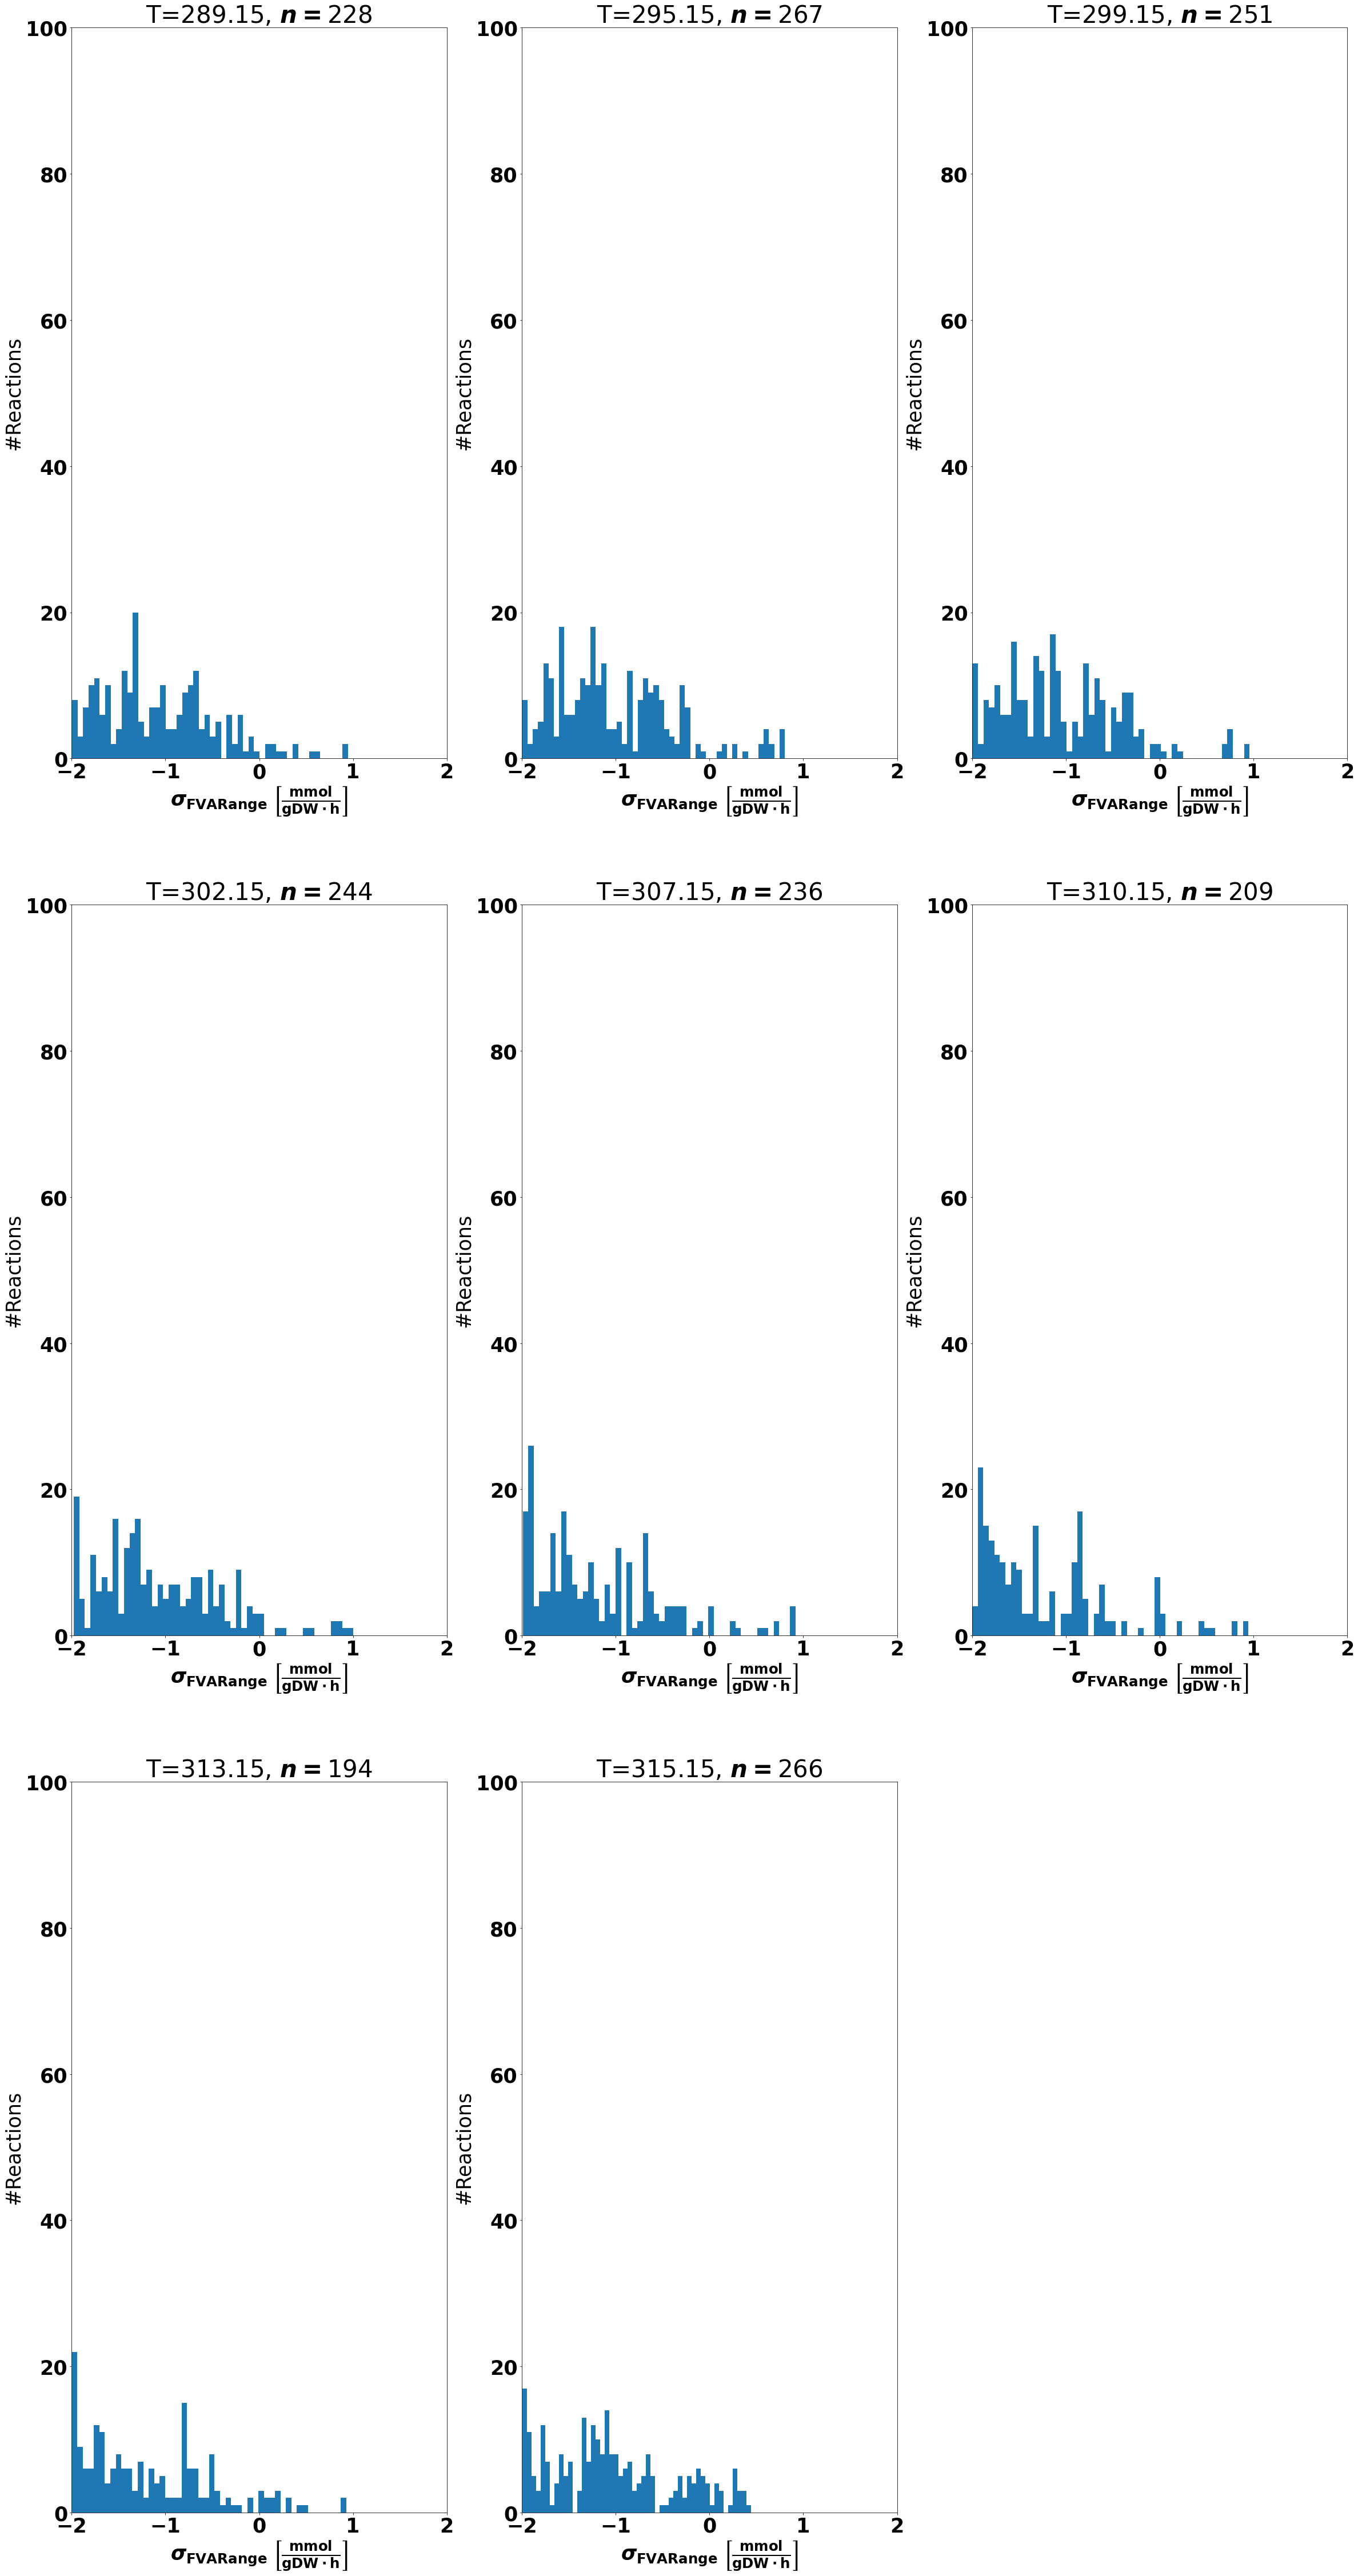

In [54]:
plt.figure(figsize=(40,80))
plot_std_histogram(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index())

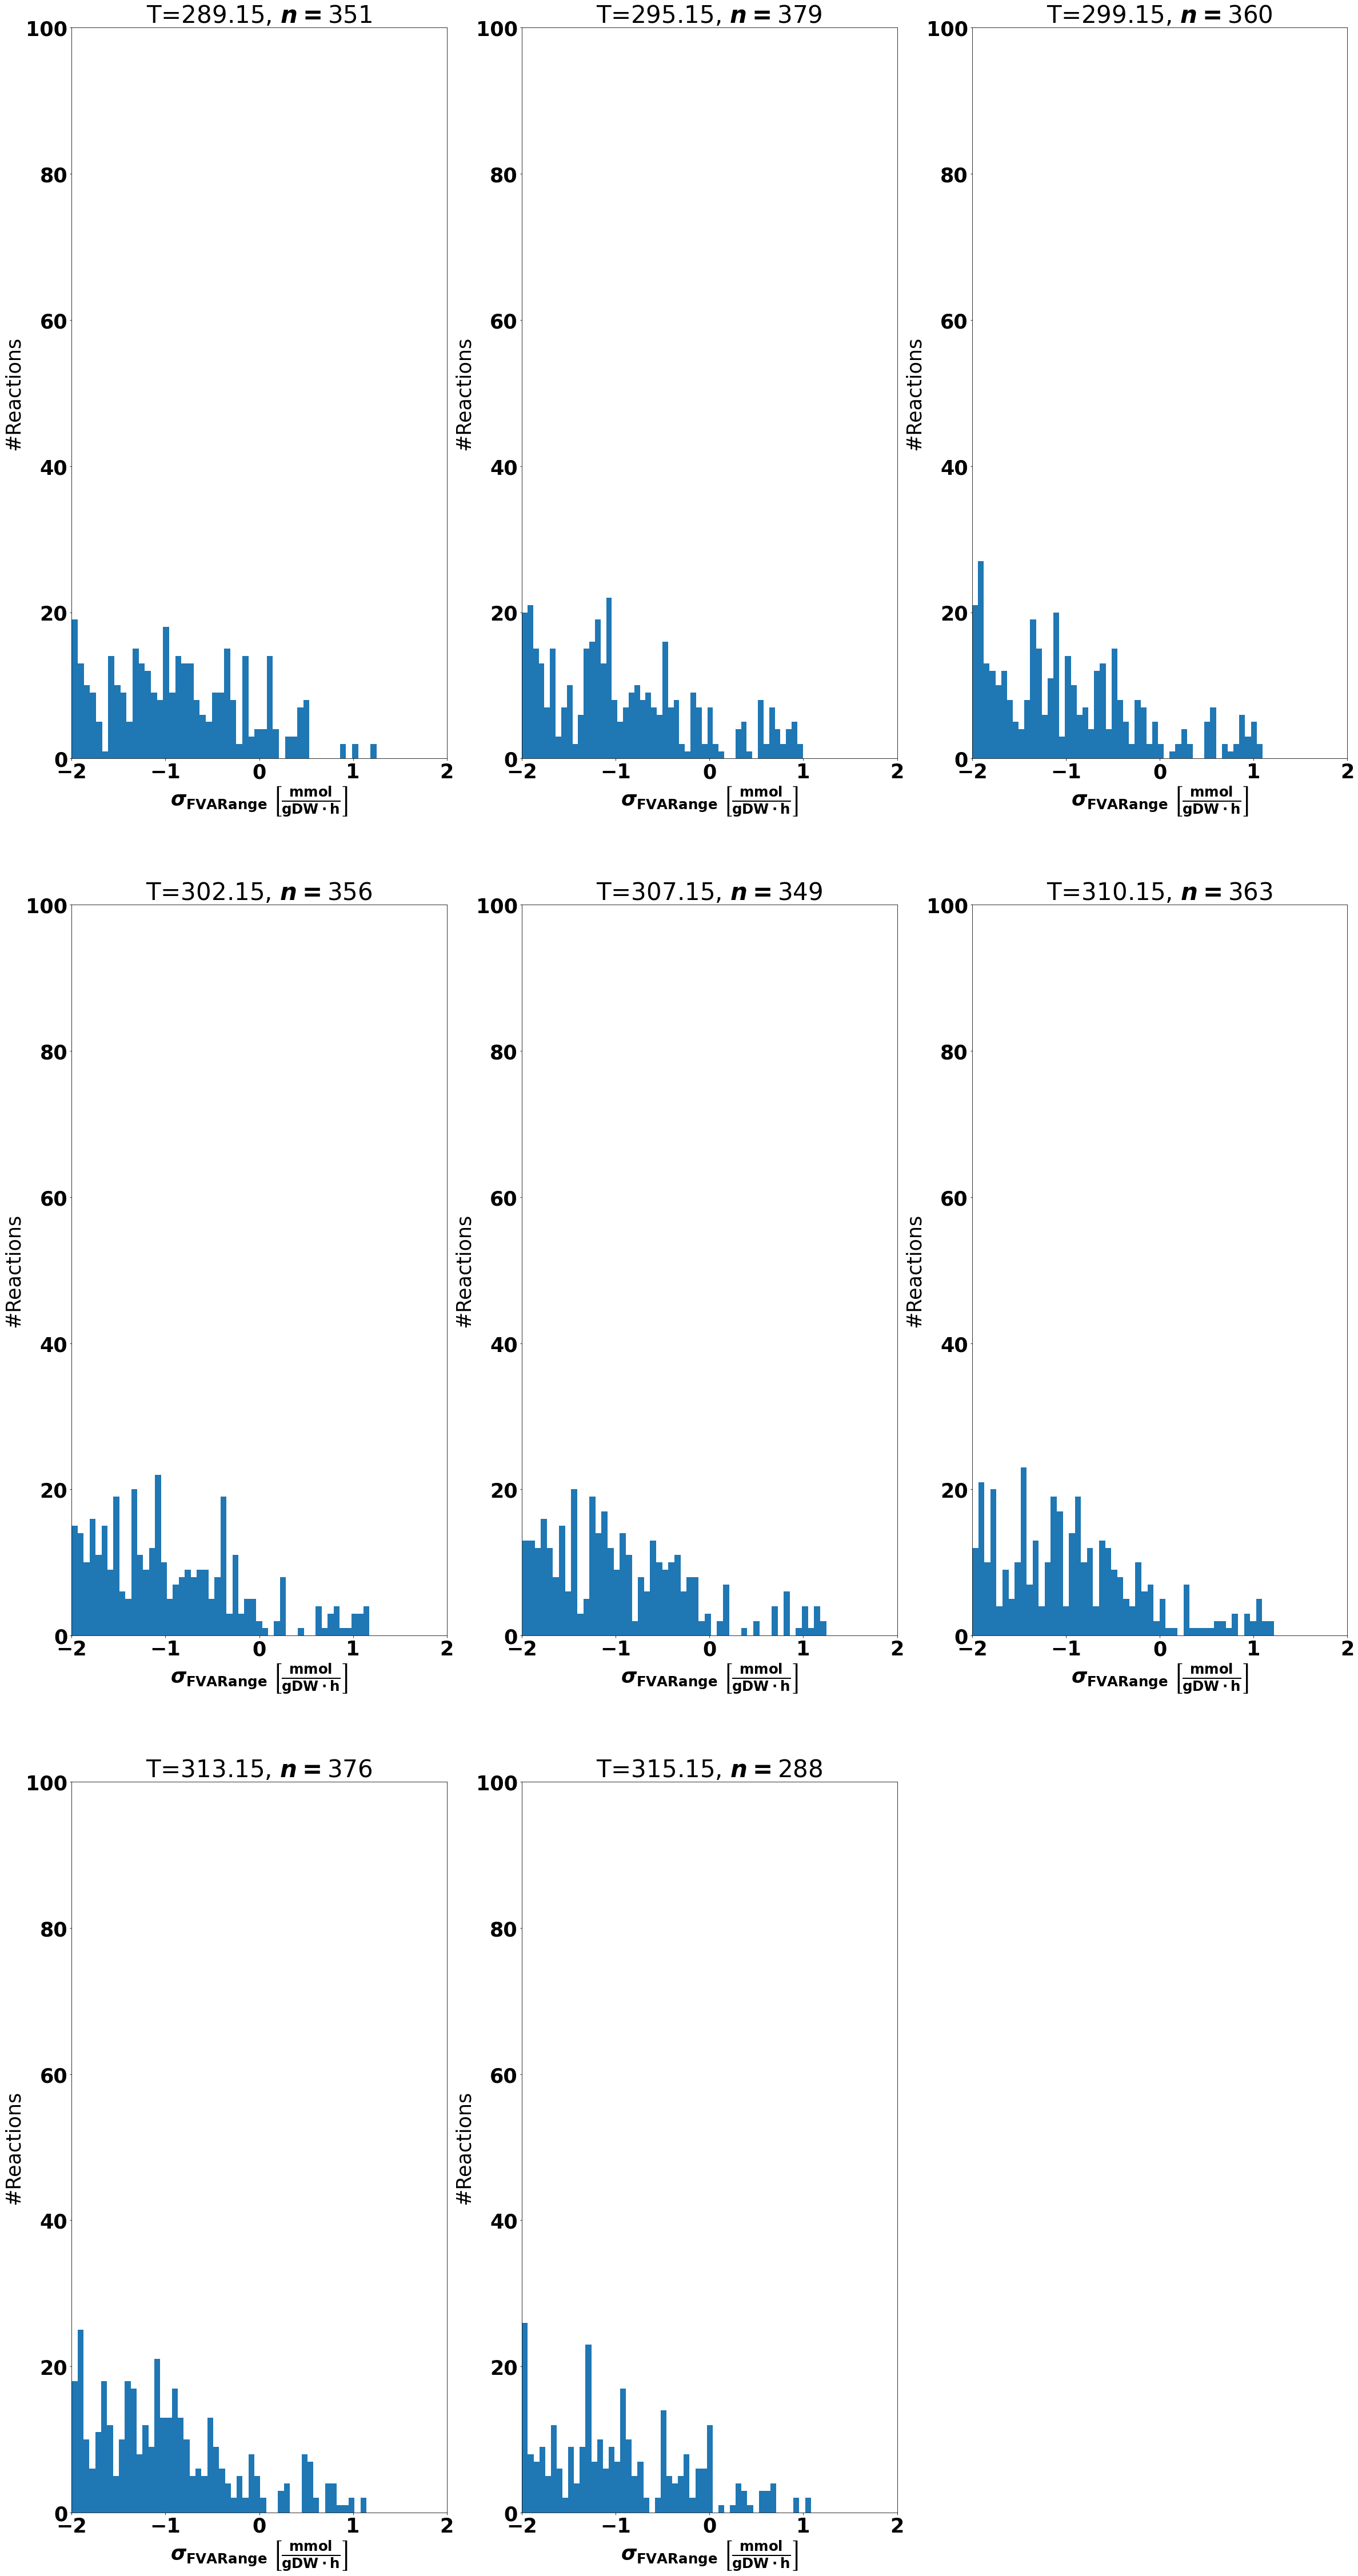

In [55]:
plt.figure(figsize=(40,80))
plot_std_histogram(aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index())

In [56]:
def cumulative_range_std(result):
    epsilon = 1e-2
    # We do not want reactions which range can be extreme, so we remove them before doing something else
    extreme_reactions = result[(result[("range","mean")] > 100) & (result[("midpoint","mean")] > 100)]["reaction"].unique()
    refined_result = result.dropna(how="any").pipe(lambda df: df[~ df["reaction"].isin(extreme_reactions)])
    Ts = np.sort(np.unique(refined_result["T"]))
    reactions = np.sort(np.unique(refined_result["reaction"]))
    listed_results = {T: refined_result[refined_result["T"] == T].drop(columns=["T"]).sort_values(by="reaction")["midpoint"]["std"].to_numpy() for T in Ts}
    ncol = 3
    nrow = np.ceil(len(Ts) / ncol).astype('int')
    for i, T in enumerate(Ts):
        # plt.subplot(nrow, ncol, i + 1)
        this_results = listed_results[T]
        this_results = this_results[this_results > epsilon]
        plt.hist(this_results,density=True,cumulative=True,histtype='step',bins=np.linspace(0,1,1000),label=f"T={T}")
        # plt.title(f"T={T}")
        # plt.xlim((0,1))
    plt.ylabel("Cumulative proportion")
    plt.xlabel(r"$\sigma_{\mathrm{FVA Range}}\; \left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
    plt.legend()

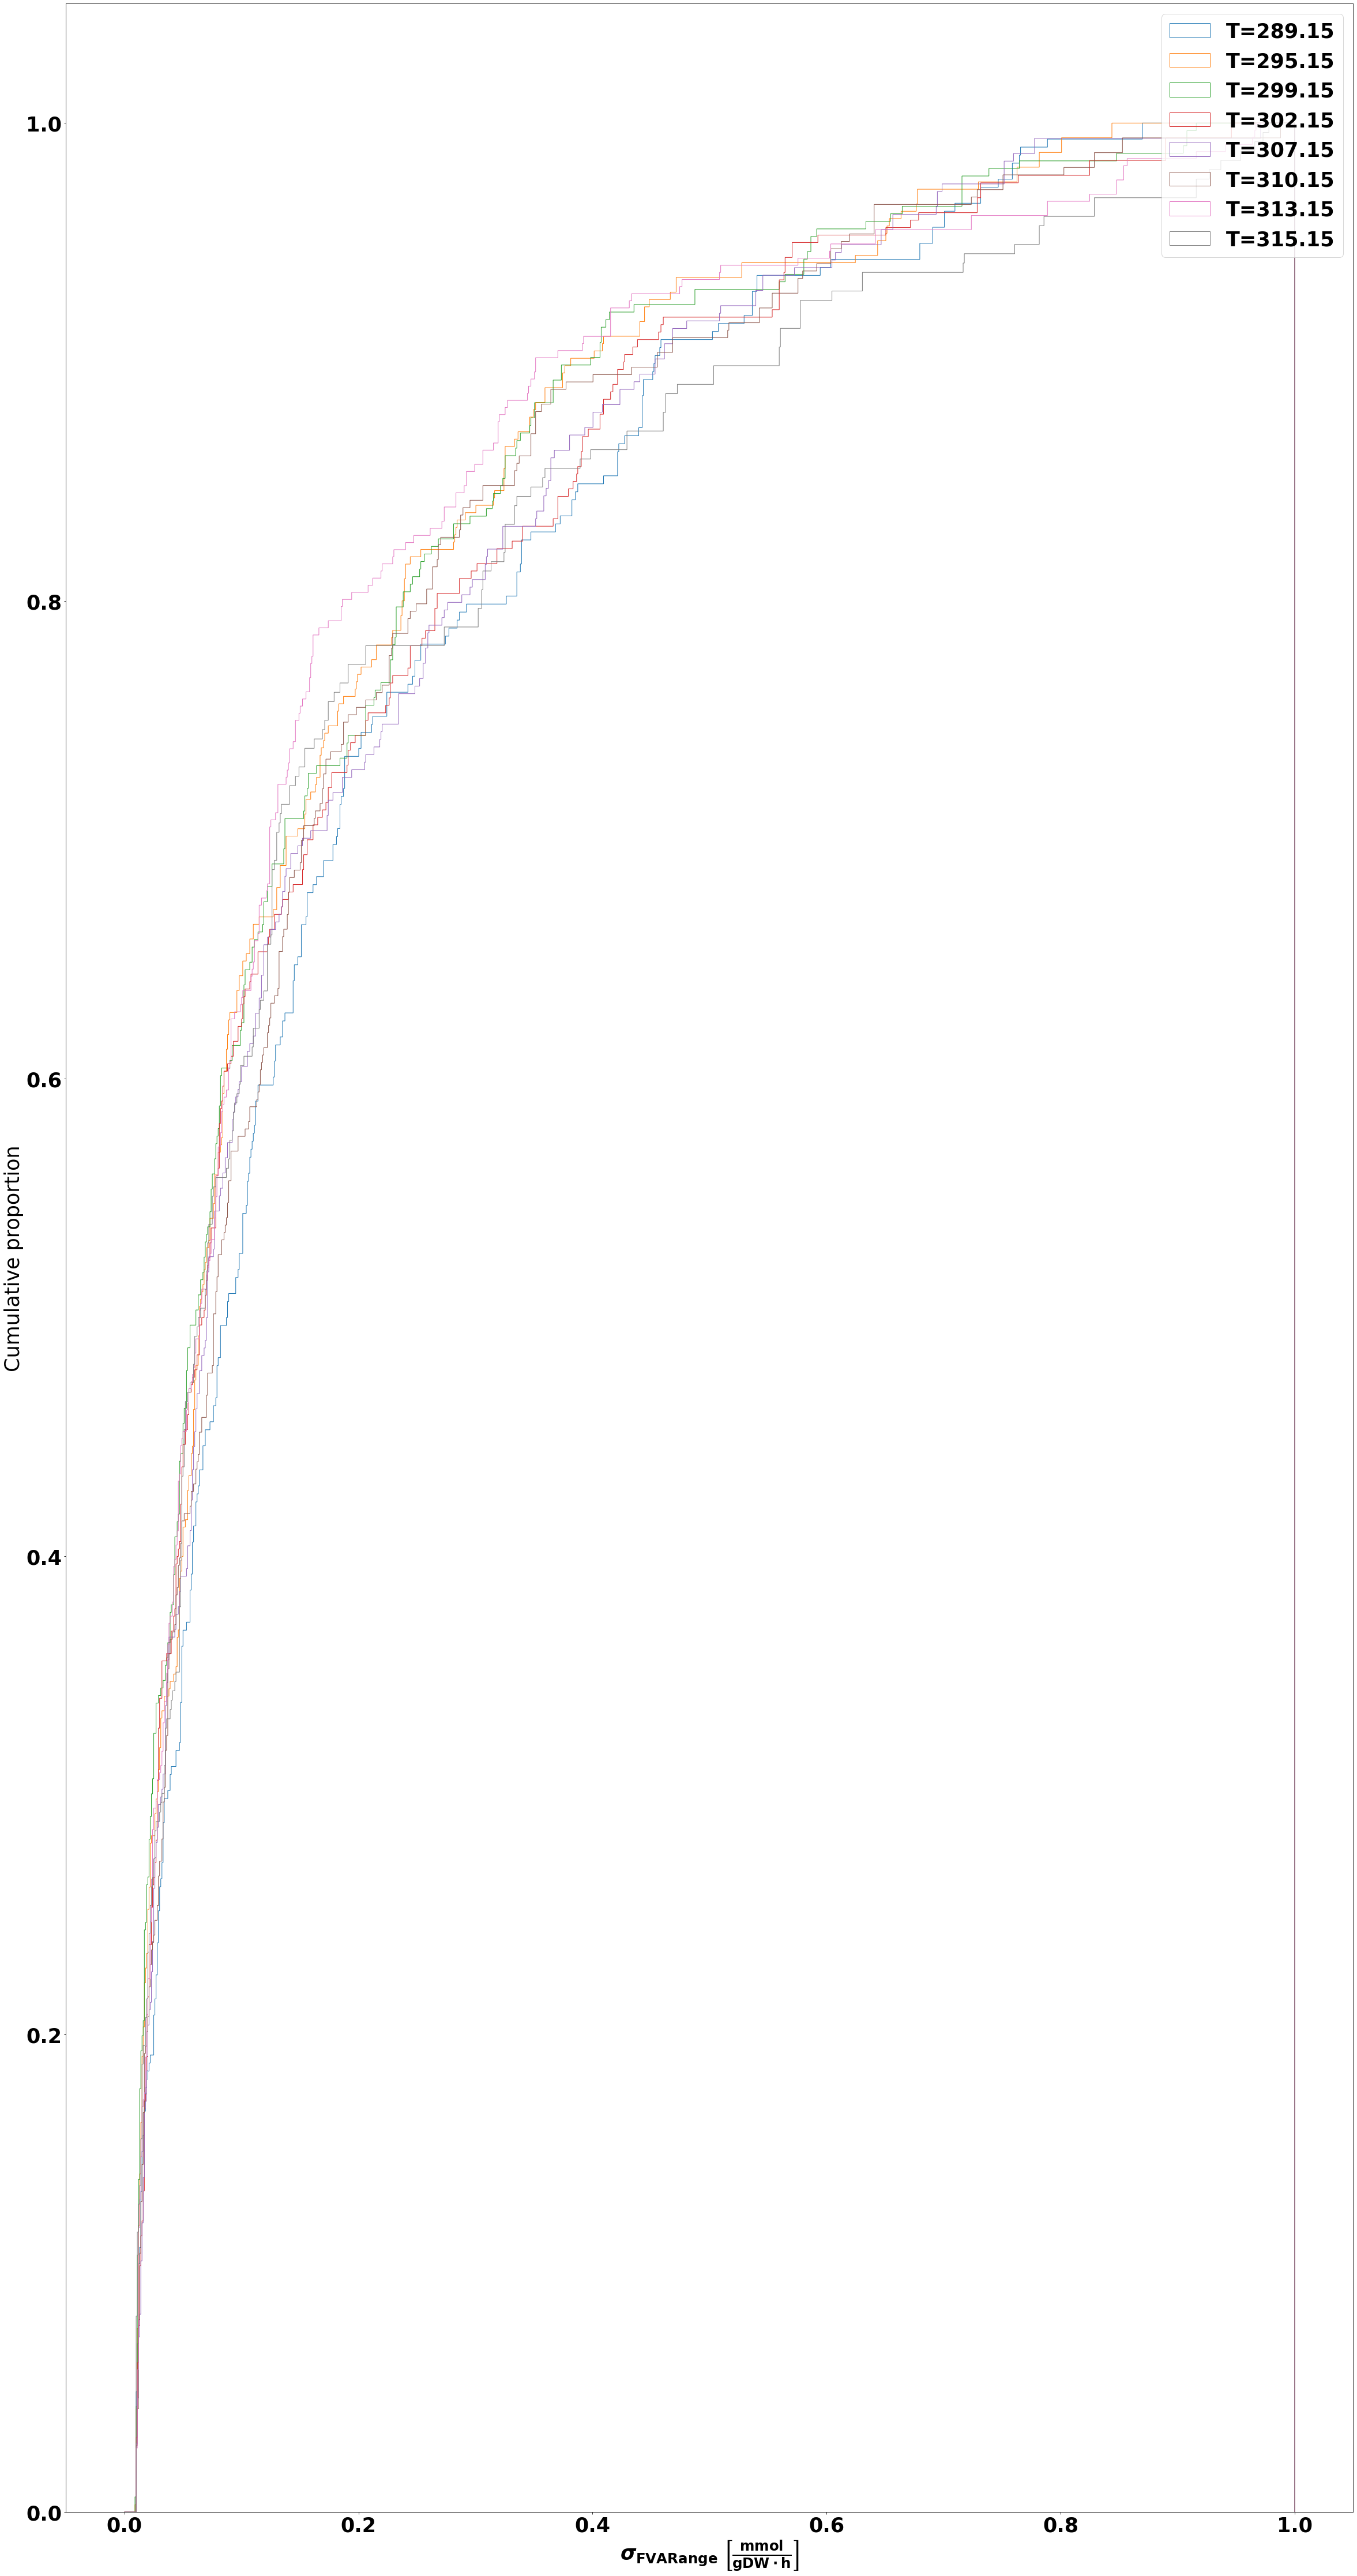

In [57]:
plt.figure(figsize=(40,80))
cumulative_range_std(aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index())

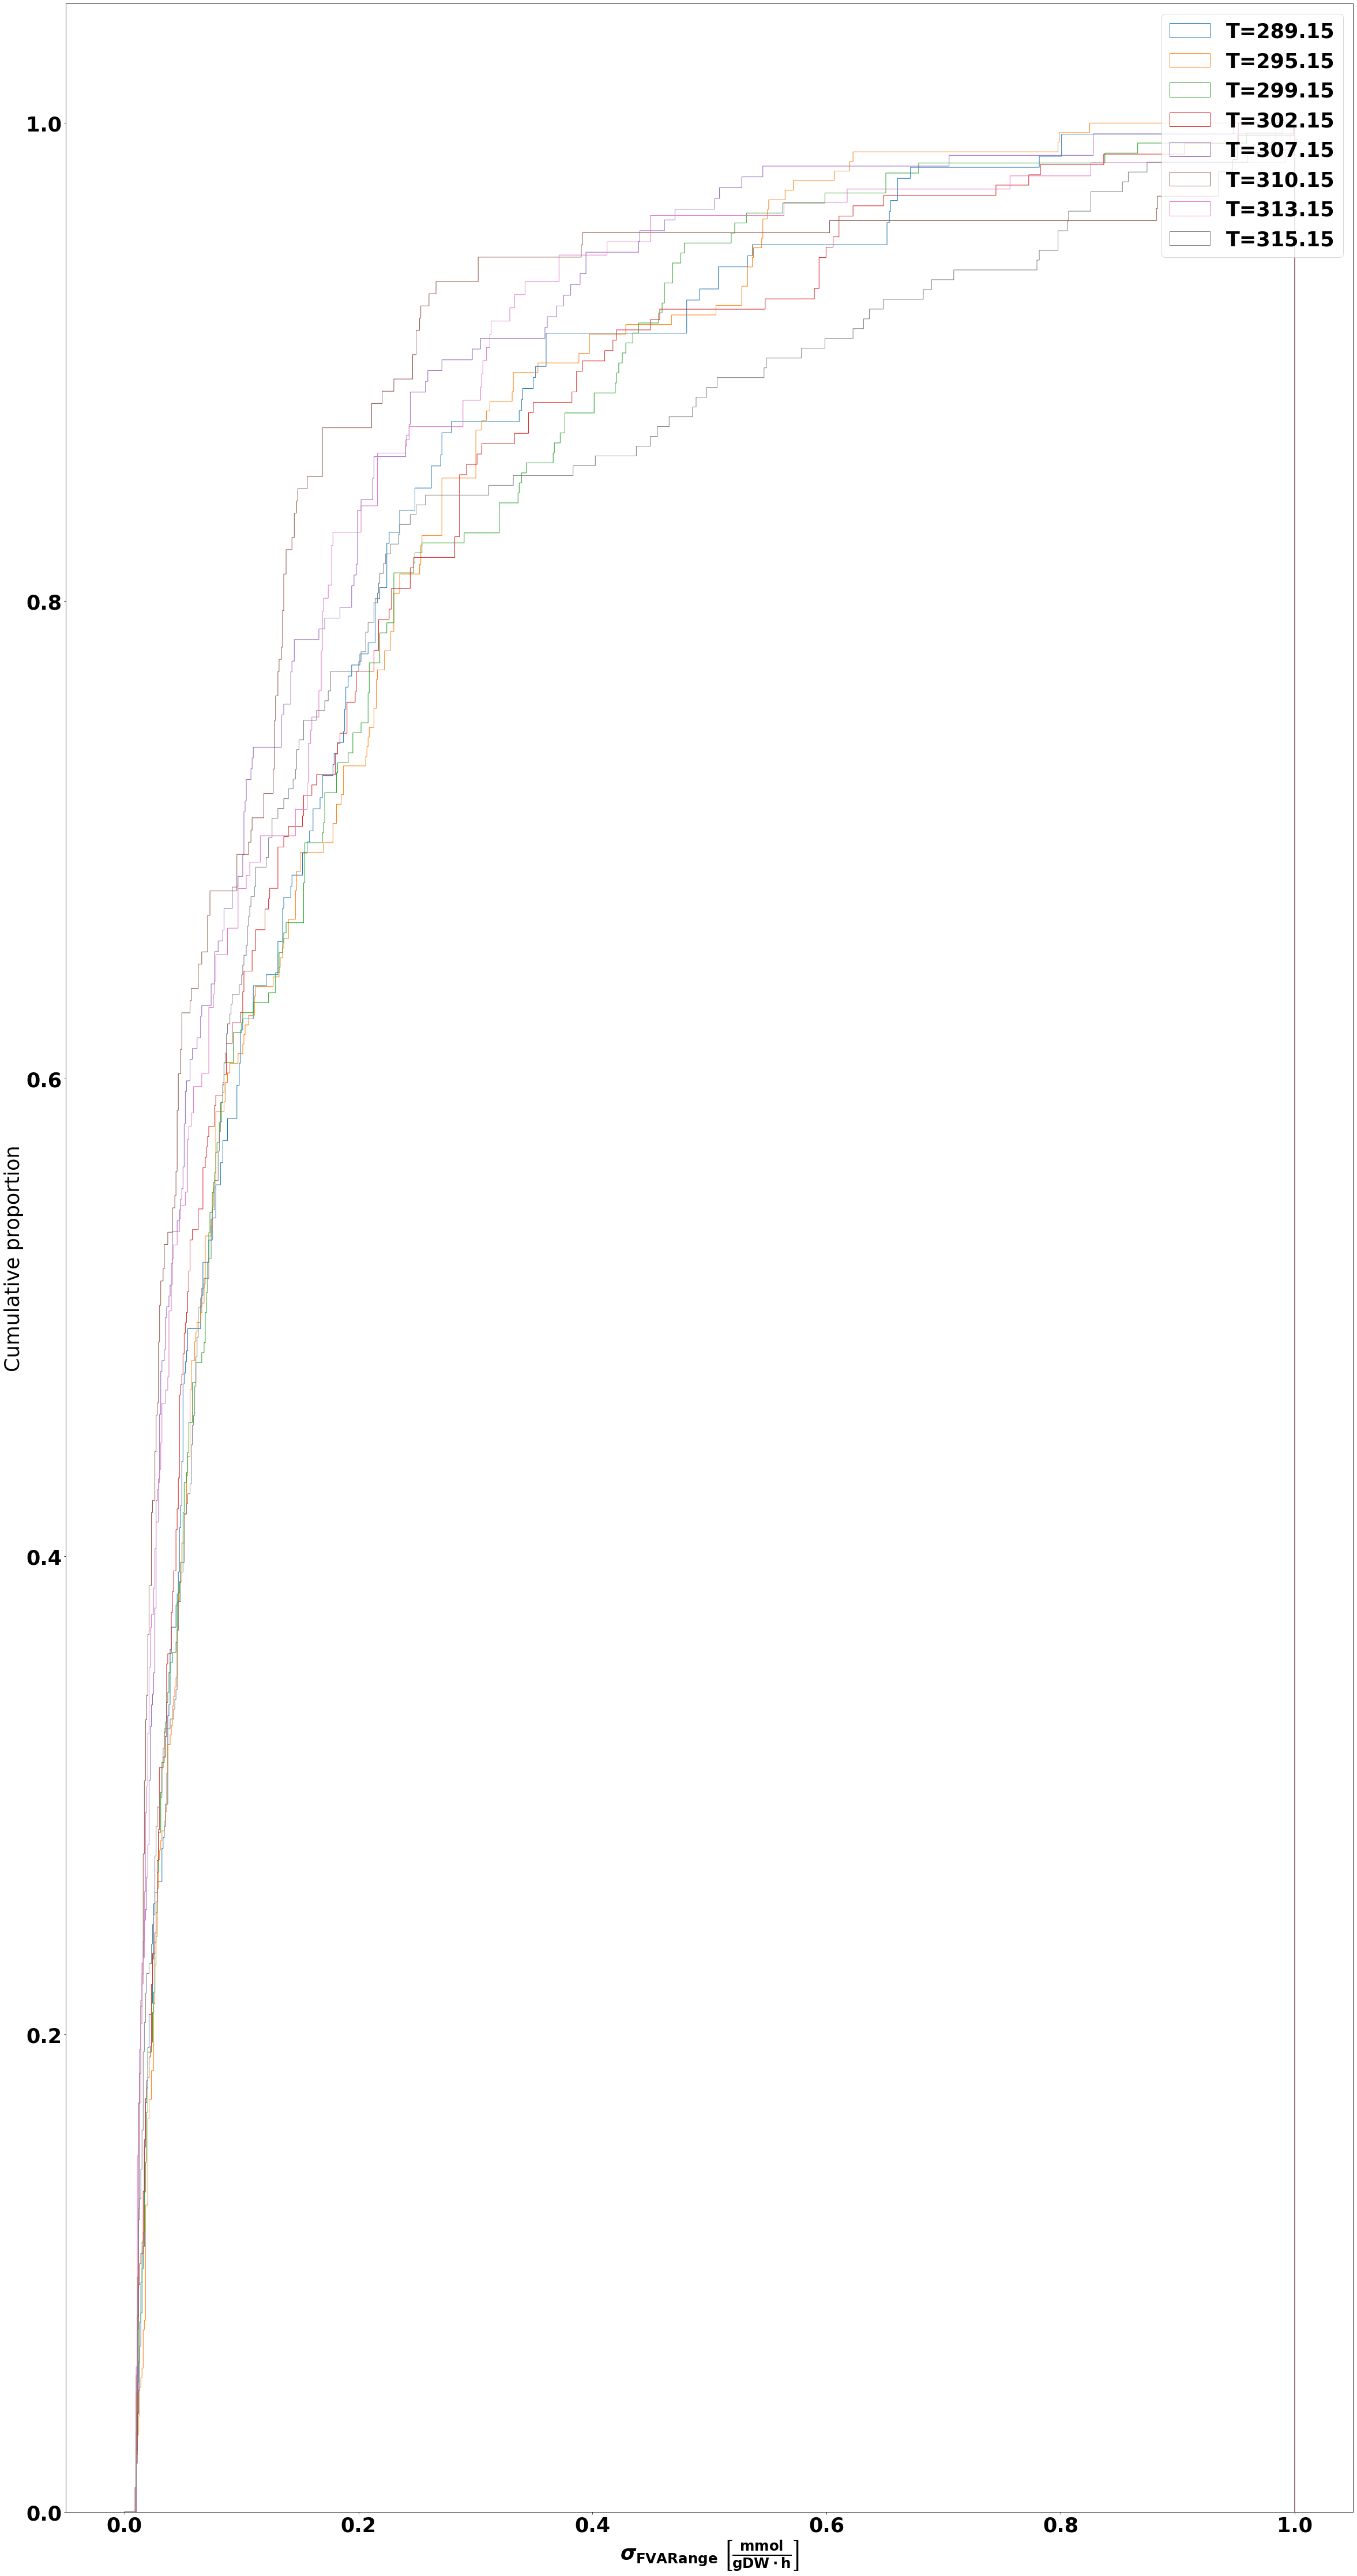

In [58]:
plt.figure(figsize=(40,80))
cumulative_range_std(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index())

In [59]:
pal = sns.color_palette()

In [60]:
len(pal)

10

In [61]:
import matplotlib.lines as mlines
def cumulative_range_std_compare(result_1,result_2,label_1="Bayesian",label_2="Evolutionary"):
    epsilon = 1e-2
    def prepare_result(result):
        # We do not want reactions which range can be extreme, so we remove them before doing something else
        return result.dropna(how="any").pipe(lambda df: df[~ df["reaction"].isin(extreme_reactions)])
    find_extreme_reactions = lambda result: result[(result[("range","mean")] > 100) & (result[("midpoint","mean")] > 100)]["reaction"].unique()
    extreme_reactions = np.union1d(*map(find_extreme_reactions,(result_1,result_2)))
    refined_result_1, refined_result_2 = map(prepare_result,(result_1,result_2))
    Ts = np.sort(np.unique(refined_result_1["T"]))
    reactions = np.sort(np.unique(refined_result_1["reaction"]))
    def extract_results_for_T(refined_result, T):
        res = refined_result[refined_result["T"] == T].drop(columns=["T"]).sort_values(by="reaction")["midpoint"]["std"].to_numpy()
        return res[res > epsilon]
    listed_results = {T: (extract_results_for_T(refined_result_1,T),extract_results_for_T(refined_result_2,T)) for T in Ts}
    pal = sns.color_palette()
    for i, T in enumerate(Ts):
        this_results = listed_results[T]
        plt.hist(this_results[0],density=True,cumulative=True,histtype='step',bins=np.linspace(0,1,1000),label=f"T={T}",color=pal[i],linestyle="solid")
        plt.hist(this_results[1],density=True,cumulative=True,histtype='step',bins=np.linspace(0,1,1000),label=f"T={T}",color=pal[i],linestyle="dashed")
        # plt.title(f"T={T}")
        # plt.xlim((0,1))
    plt.ylabel("Cumulative proportion")
    plt.xlabel(r"$\sigma_{\mathrm{FVA Range}}\; \left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
    f = lambda l,c: mlines.Line2D([],[],color=c,linestyle=l,linewidth=2)
    handles_temperature = [f("solid", color) for color in pal[0:len(Ts)]]
    handles_model = [f(linestyle, "k") for linestyle in ("solid","dashed")]
    legend_temperature = plt.legend(handles_temperature, Ts, framealpha=1,loc=(0.8,0.8))
    legend_model = plt.legend(handles_model, [label_1, label_2], framealpha=1,handletextpad=0.5, loc=(0.9,0.9))
    plt.gca().add_artist(legend_temperature)
    plt.gca().add_artist(legend_model)

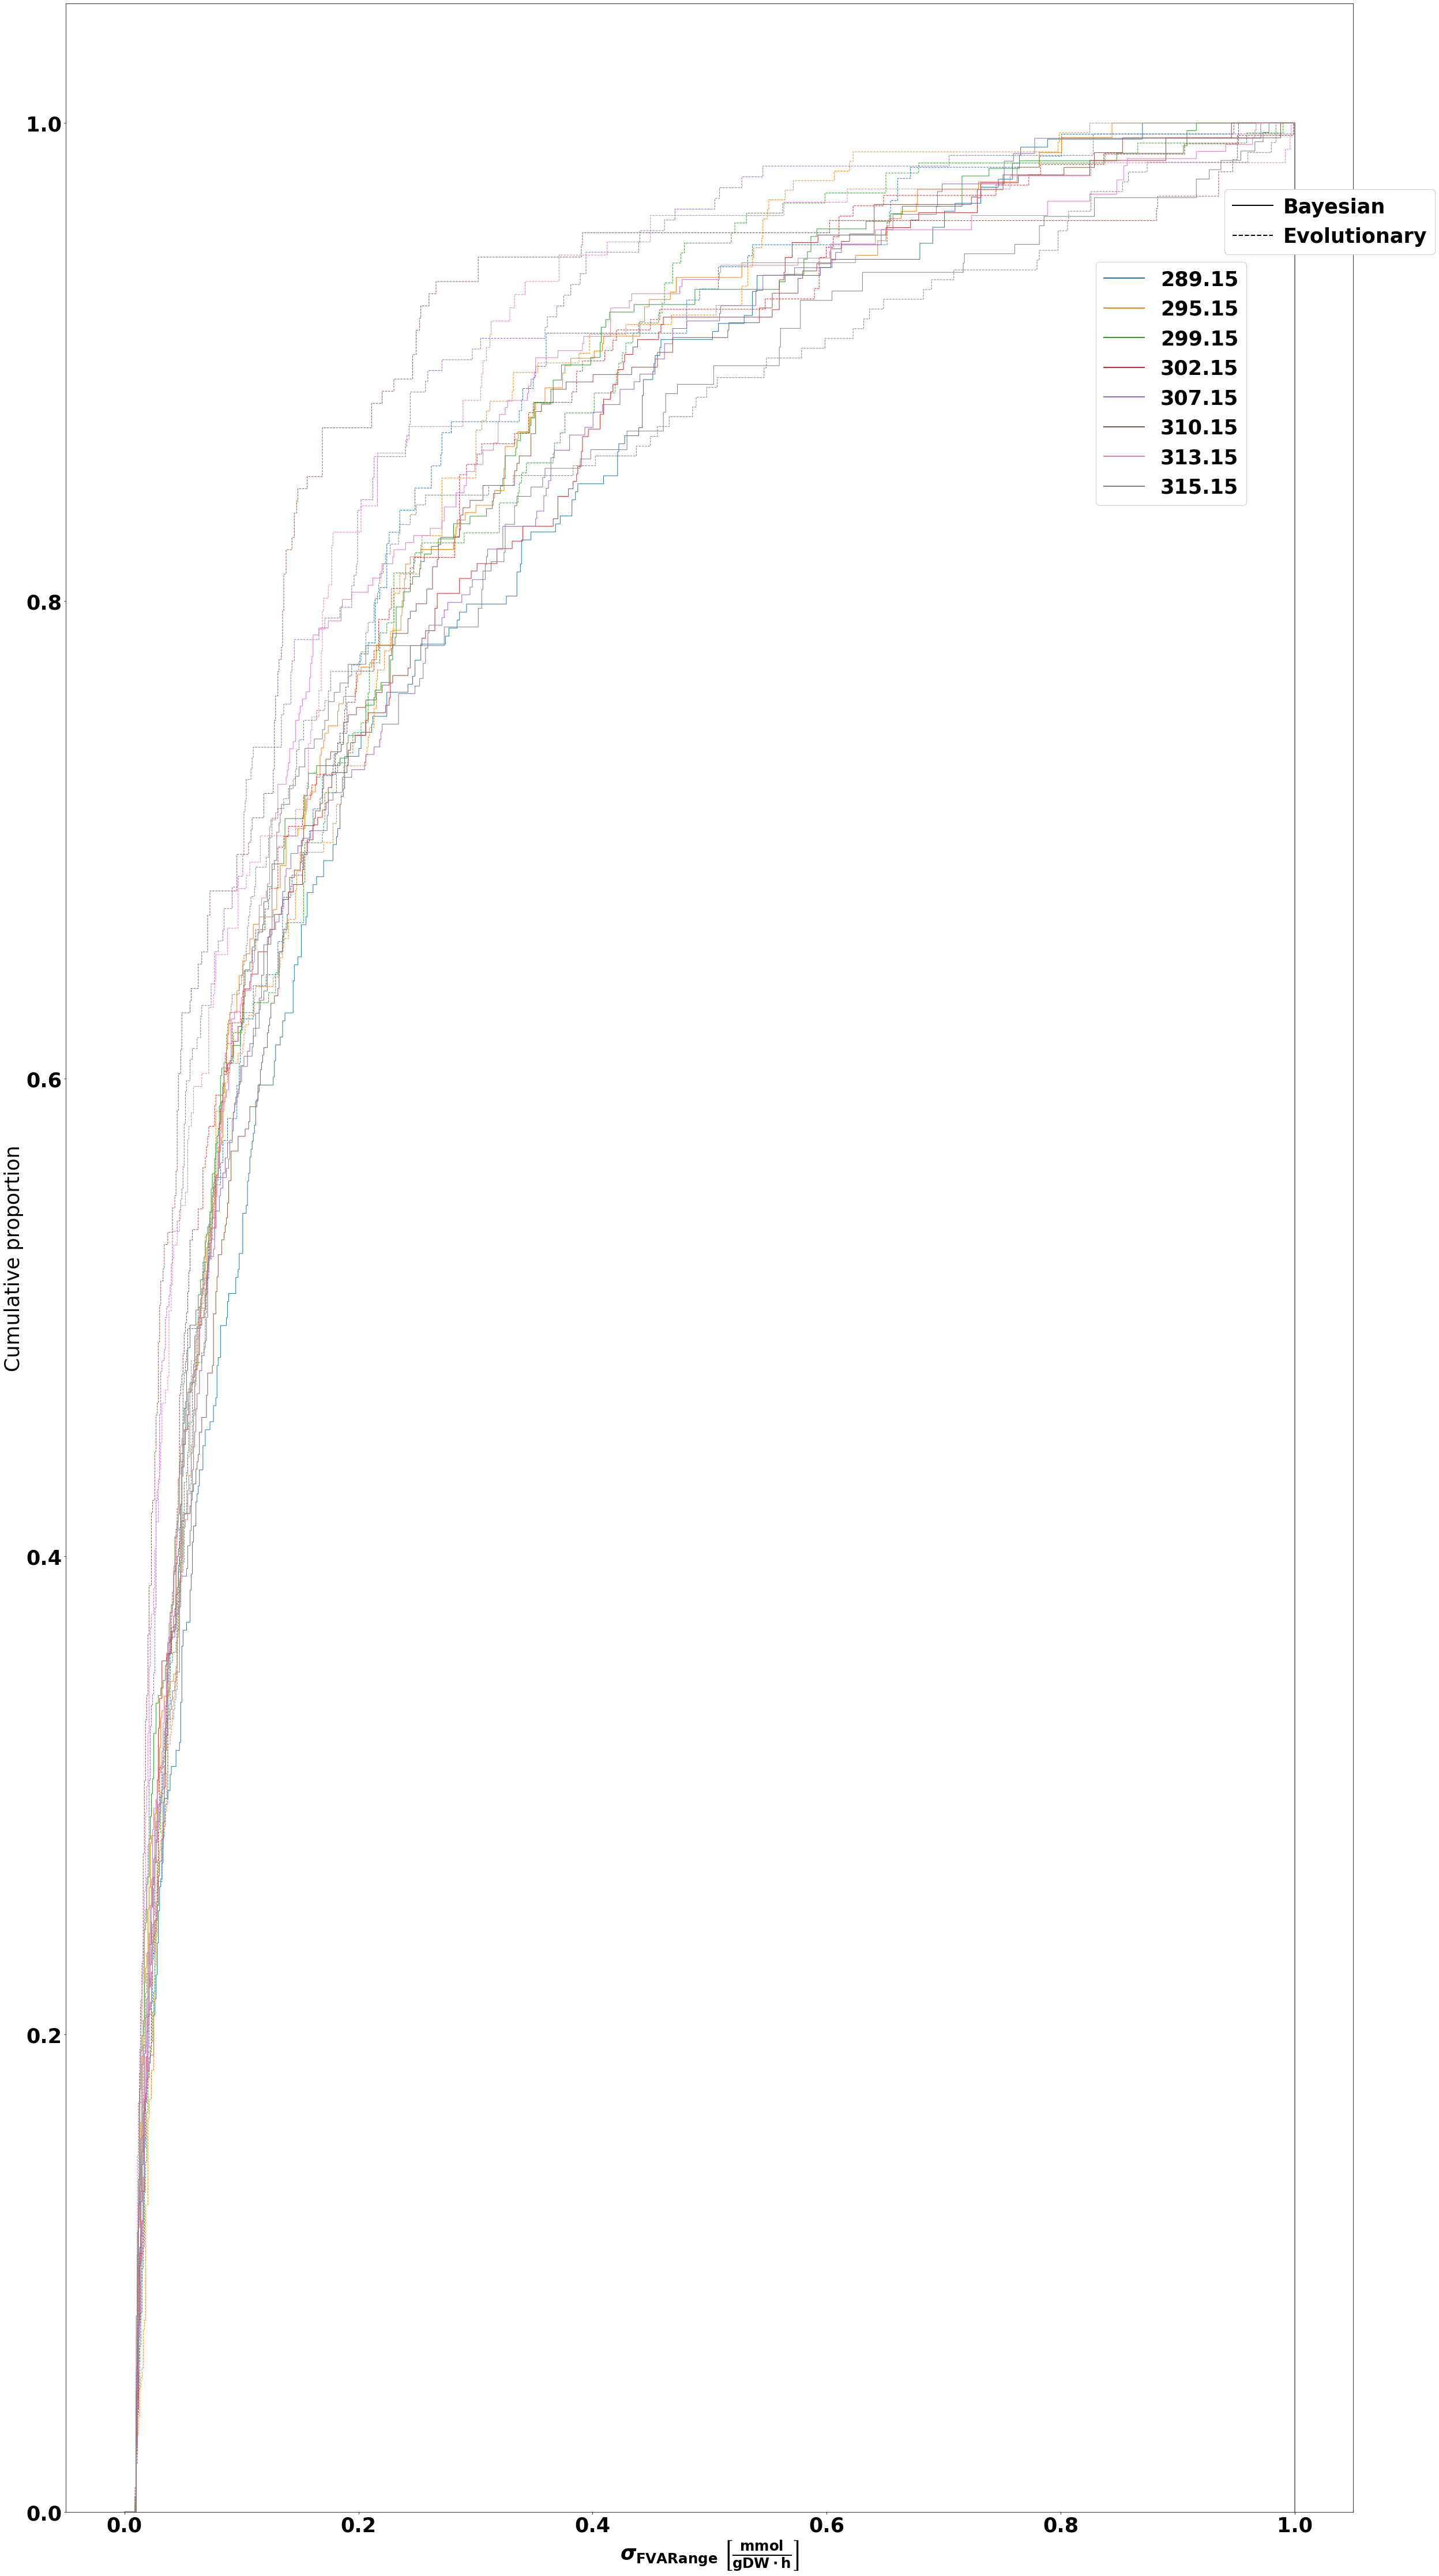

In [62]:
plt.figure(figsize=(40,80))
cumulative_range_std_compare(aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index())

In [63]:
import matplotlib.lines as mlines
def cumulative_range_std_compare_array(result_1,result_2,label_1="Bayesian",label_2="Evolutionary", what = "range"):
    epsilon = 1e-2
    def prepare_result(result):
        # We do not want reactions which range can be extreme, so we remove them before doing something else
        return result.dropna(how="any").pipe(lambda df: df[~ df["reaction"].isin(extreme_reactions)])
    find_extreme_reactions = lambda result: result[(result[("range","mean")] > 100) & (result[("midpoint","mean")] > 100)]["reaction"].unique()
    extreme_reactions = np.union1d(*map(find_extreme_reactions,(result_1,result_2)))
    refined_result_1, refined_result_2 = map(prepare_result,(result_1,result_2))
    Ts = np.sort(np.unique(refined_result_1["T"]))
    reactions = np.sort(np.unique(refined_result_1["reaction"]))
    def extract_results_for_T(refined_result, T):
        res = refined_result[refined_result["T"] == T].drop(columns=["T"]).sort_values(by="reaction")[what]["std"].to_numpy()
        return res[res > epsilon]
    listed_results = {T: (extract_results_for_T(refined_result_1,T),extract_results_for_T(refined_result_2,T)) for T in Ts}
    ncol = 3
    nrow = np.ceil(len(Ts) / ncol).astype('int')
    for i, T in enumerate(Ts):
        plt.subplot(nrow, ncol, i + 1)
        this_results = listed_results[T]
        common_keywargs = {"density": True, "cumulative": True,"histtype": 'step',
                           "bins": np.linspace(0,1,1000),"color": "k", "linewidth": 5}
        plt.hist(this_results[0],linestyle="solid",**common_keywargs)
        plt.hist(this_results[1],linestyle="dashed",**common_keywargs)
        plt.title(f"T={T-273.15} $^\\circ$C")
        # plt.xlim((0,1))
        plt.ylabel("Cumulative proportion")
        if what == "range":
            plt.xlabel(r"$\sigma_{\mathrm{Range}}\; \left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        else:
            plt.xlabel(r"$\sigma_{\mathrm{Midpoint}}\; \left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
    f = lambda l,c: mlines.Line2D([],[],color=c,linestyle=l,linewidth=5)
    handles_model = [f(linestyle, "k") for linestyle in ("solid","dashed")]
    legend_model = plt.legend(handles_model, [label_1, label_2], framealpha=1,handletextpad=0.5, loc=(0.9,0.9))
    plt.gcf().add_artist(legend_model)

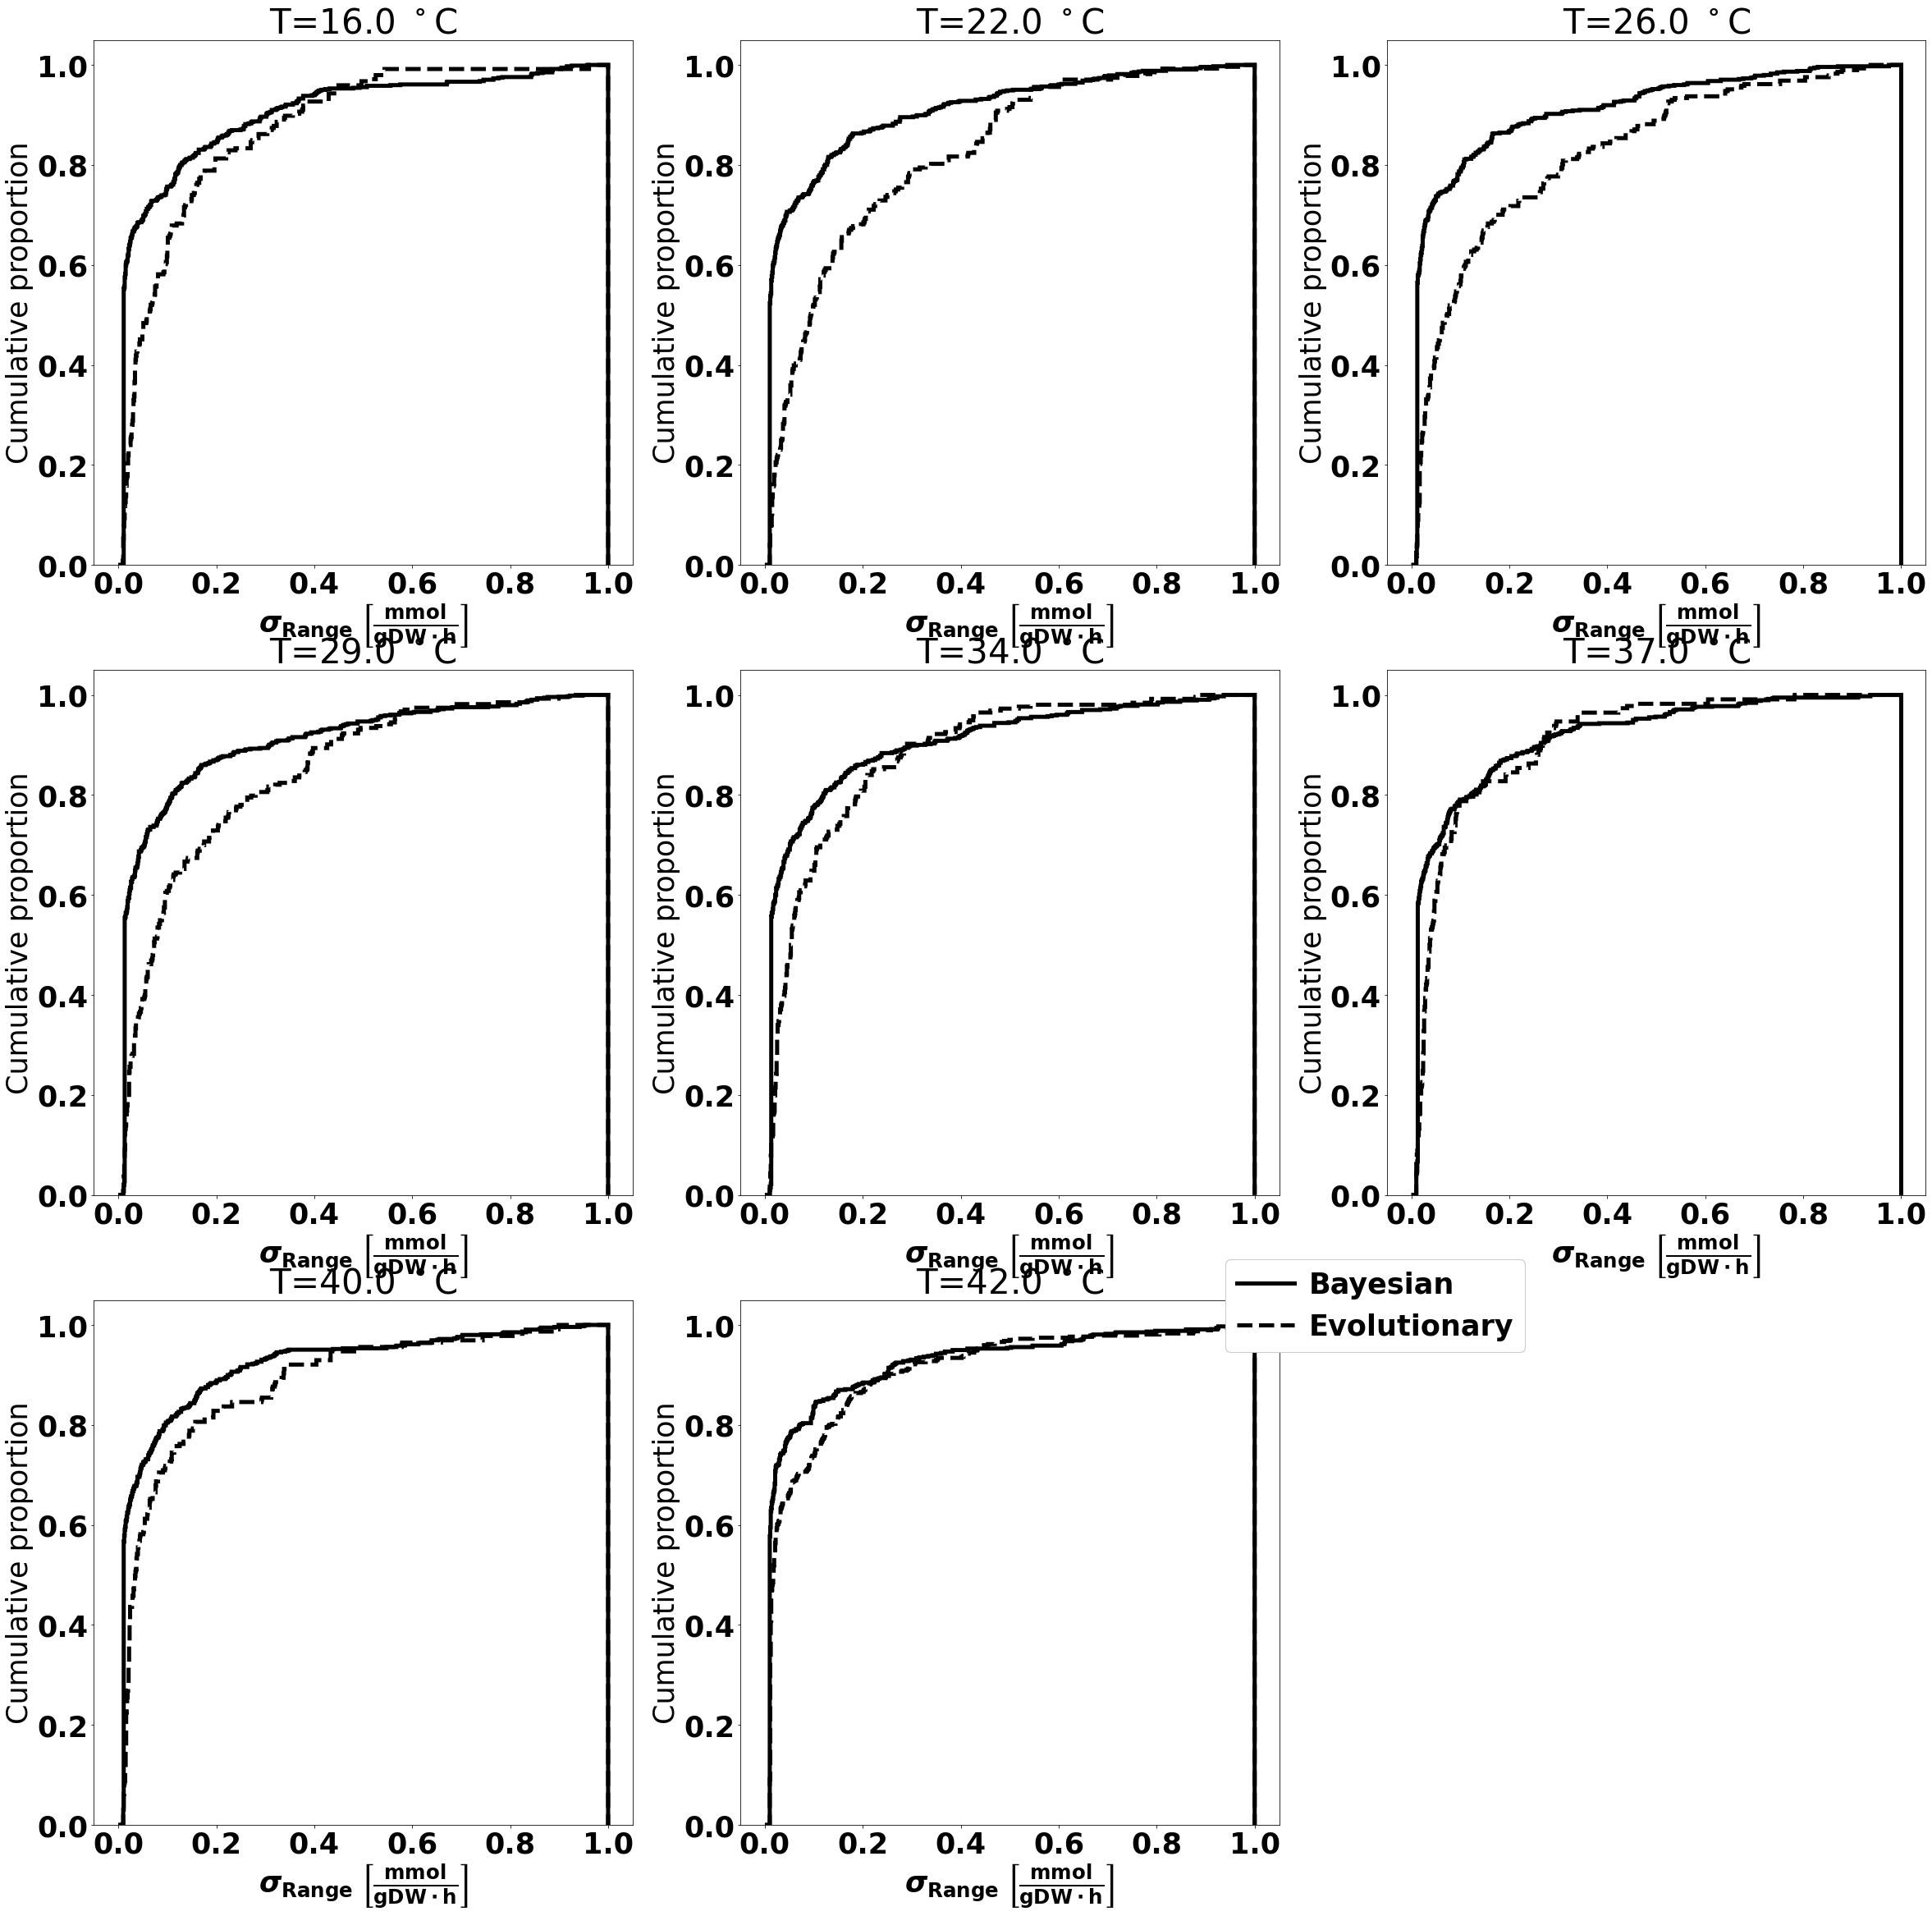

In [64]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),what="range")

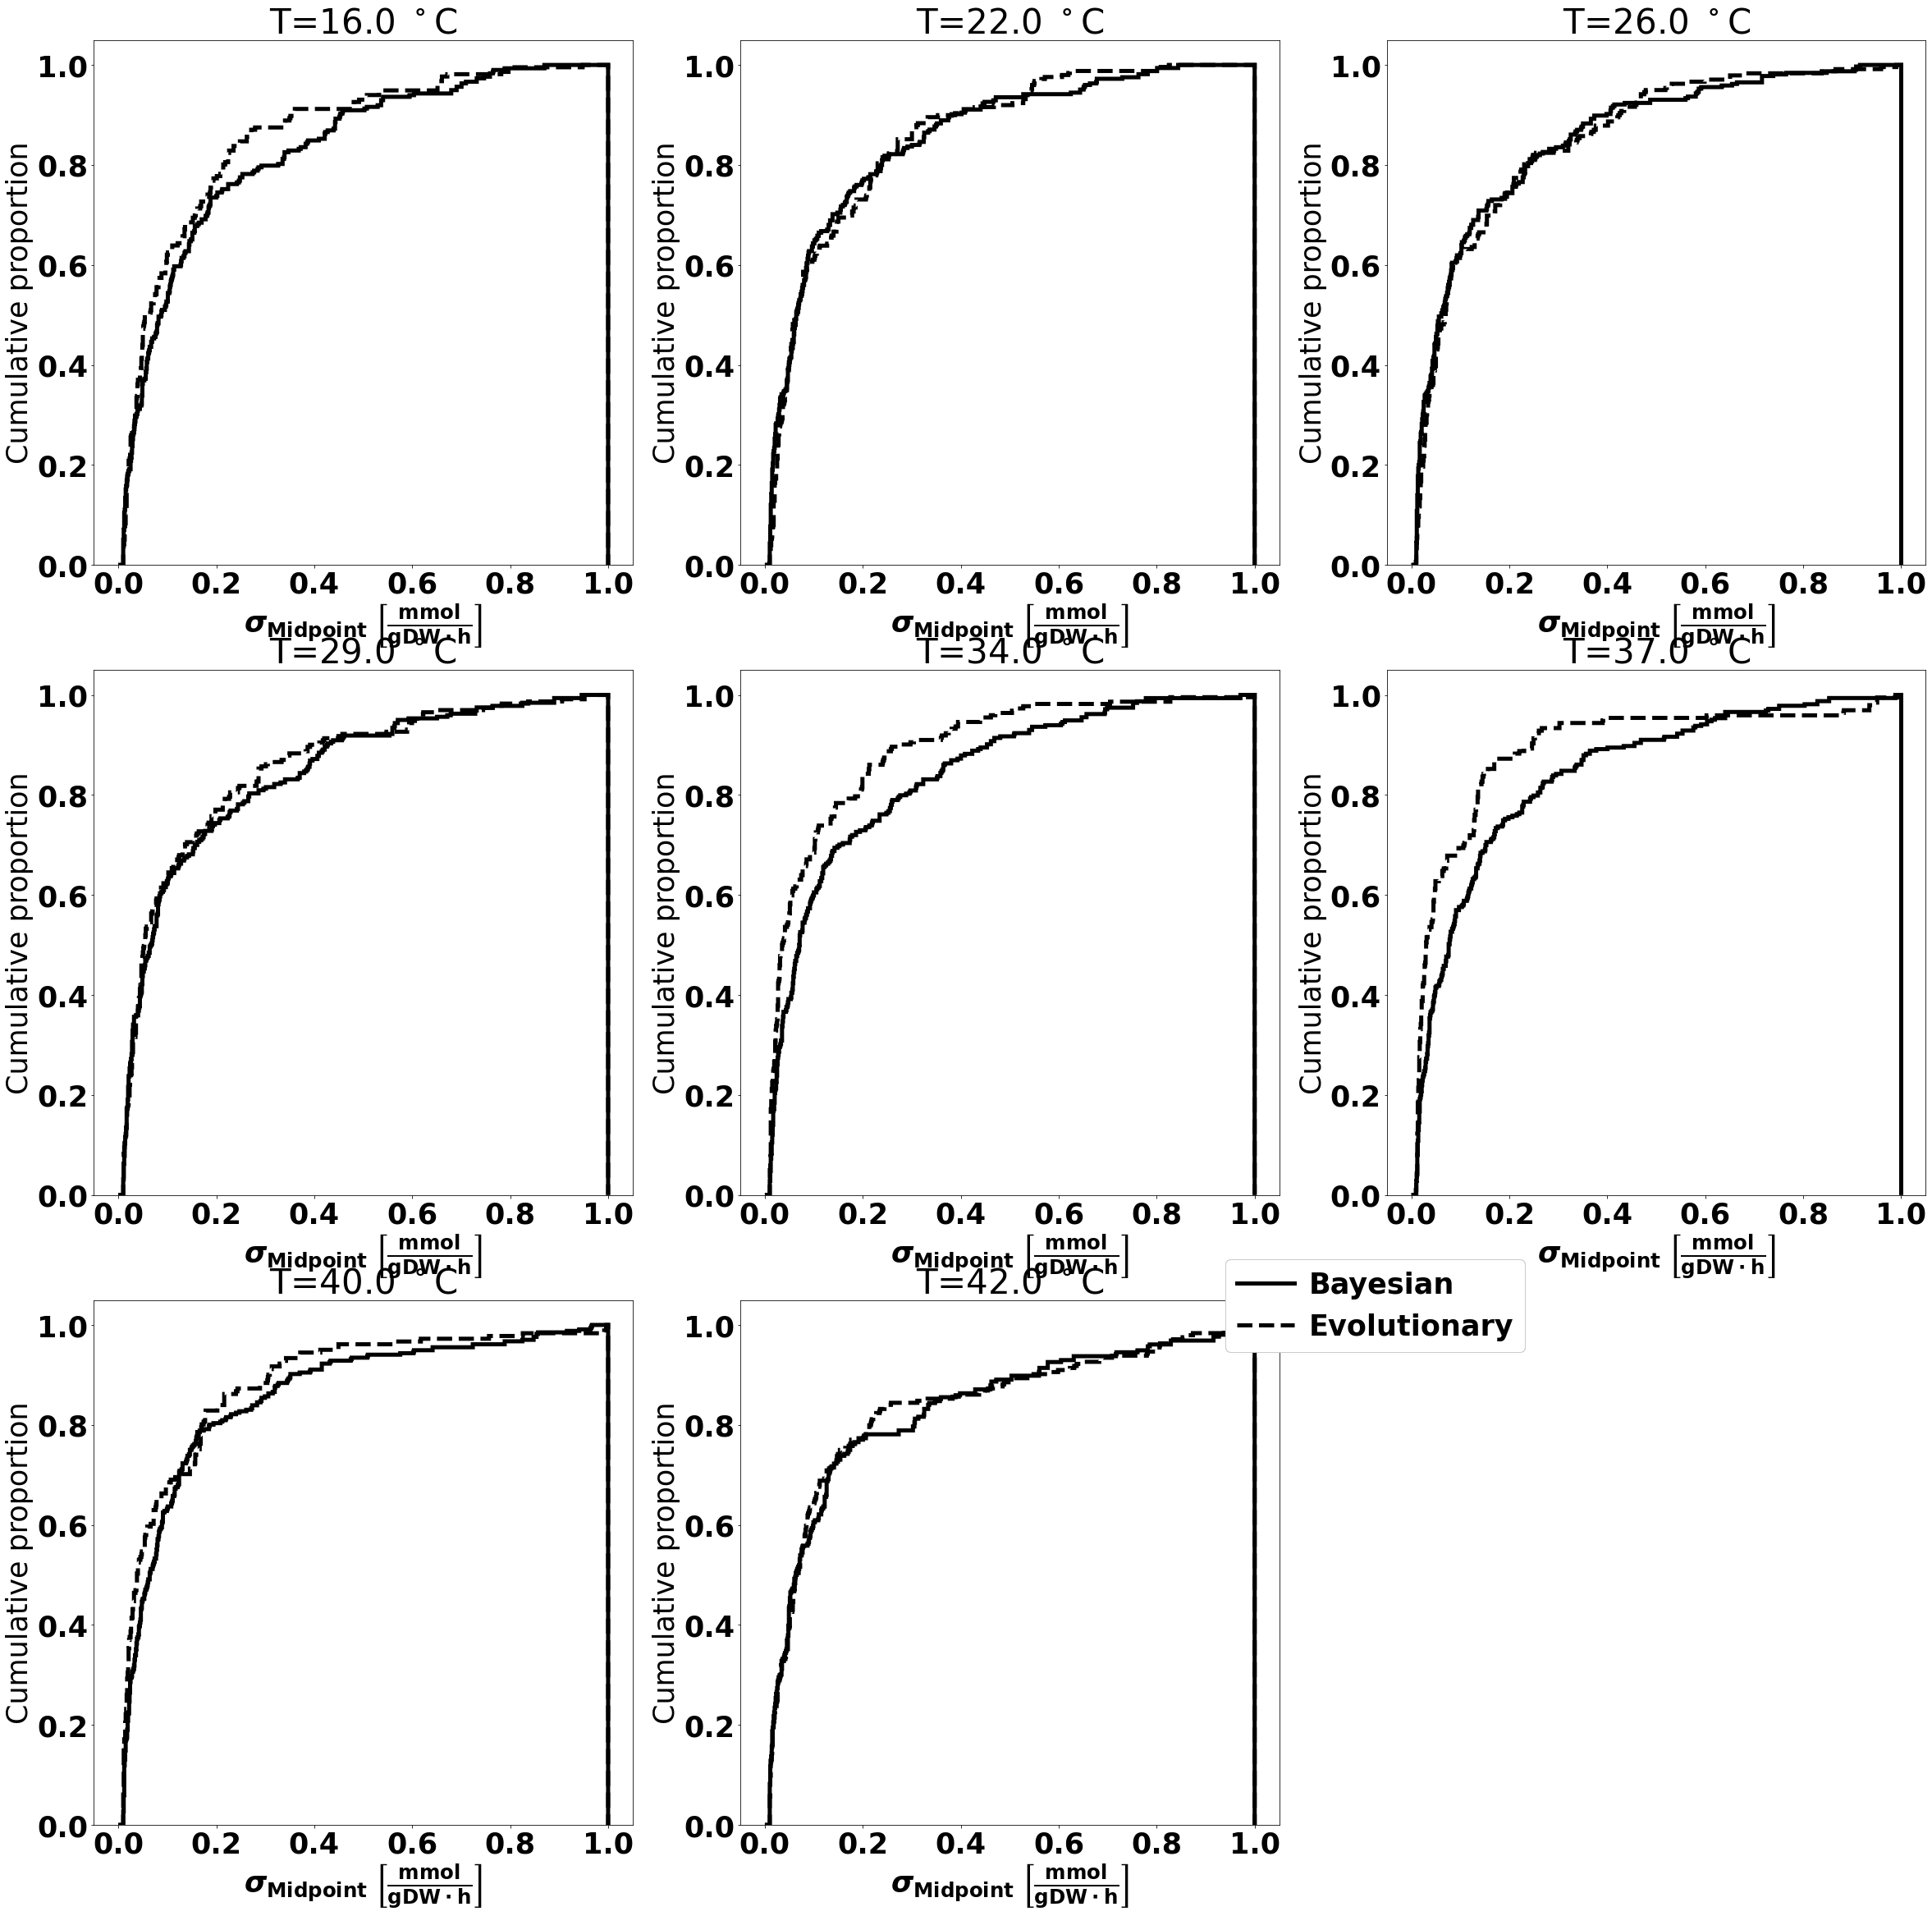

In [65]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),what="midpoint")

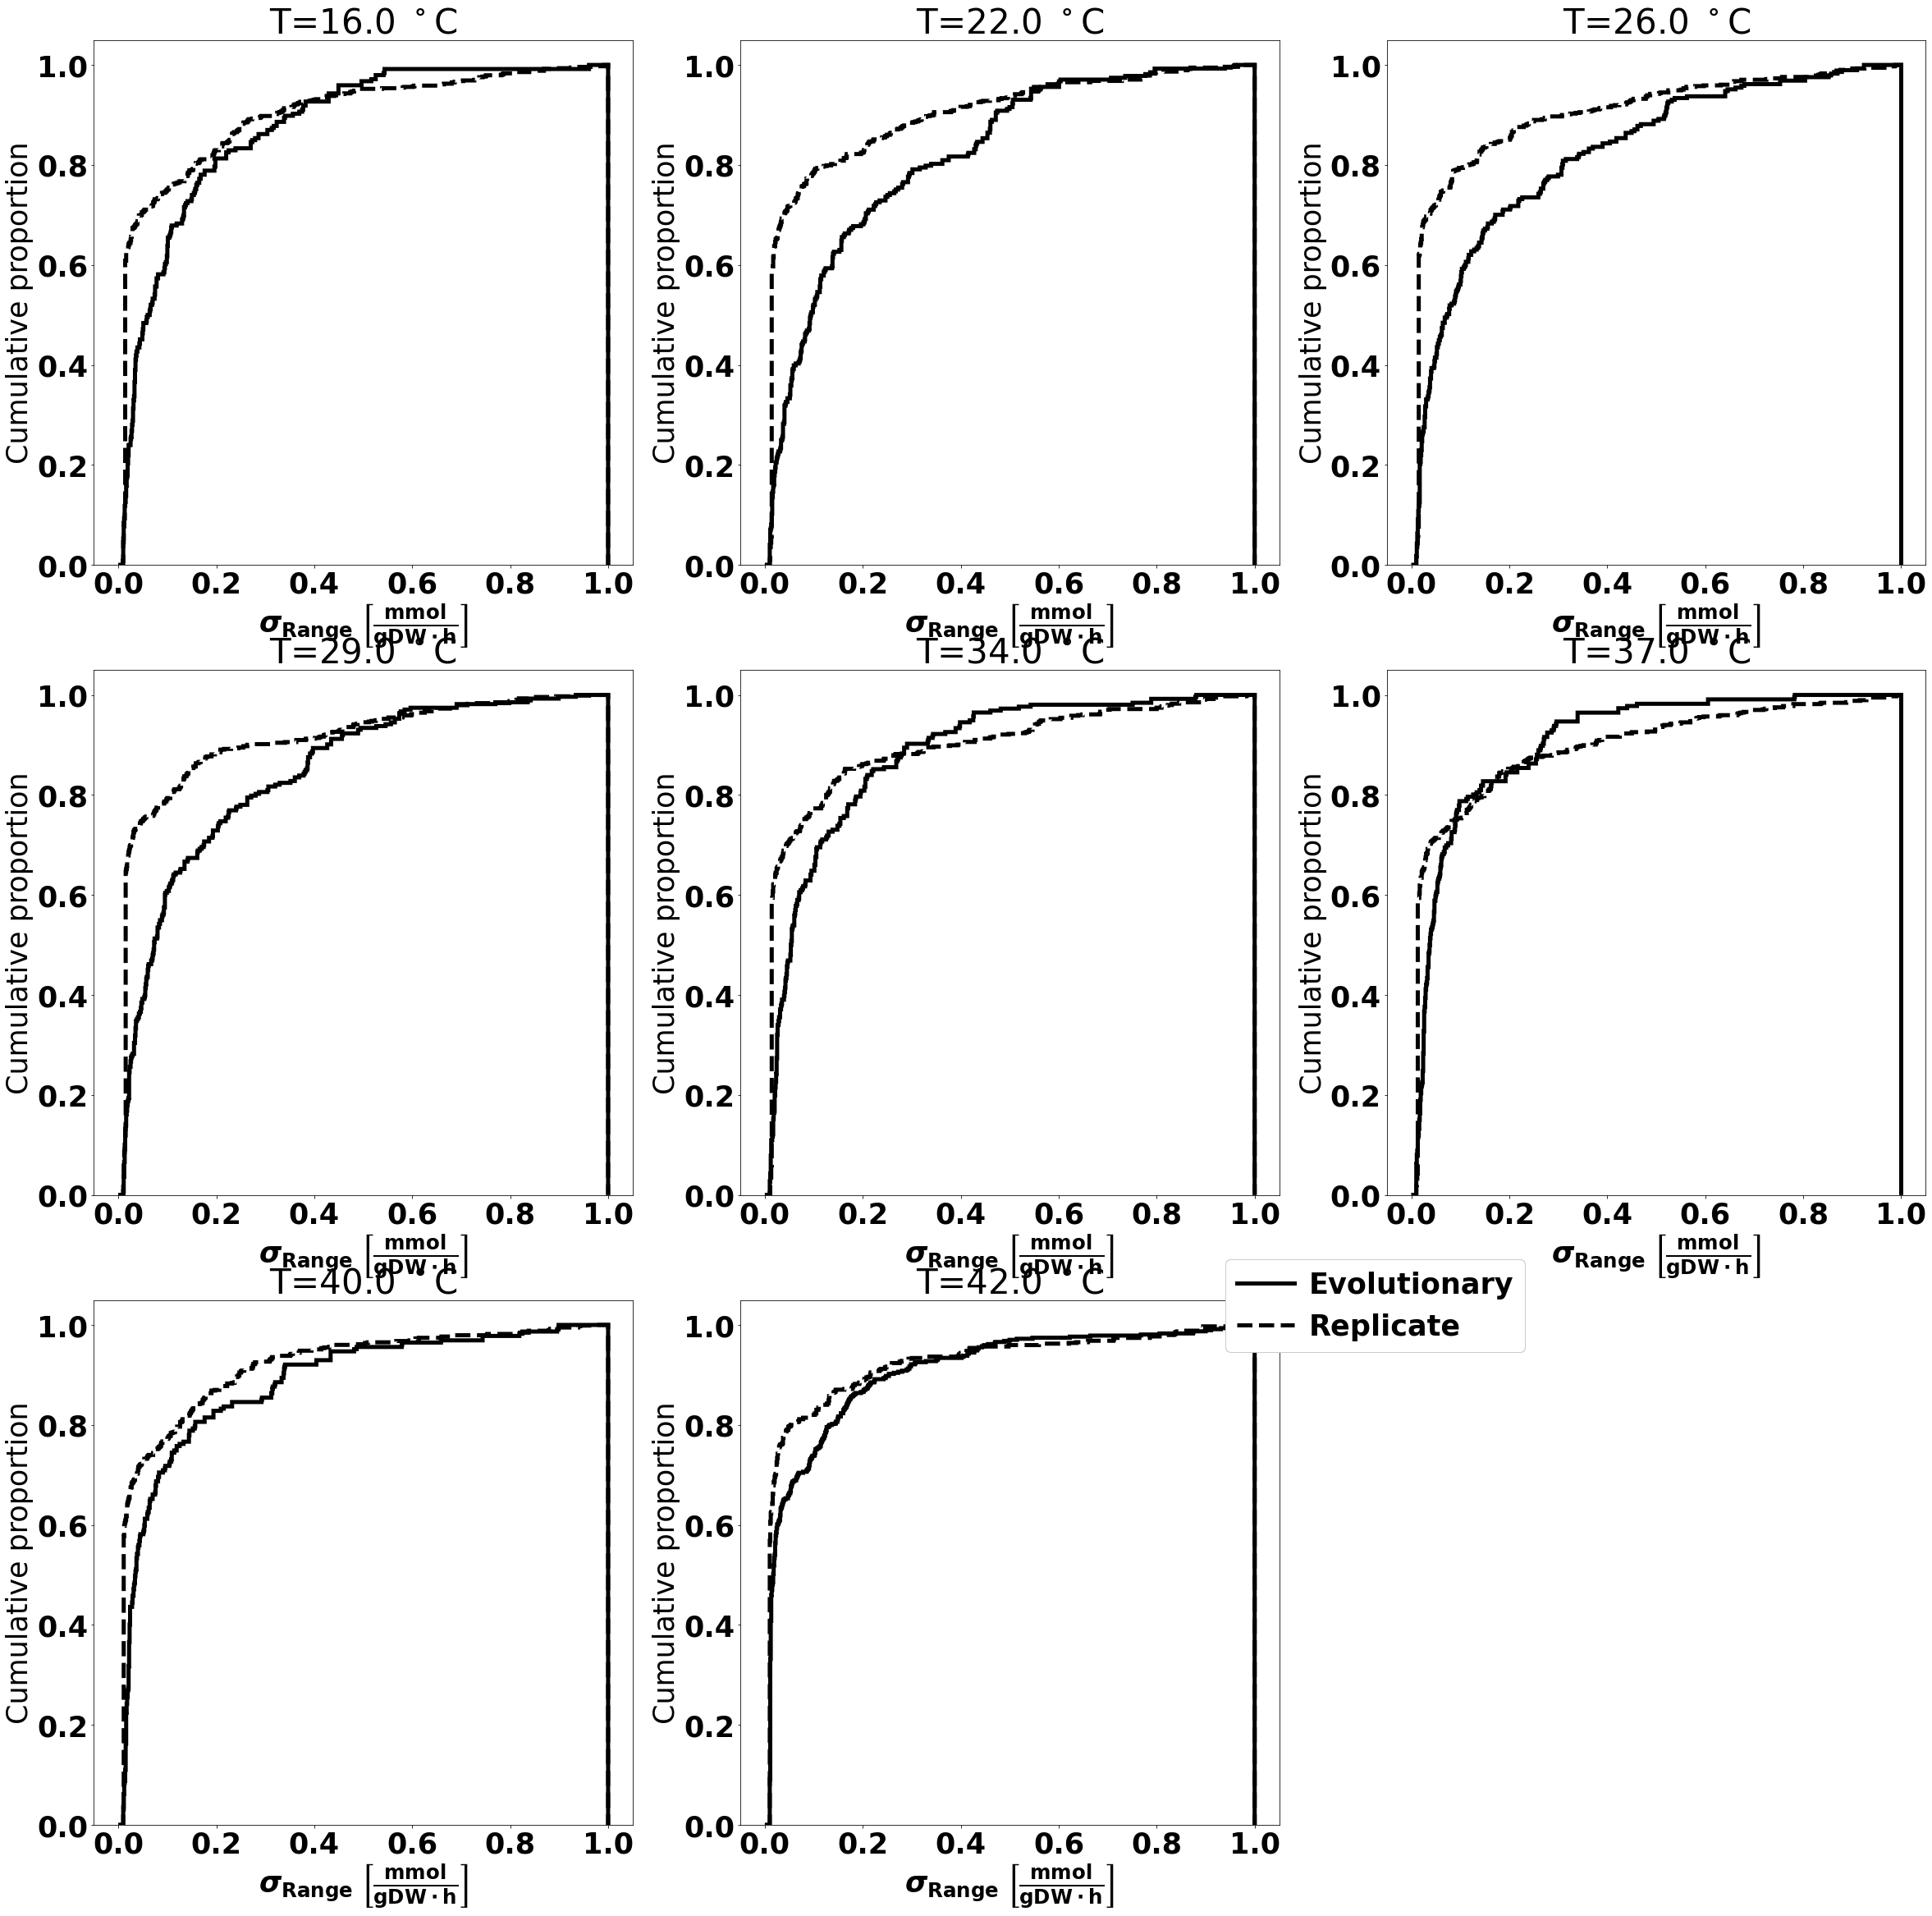

In [66]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("unpermuted","replicate","aerobic")].reset_index(),
                                   label_1="Evolutionary",label_2="Replicate",what="range")

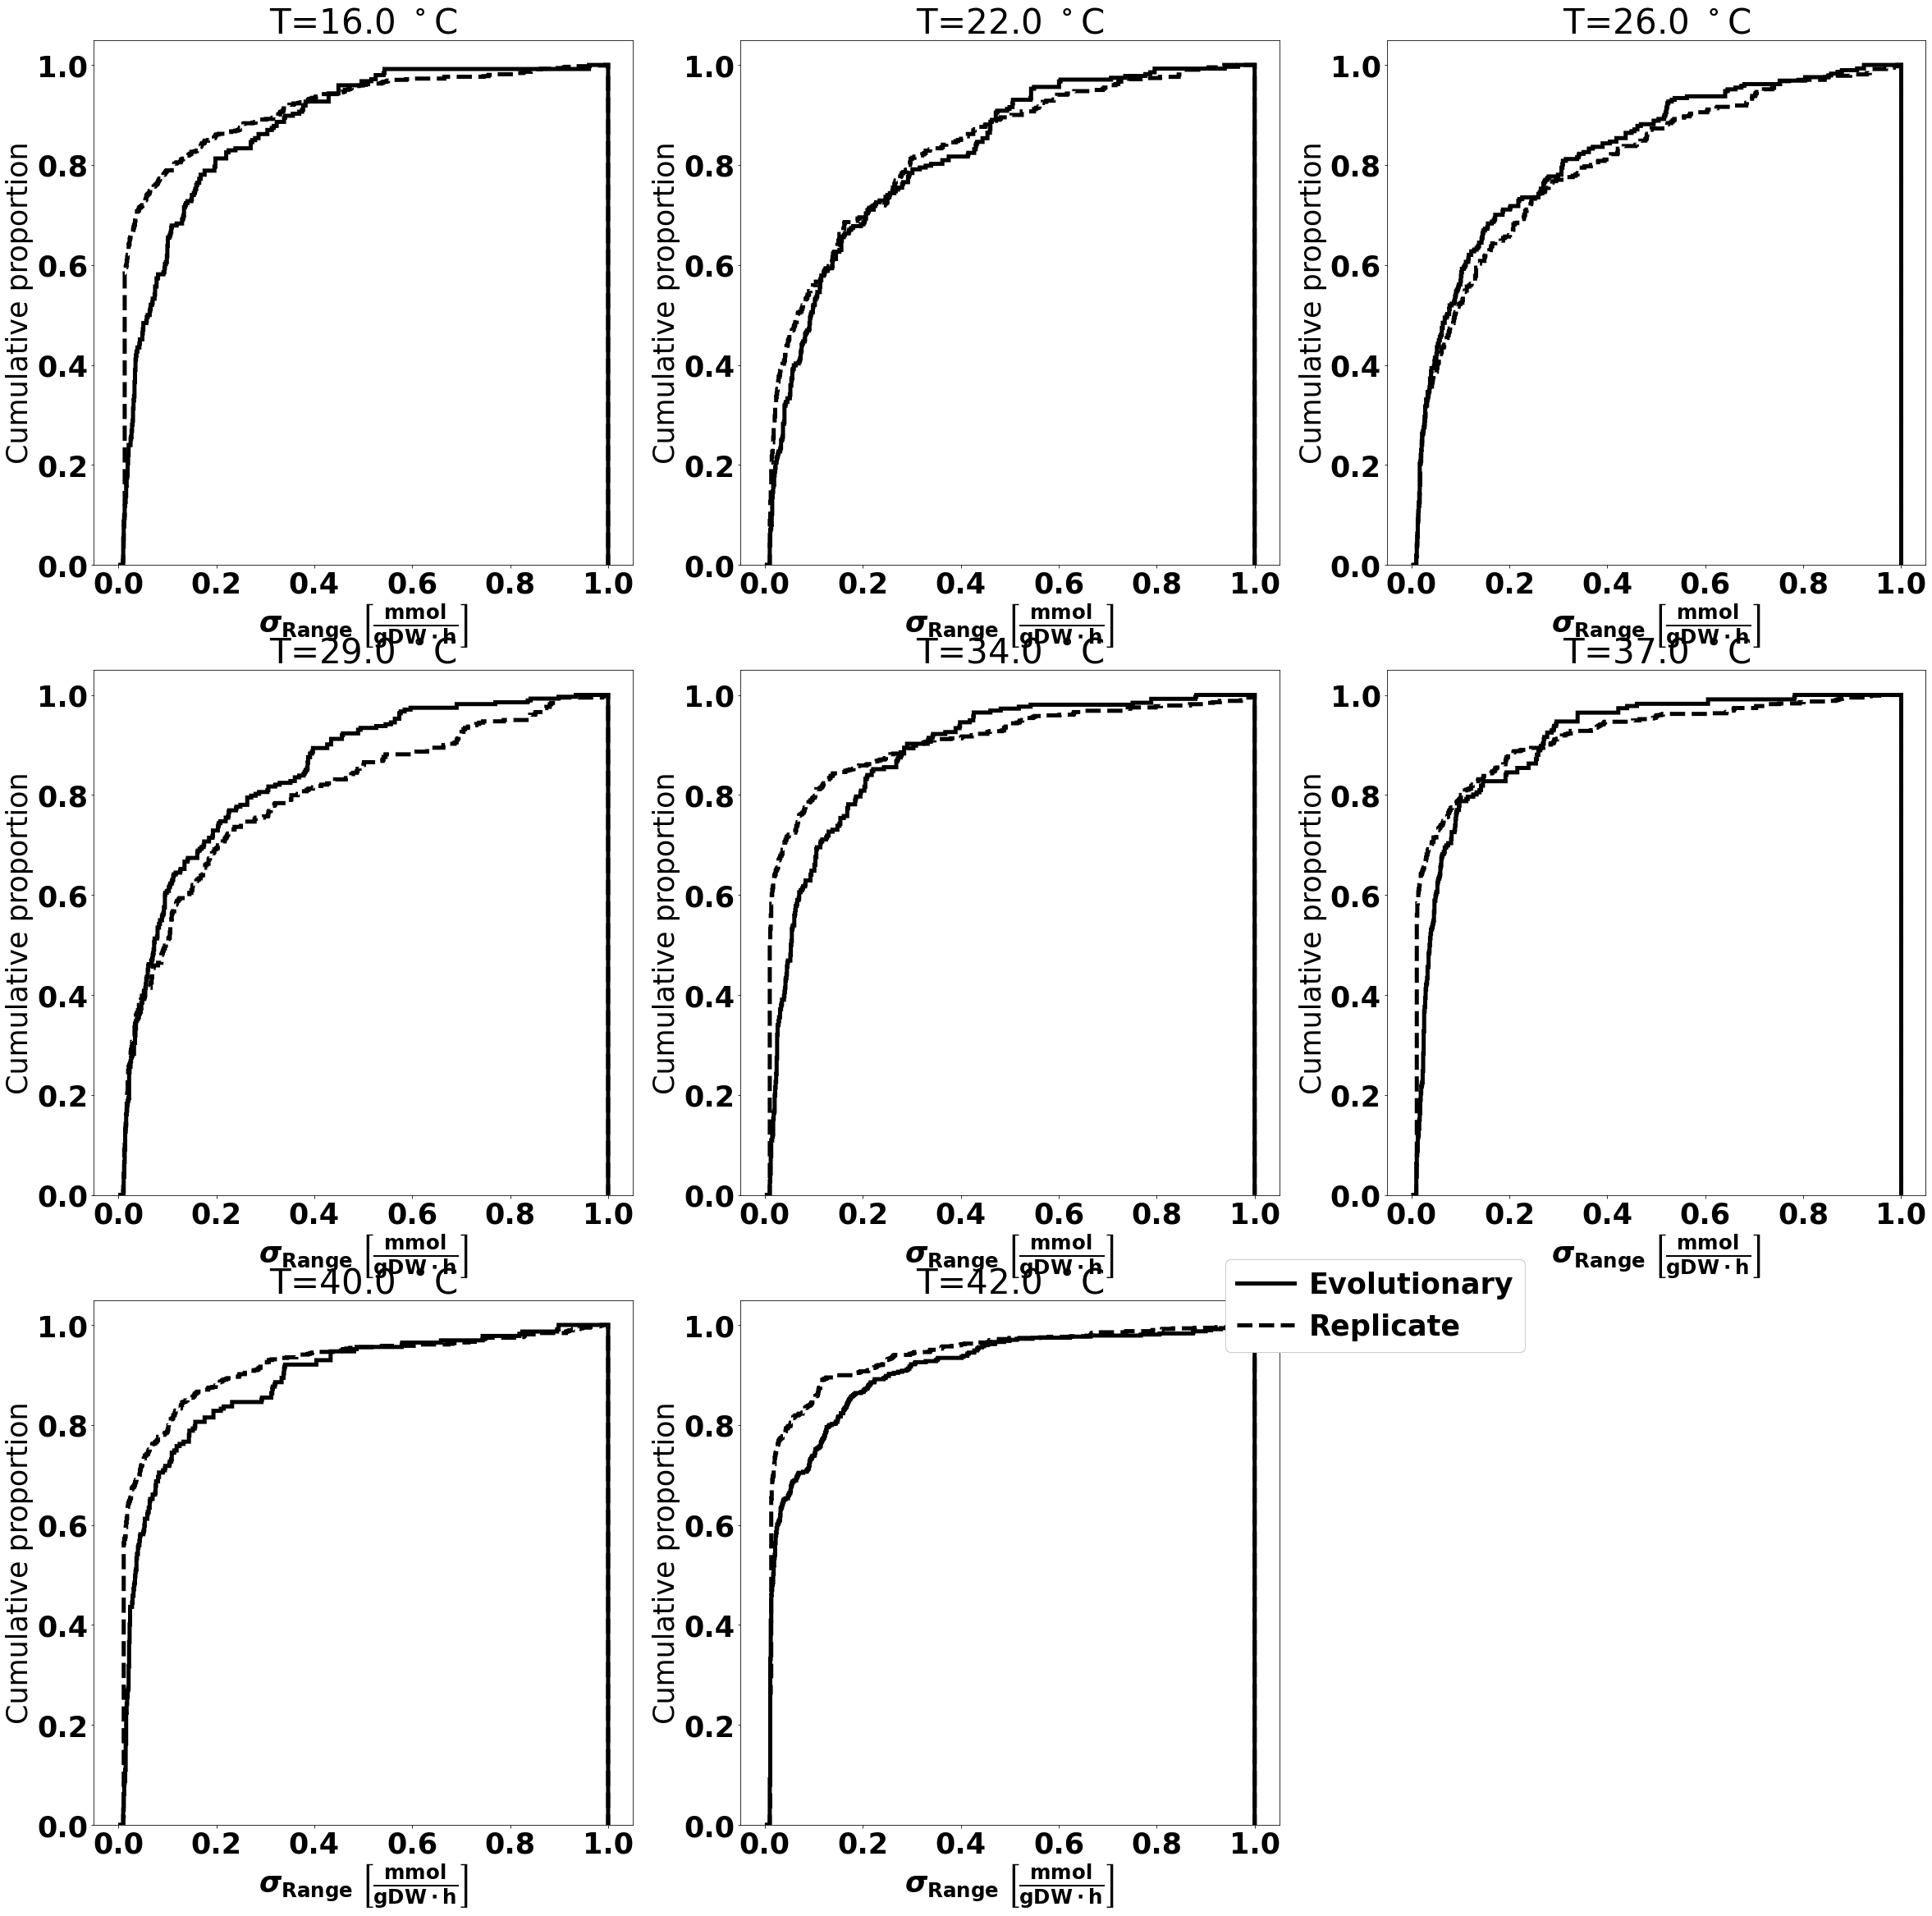

In [67]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("permuted_1","replicate","aerobic")].reset_index(),
                                   label_1="Evolutionary",label_2="Replicate",what="range")

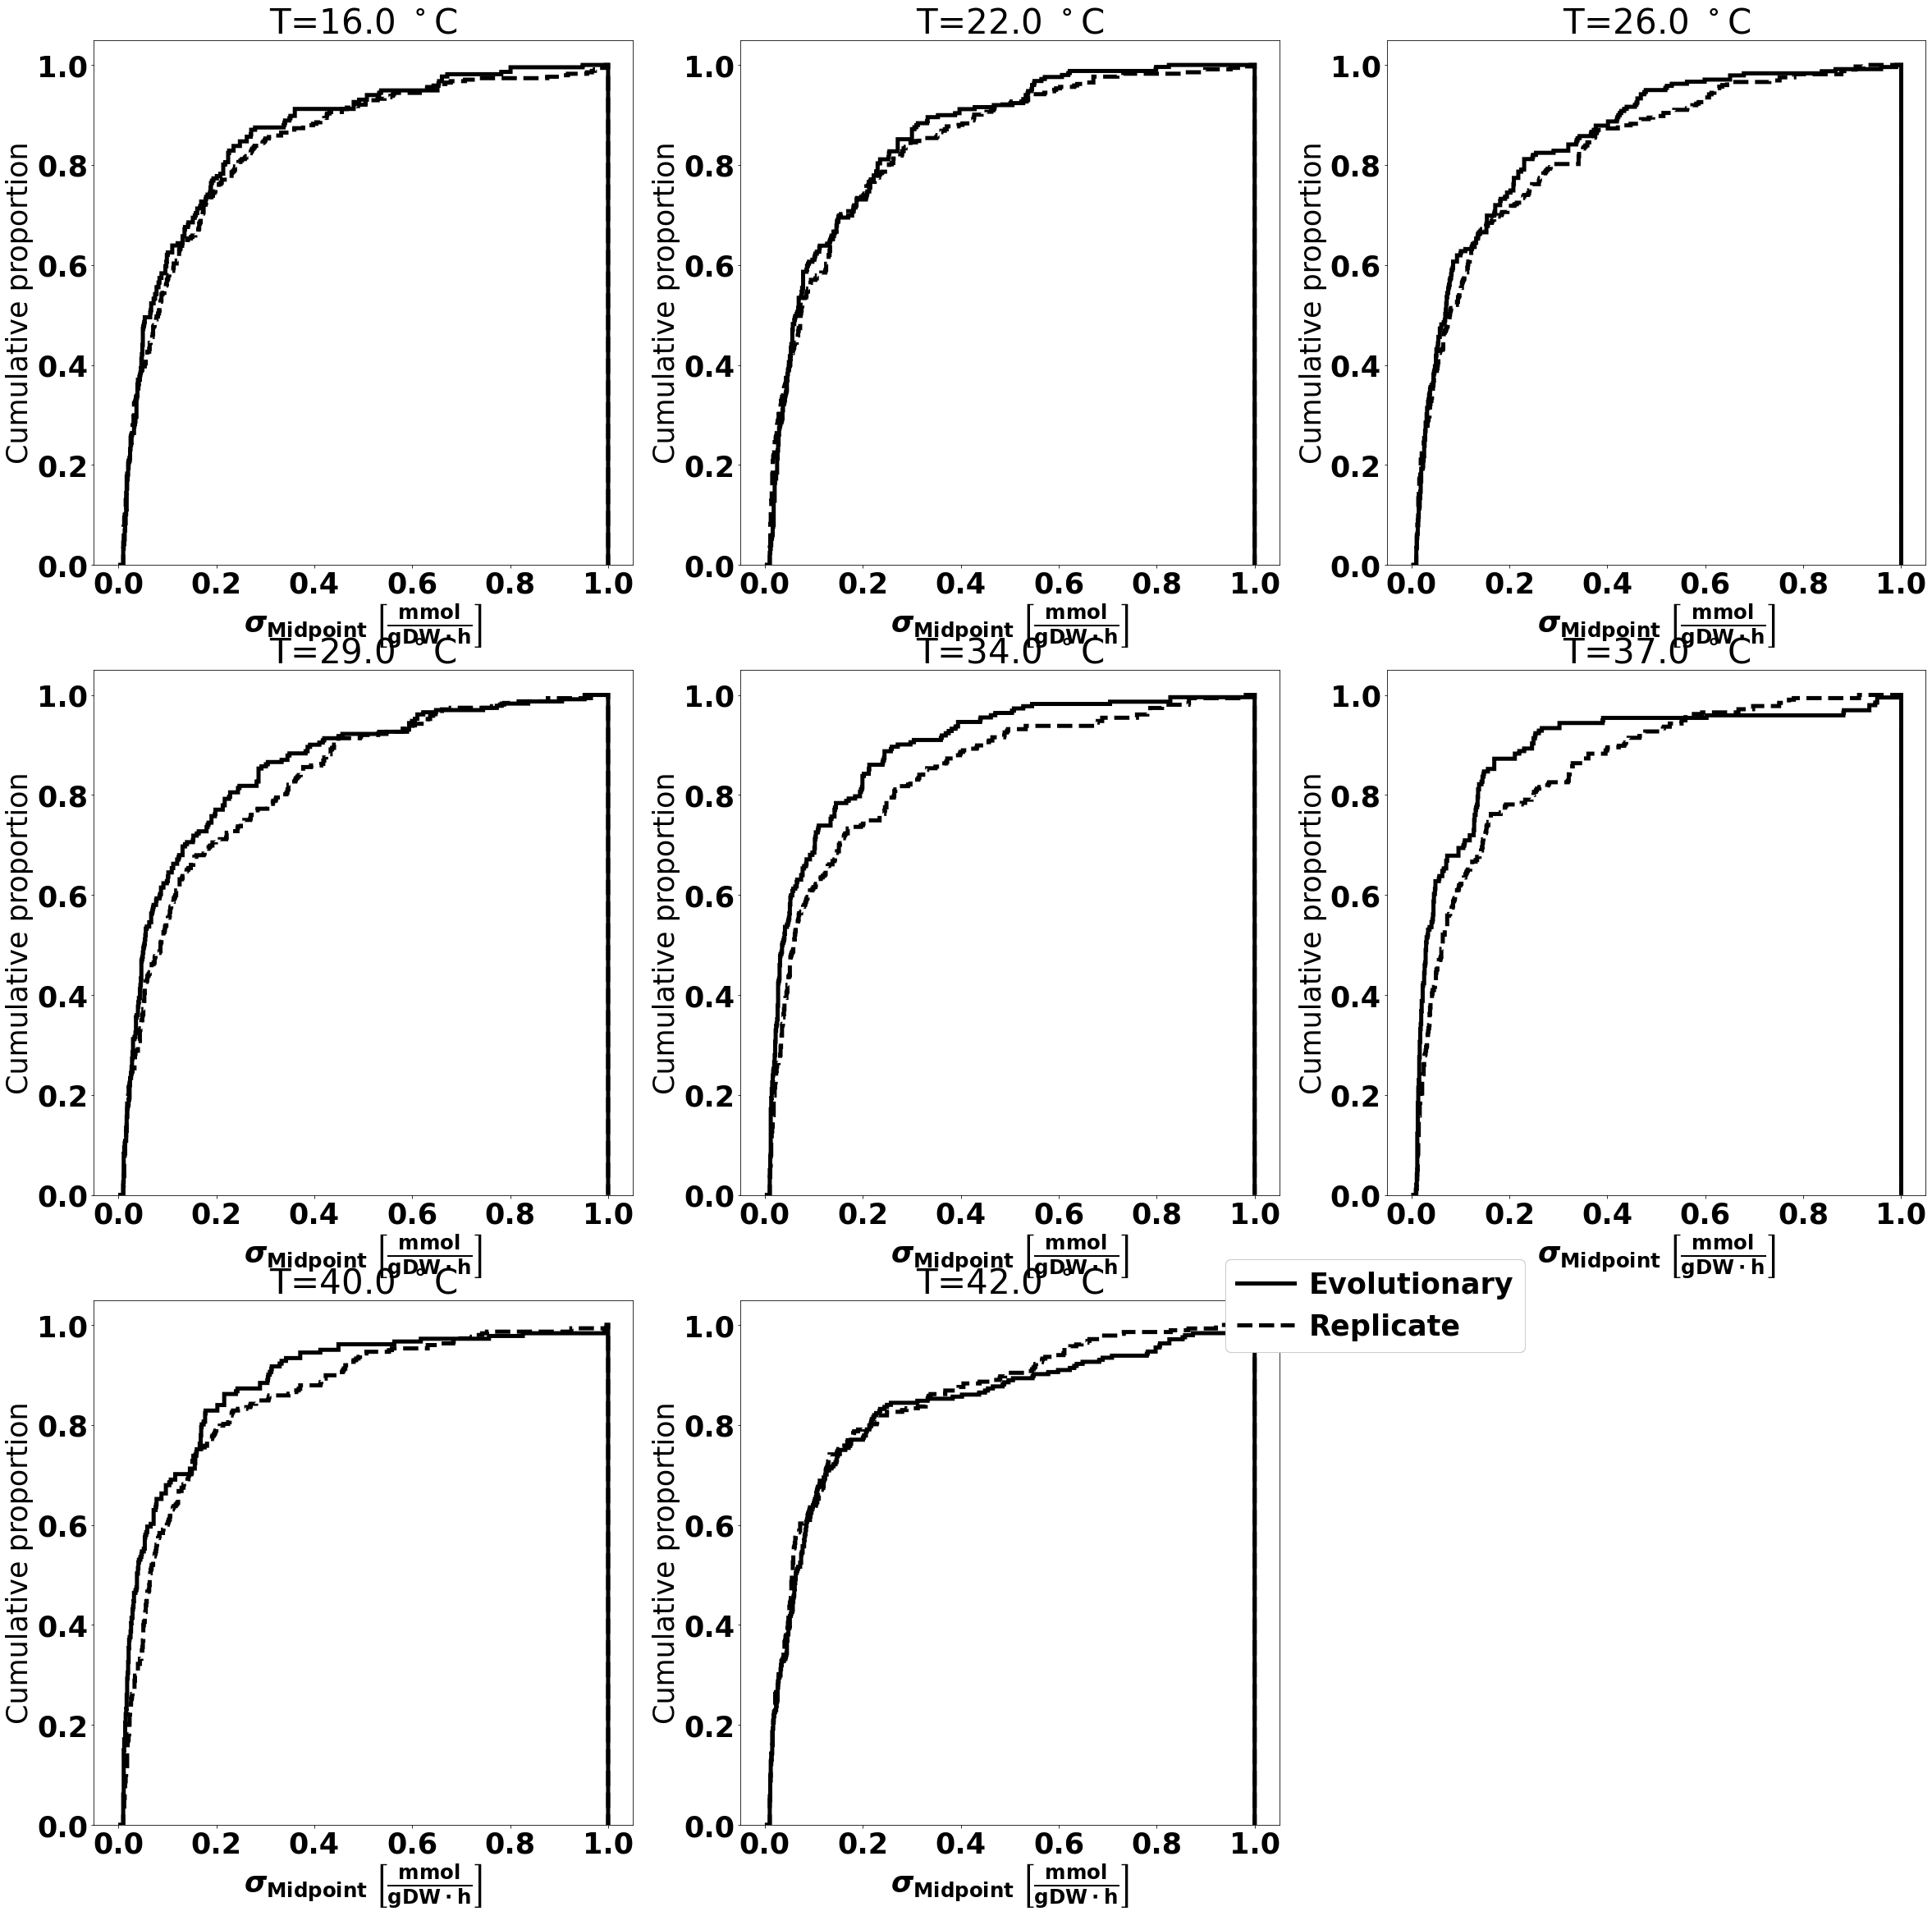

In [68]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("permuted_1","replicate","aerobic")].reset_index(),
                                   label_1="Evolutionary",label_2="Replicate",what="midpoint")

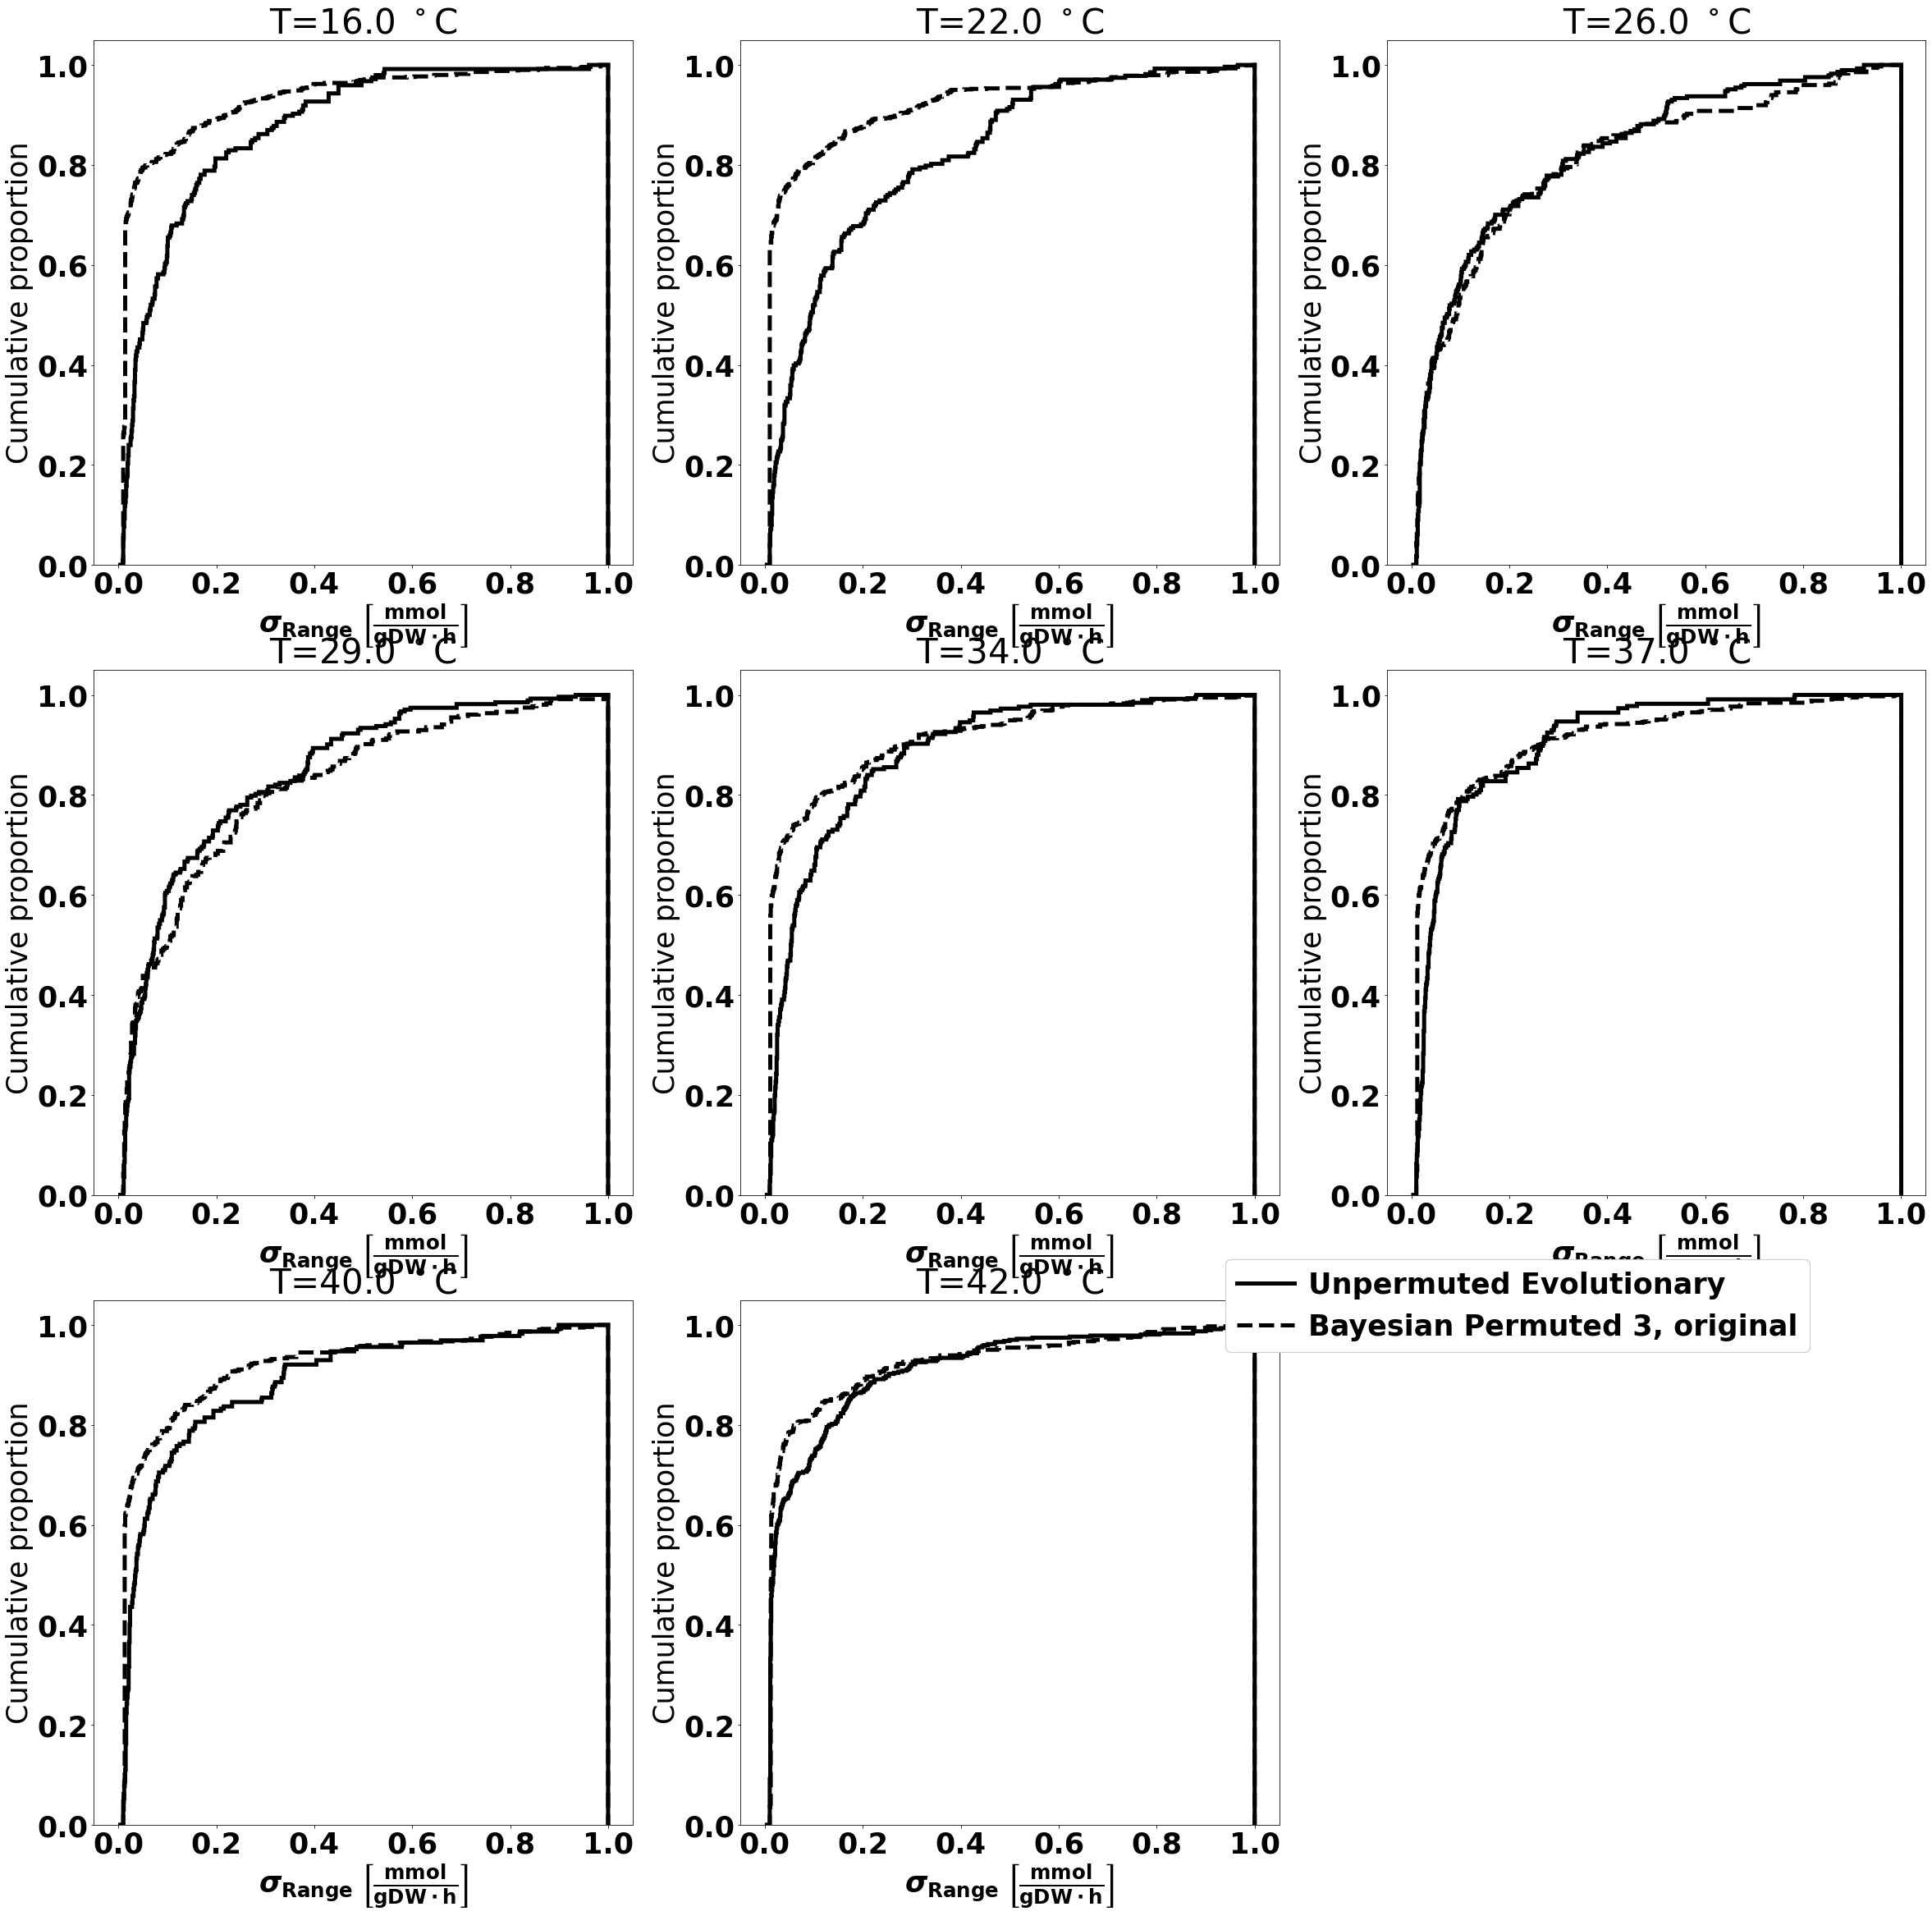

In [69]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("permuted_2","original","aerobic")].reset_index(),
                                   label_1="Unpermuted Evolutionary",label_2="Bayesian Permuted 3, original",what="range")
plt.savefig("../figures/range_permuted_2.pdf")

/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


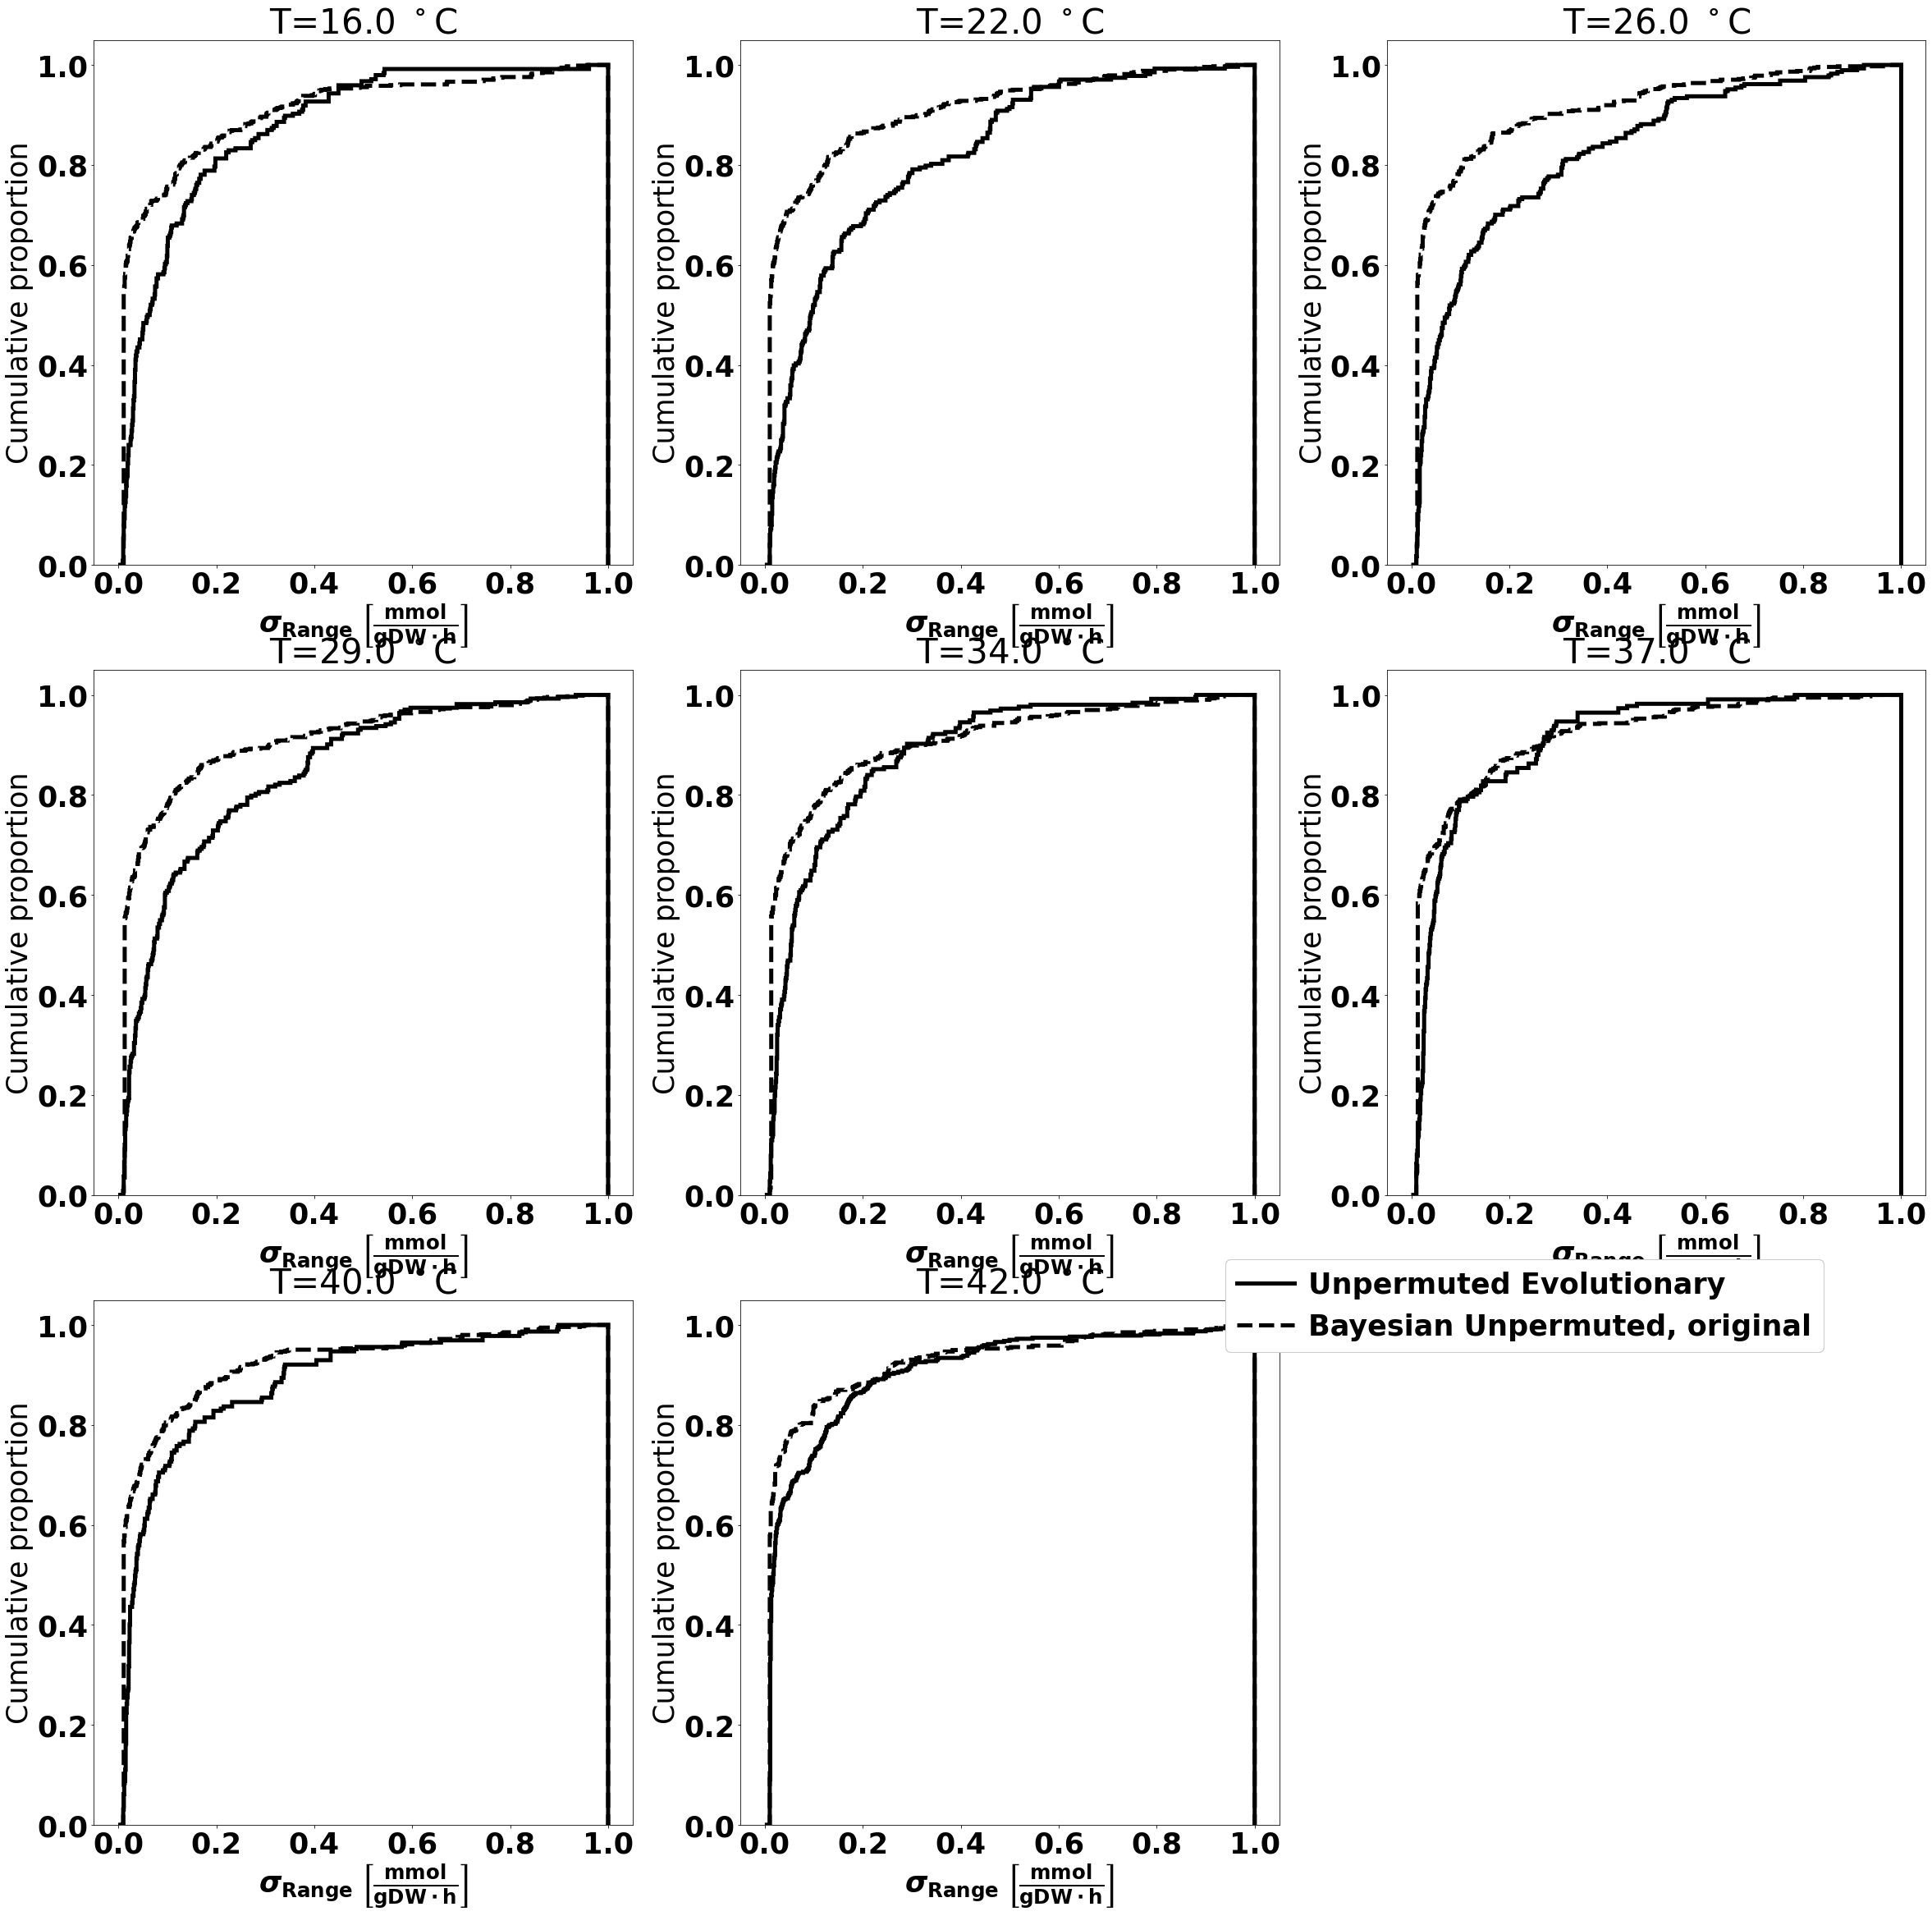

In [70]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index(),
                                   label_1="Unpermuted Evolutionary",label_2="Bayesian Unpermuted, original",what="range")
plt.savefig("../figures/range_unpermuted.pdf")

/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


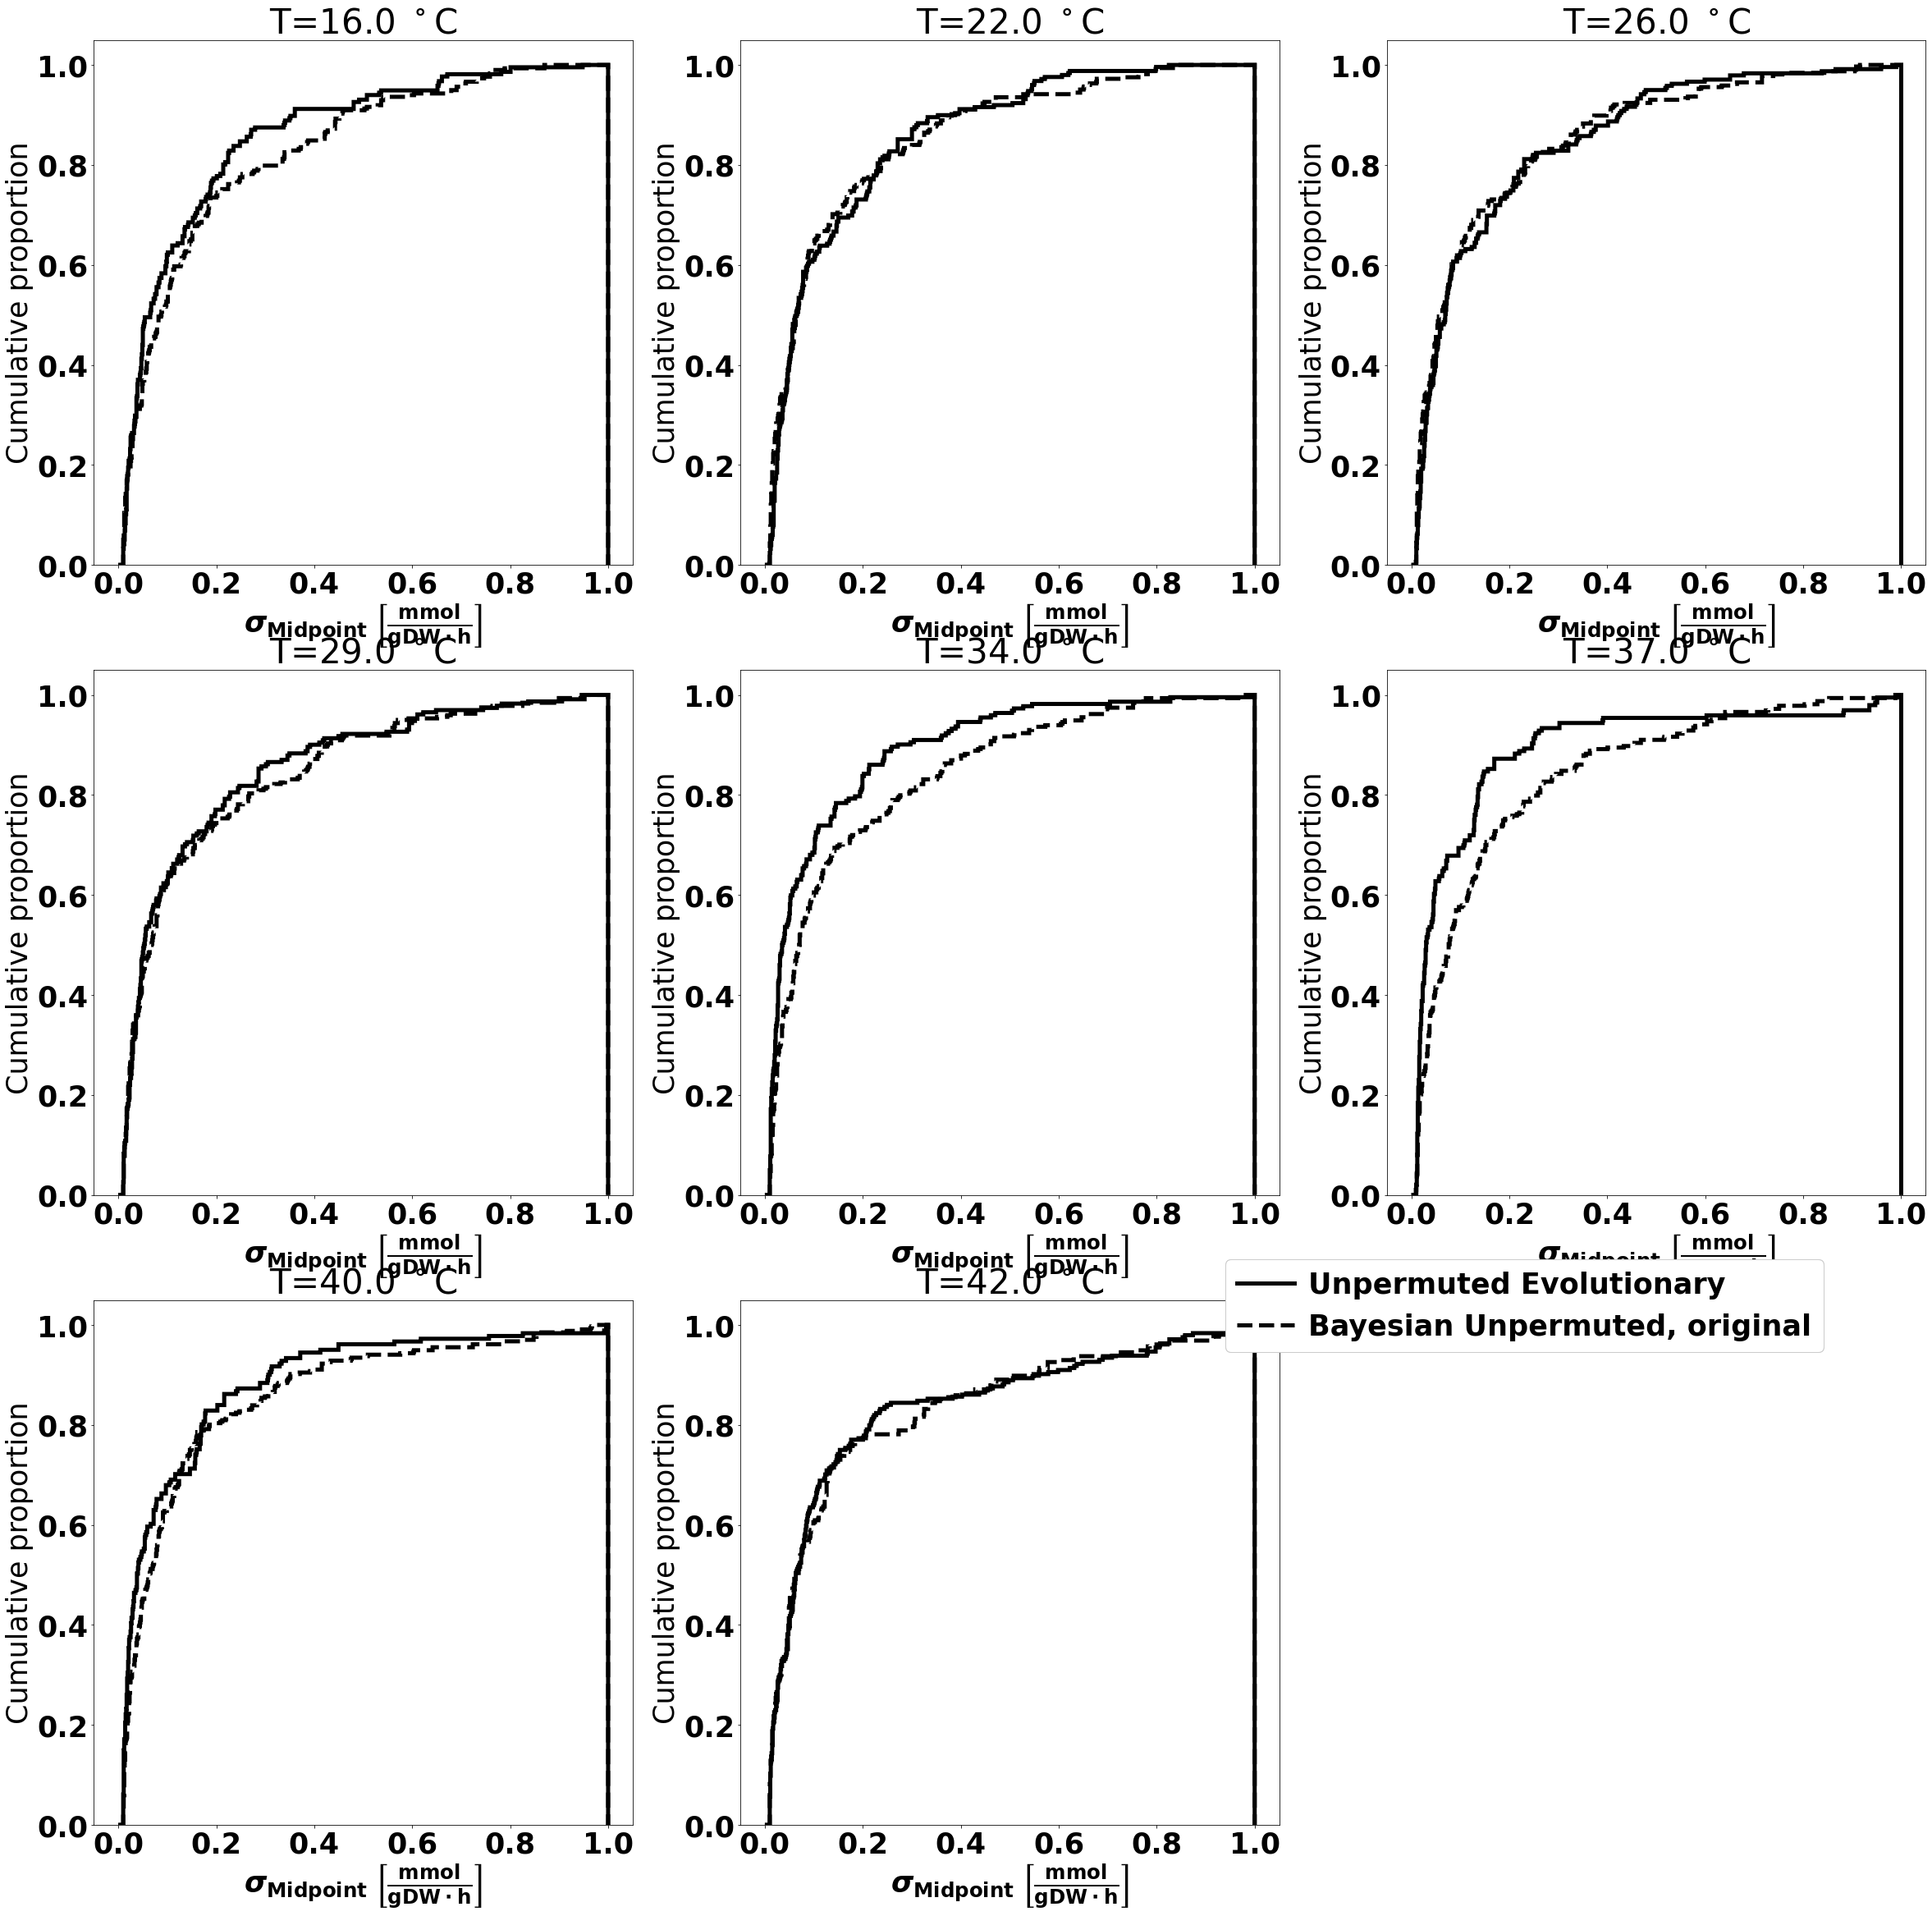

In [71]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index(),
                                   label_1="Unpermuted Evolutionary",label_2="Bayesian Unpermuted, original",what="midpoint")
plt.savefig("../figures/midpoint_unpermuted.pdf")

/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


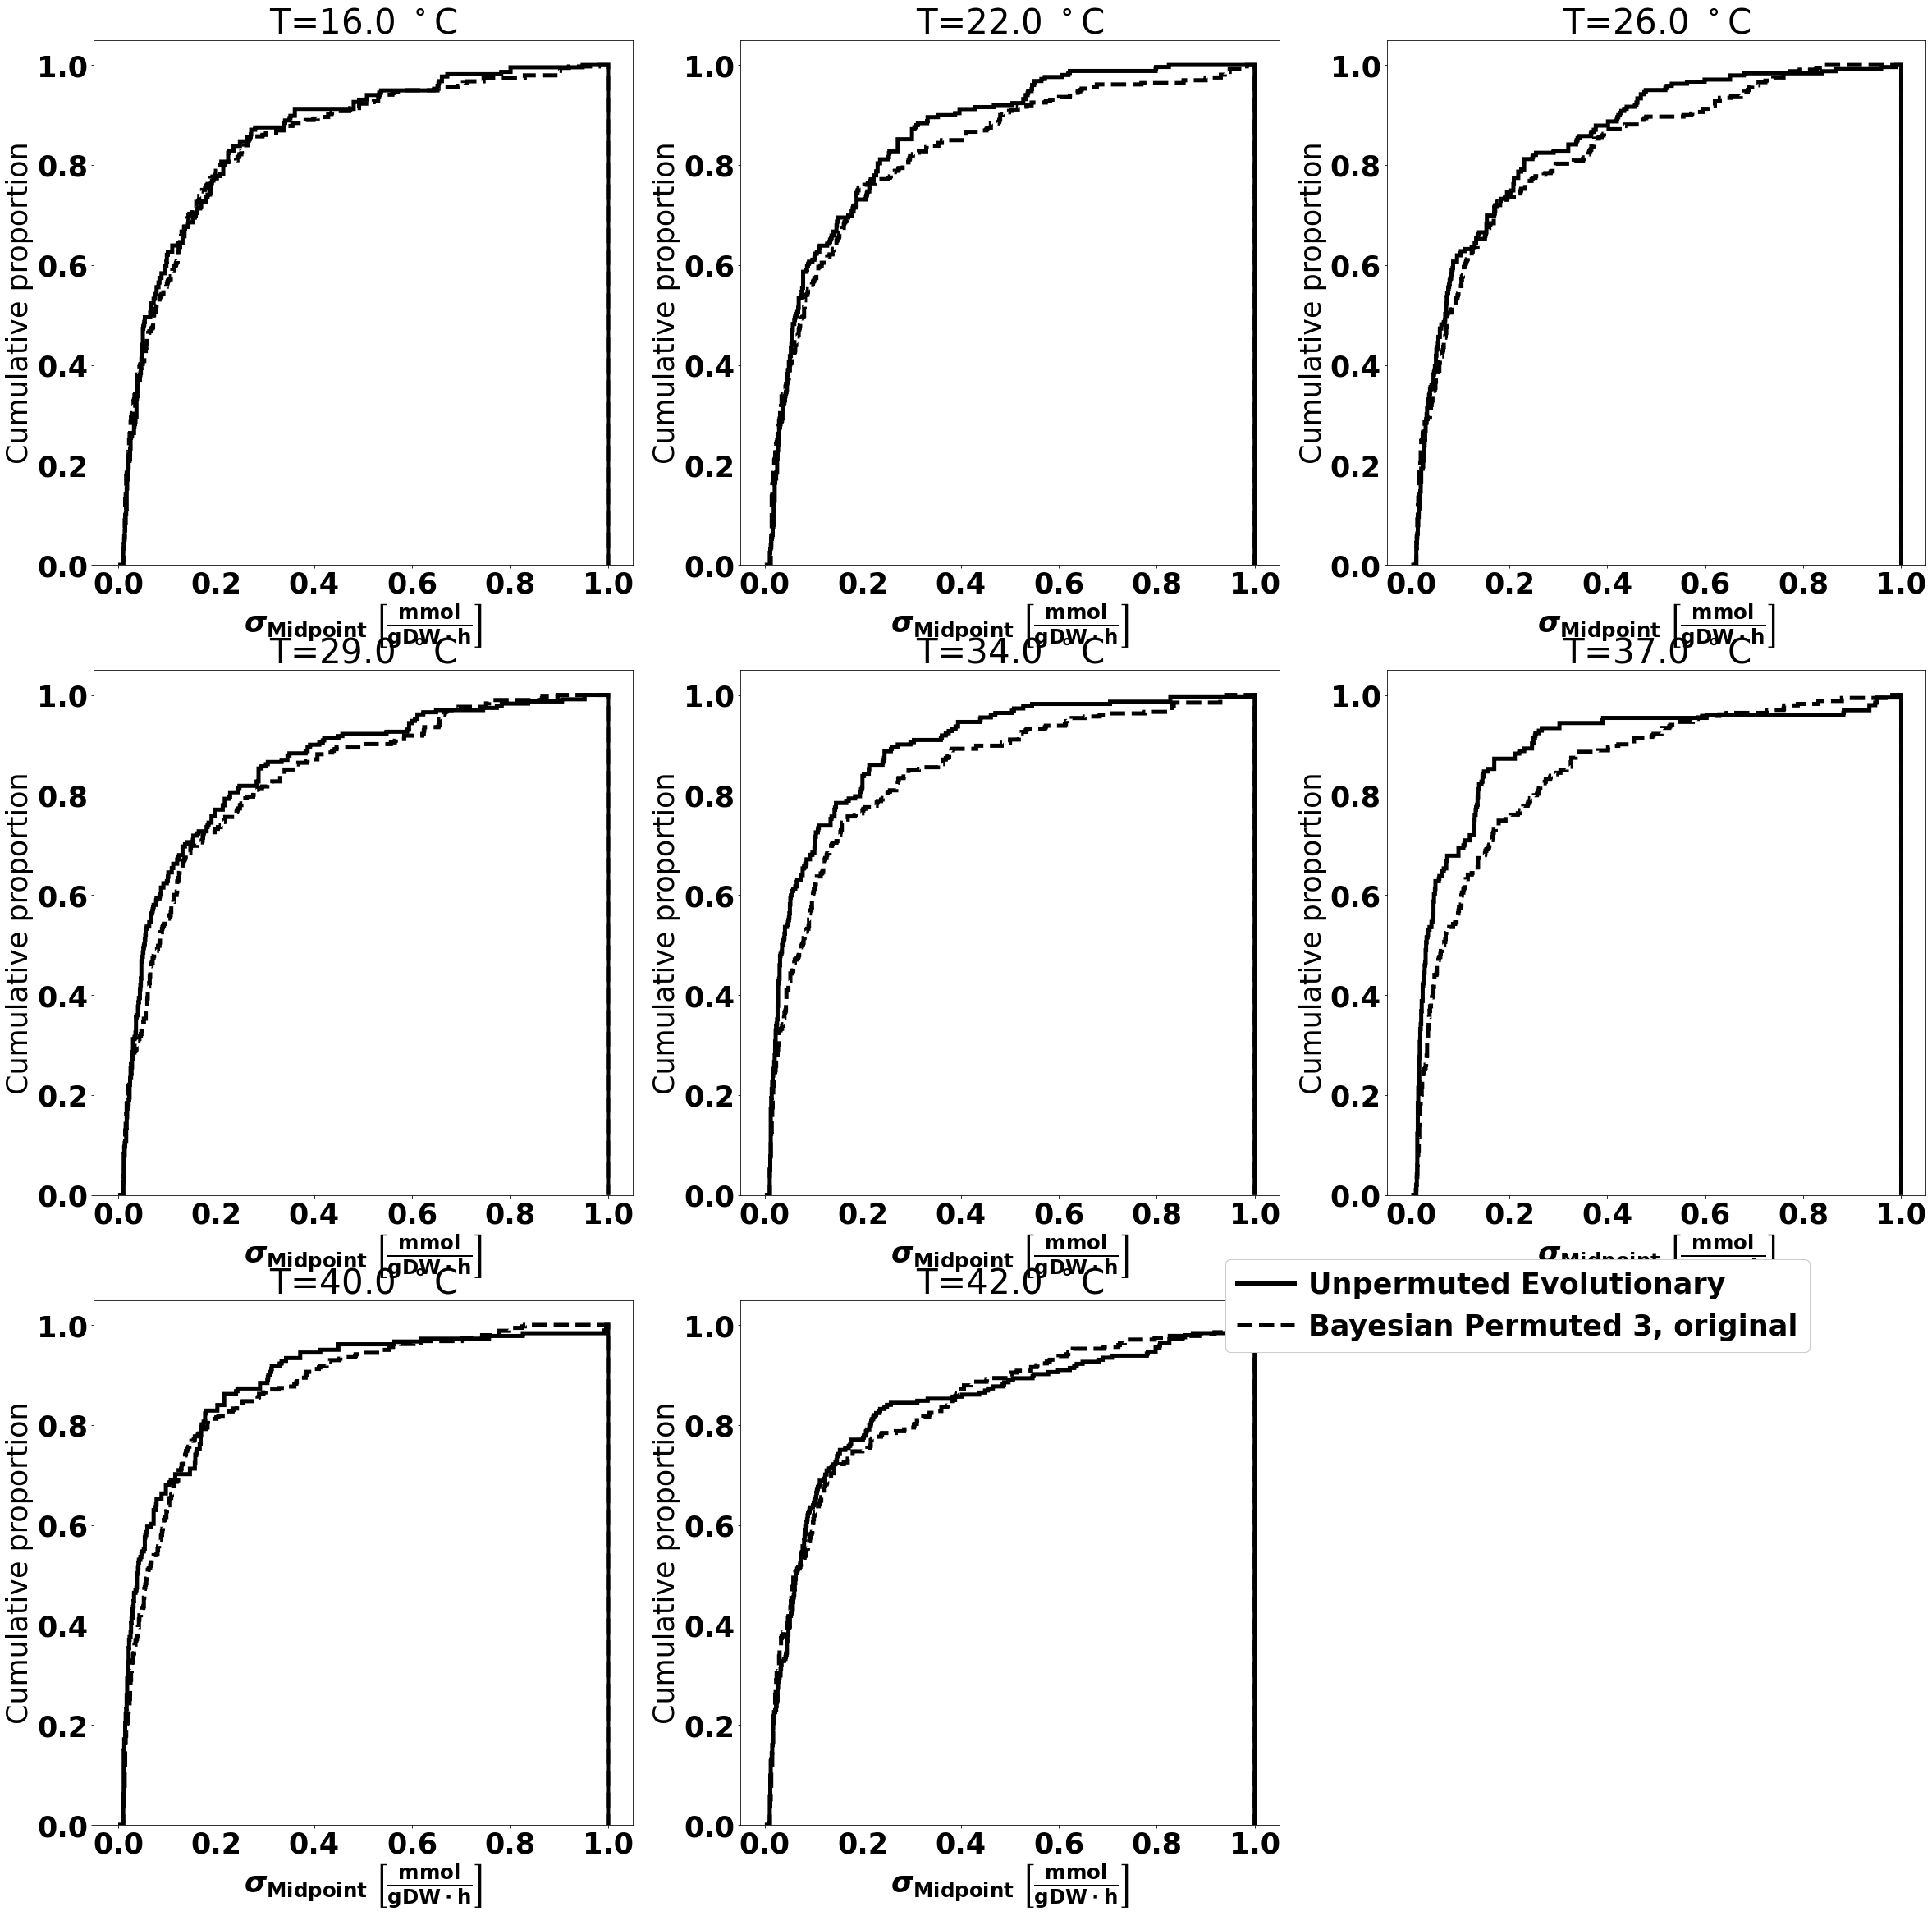

In [72]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("permuted_2","original","aerobic")].reset_index(),
                                   label_1="Unpermuted Evolutionary",label_2="Bayesian Permuted 3, original",what="midpoint")
plt.savefig("../figures/midpoint_permuted_2.pdf")

/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


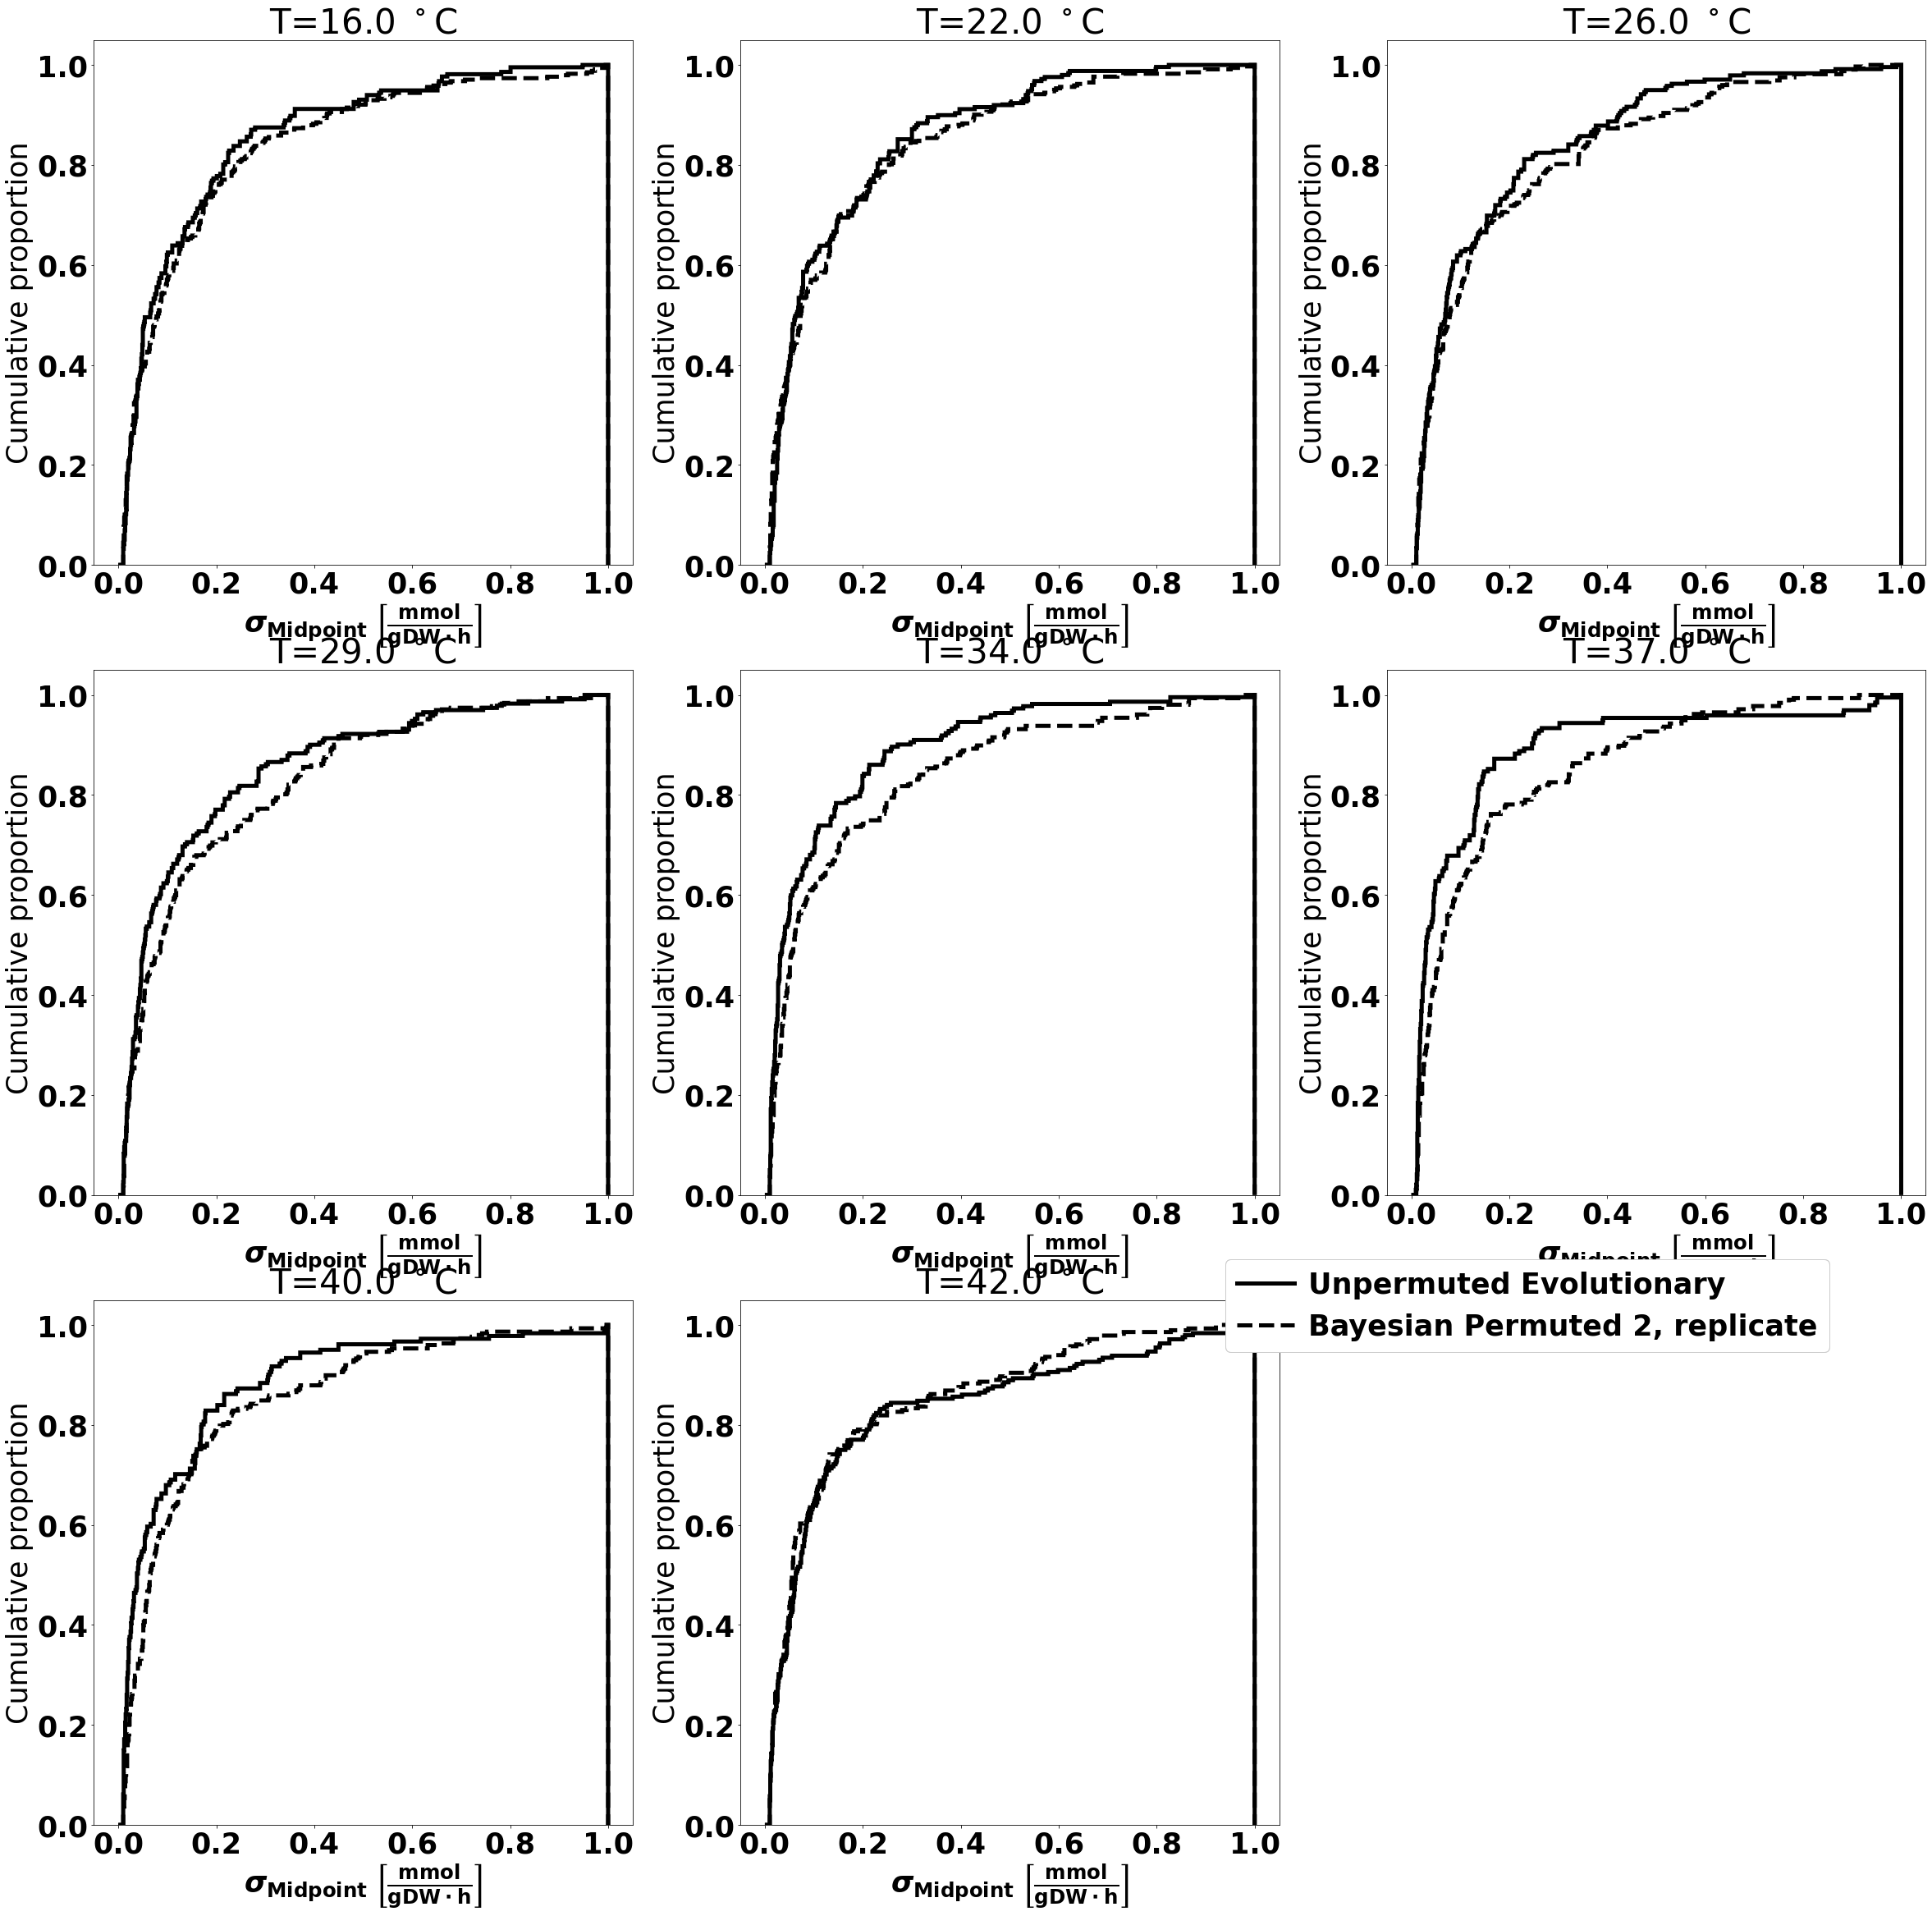

In [73]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("permuted_1","replicate","aerobic")].reset_index(),
                                   label_1="Unpermuted Evolutionary",label_2="Bayesian Permuted 2, replicate",what="midpoint")

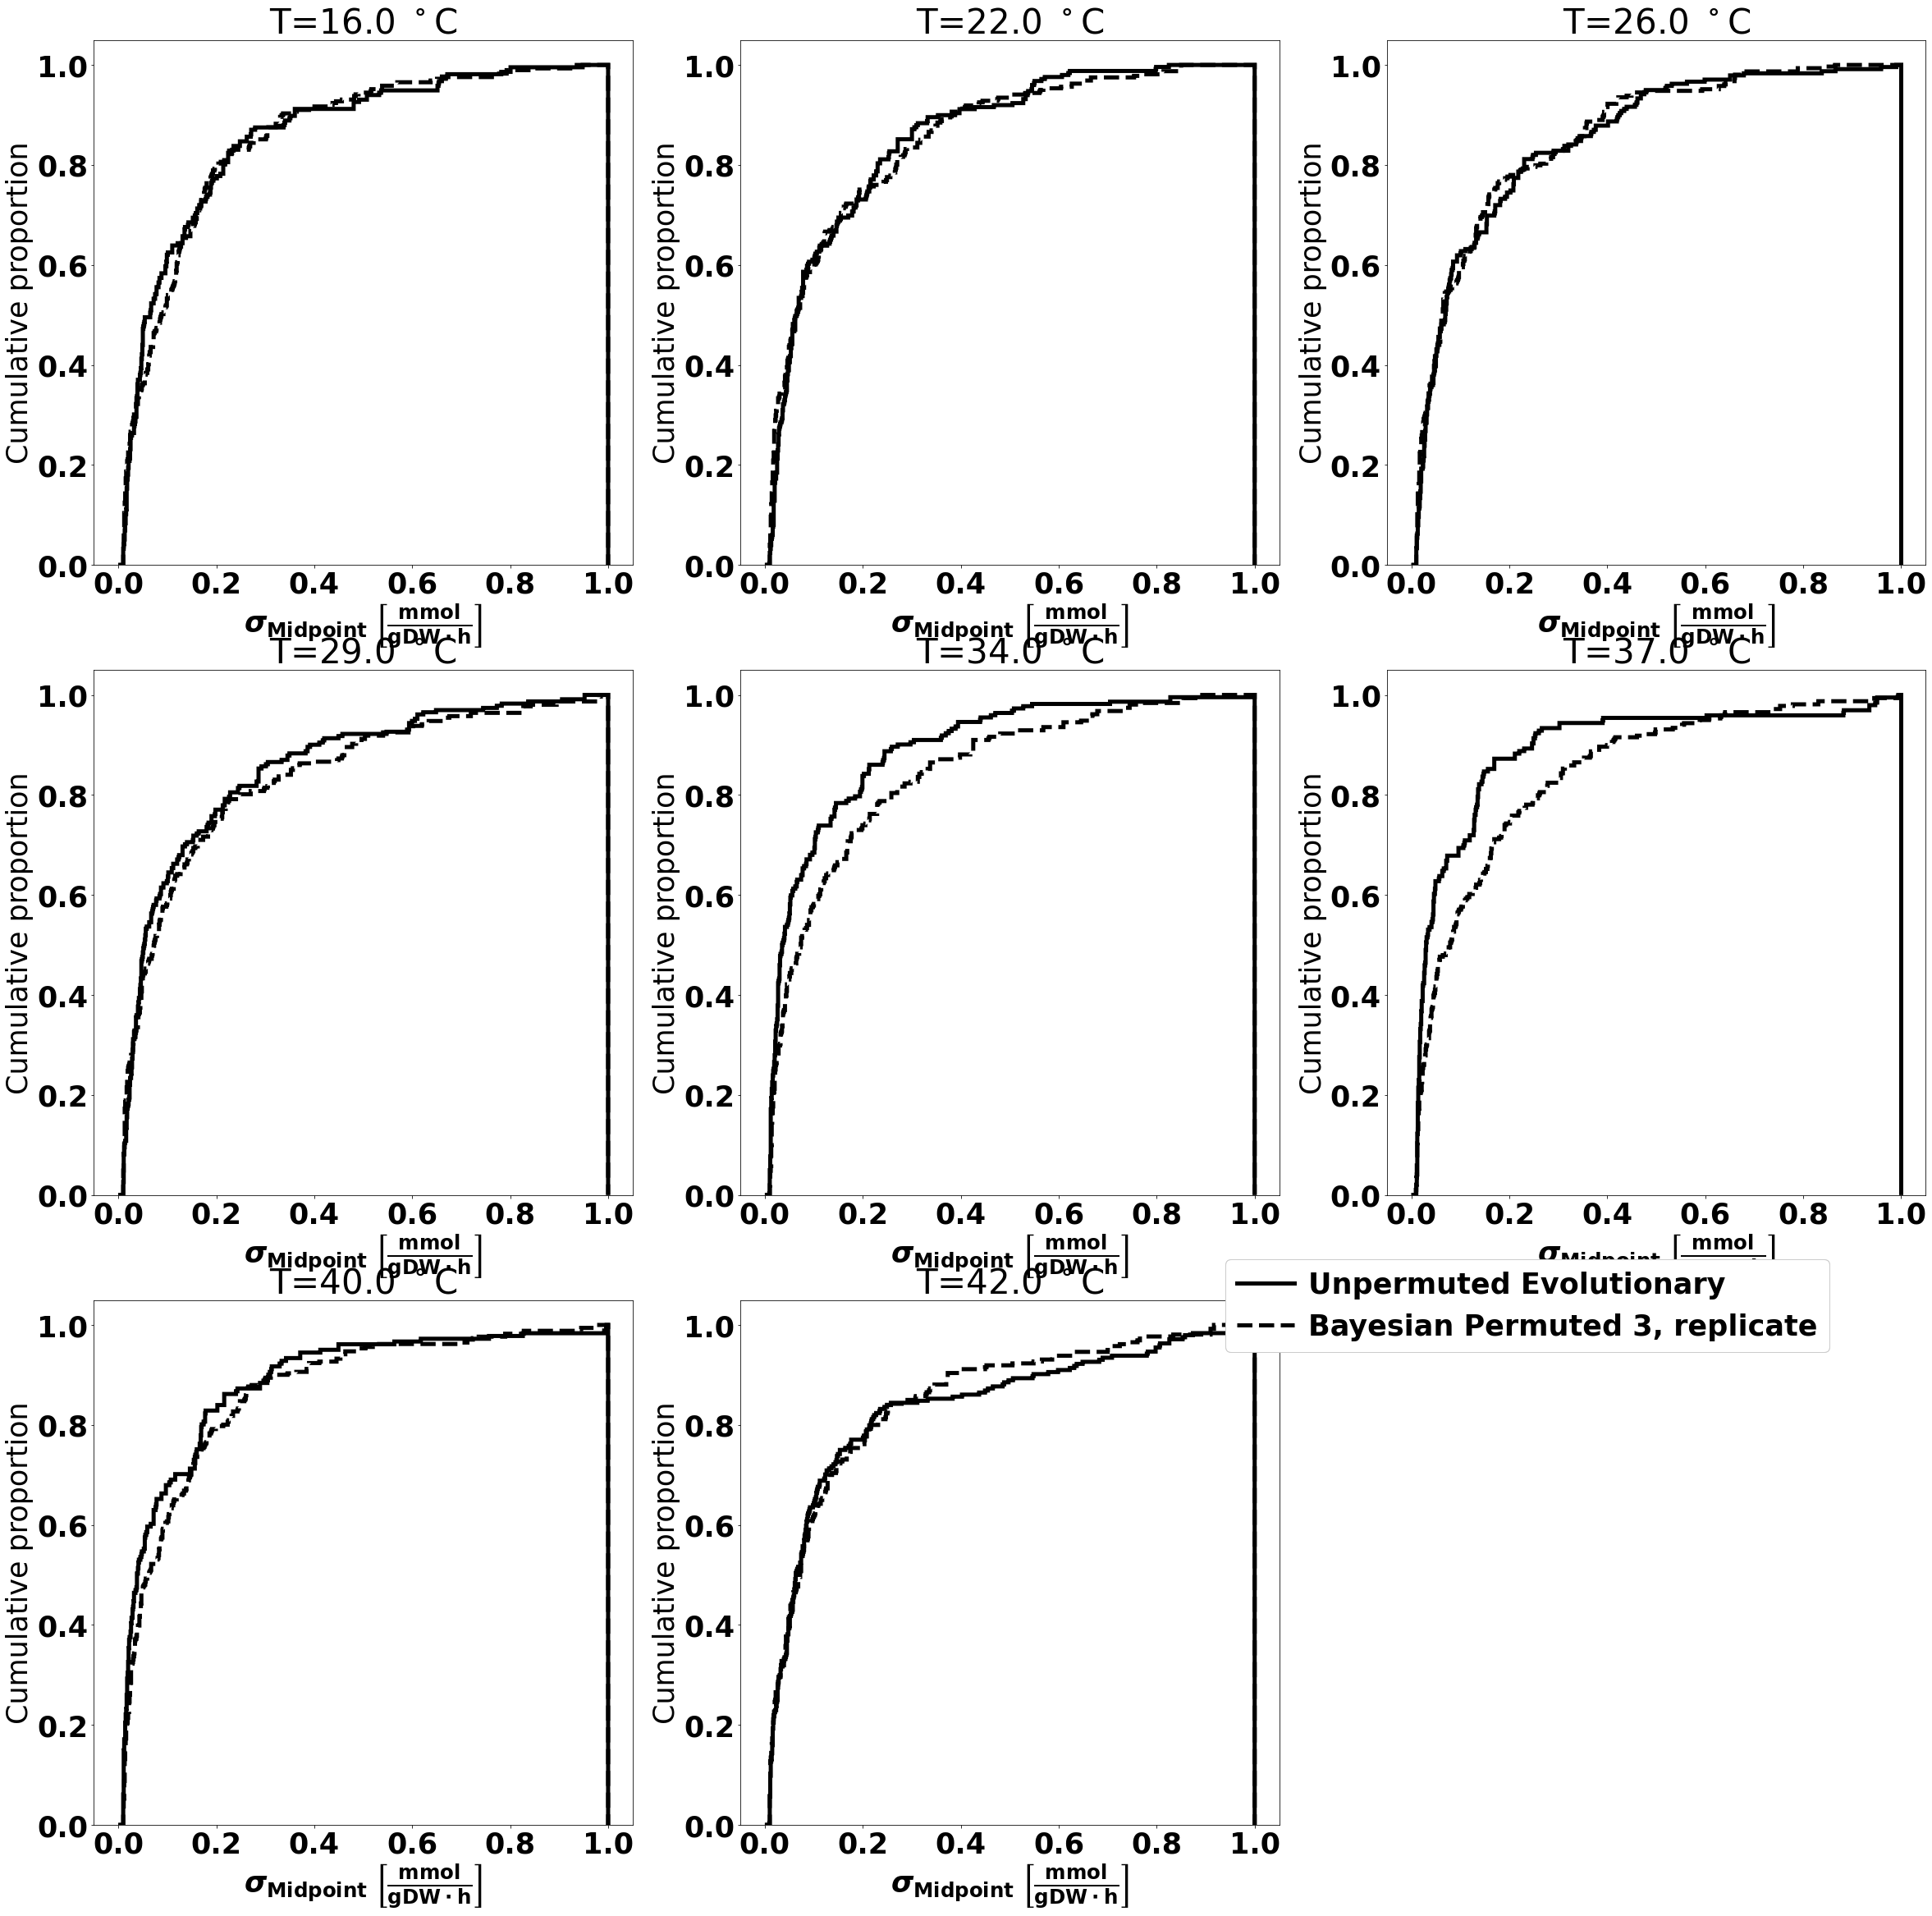

In [74]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","evolutionary","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("permuted_2","replicate","aerobic")].reset_index(),
                                   label_1="Unpermuted Evolutionary",label_2="Bayesian Permuted 3, replicate",what="midpoint")

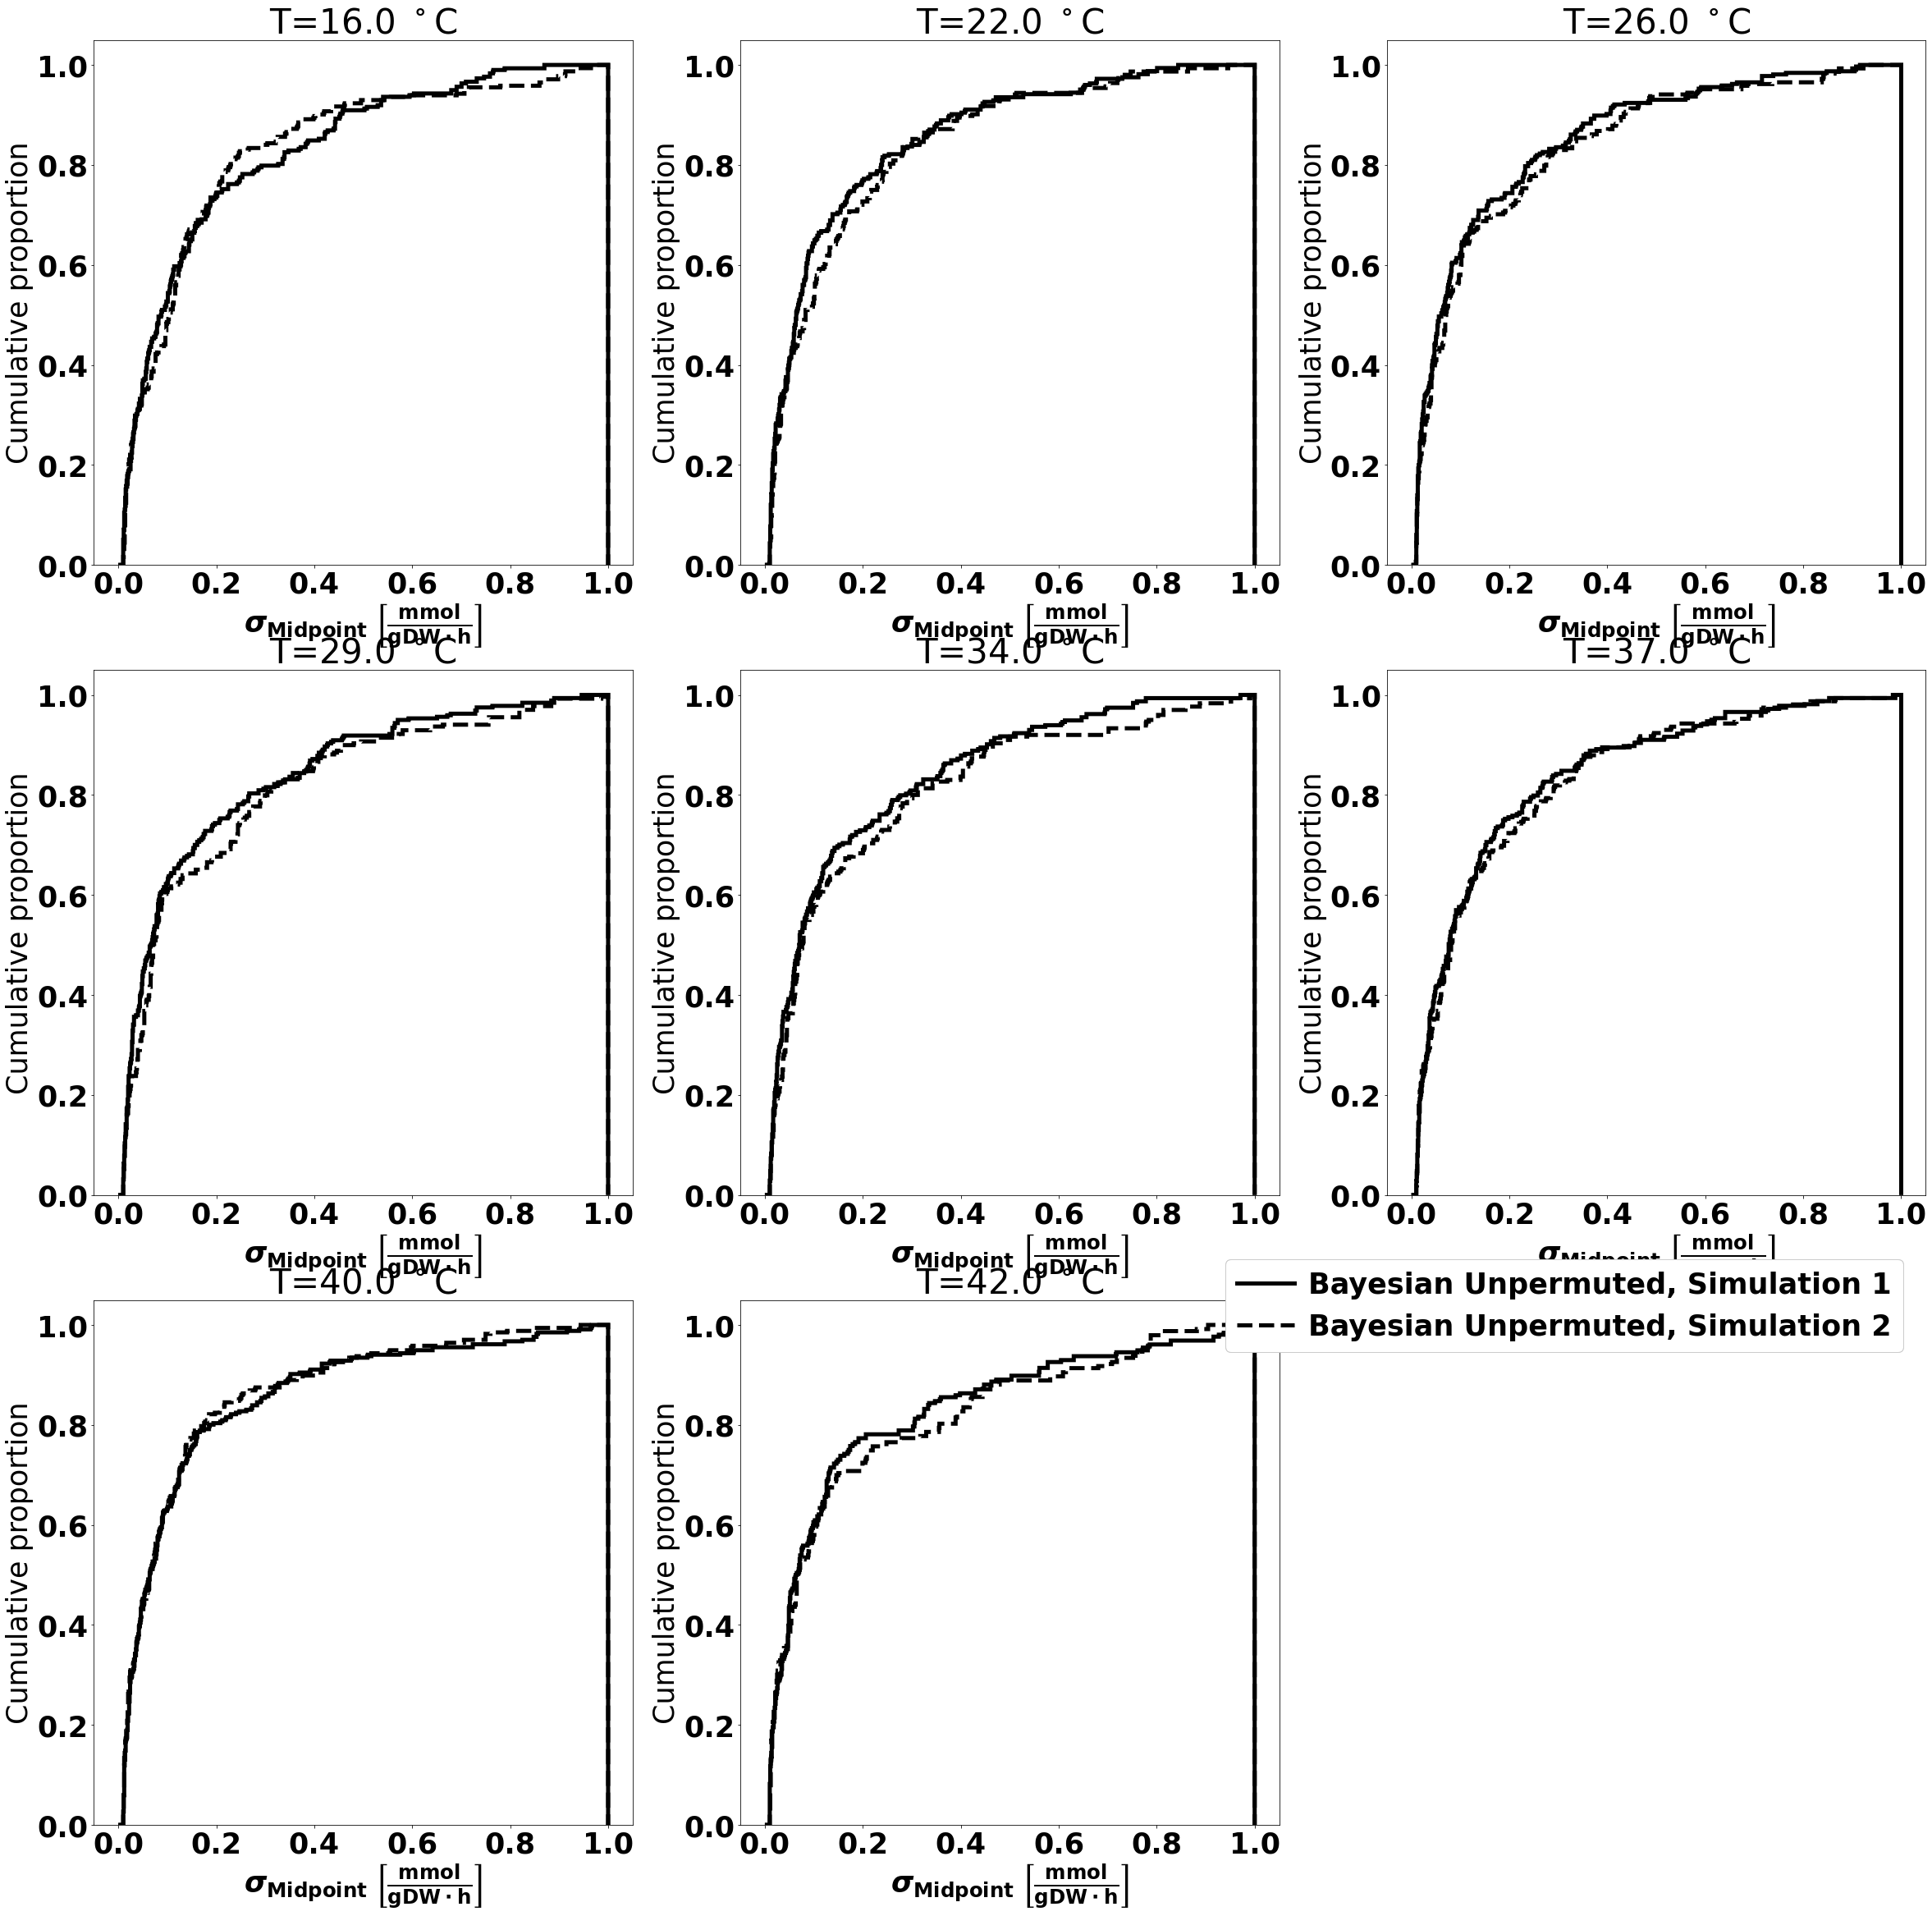

In [75]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("unpermuted","replicate","aerobic")].reset_index(),
                                   label_1="Bayesian Unpermuted, Simulation 1",label_2="Bayesian Unpermuted, Simulation 2",what="midpoint")

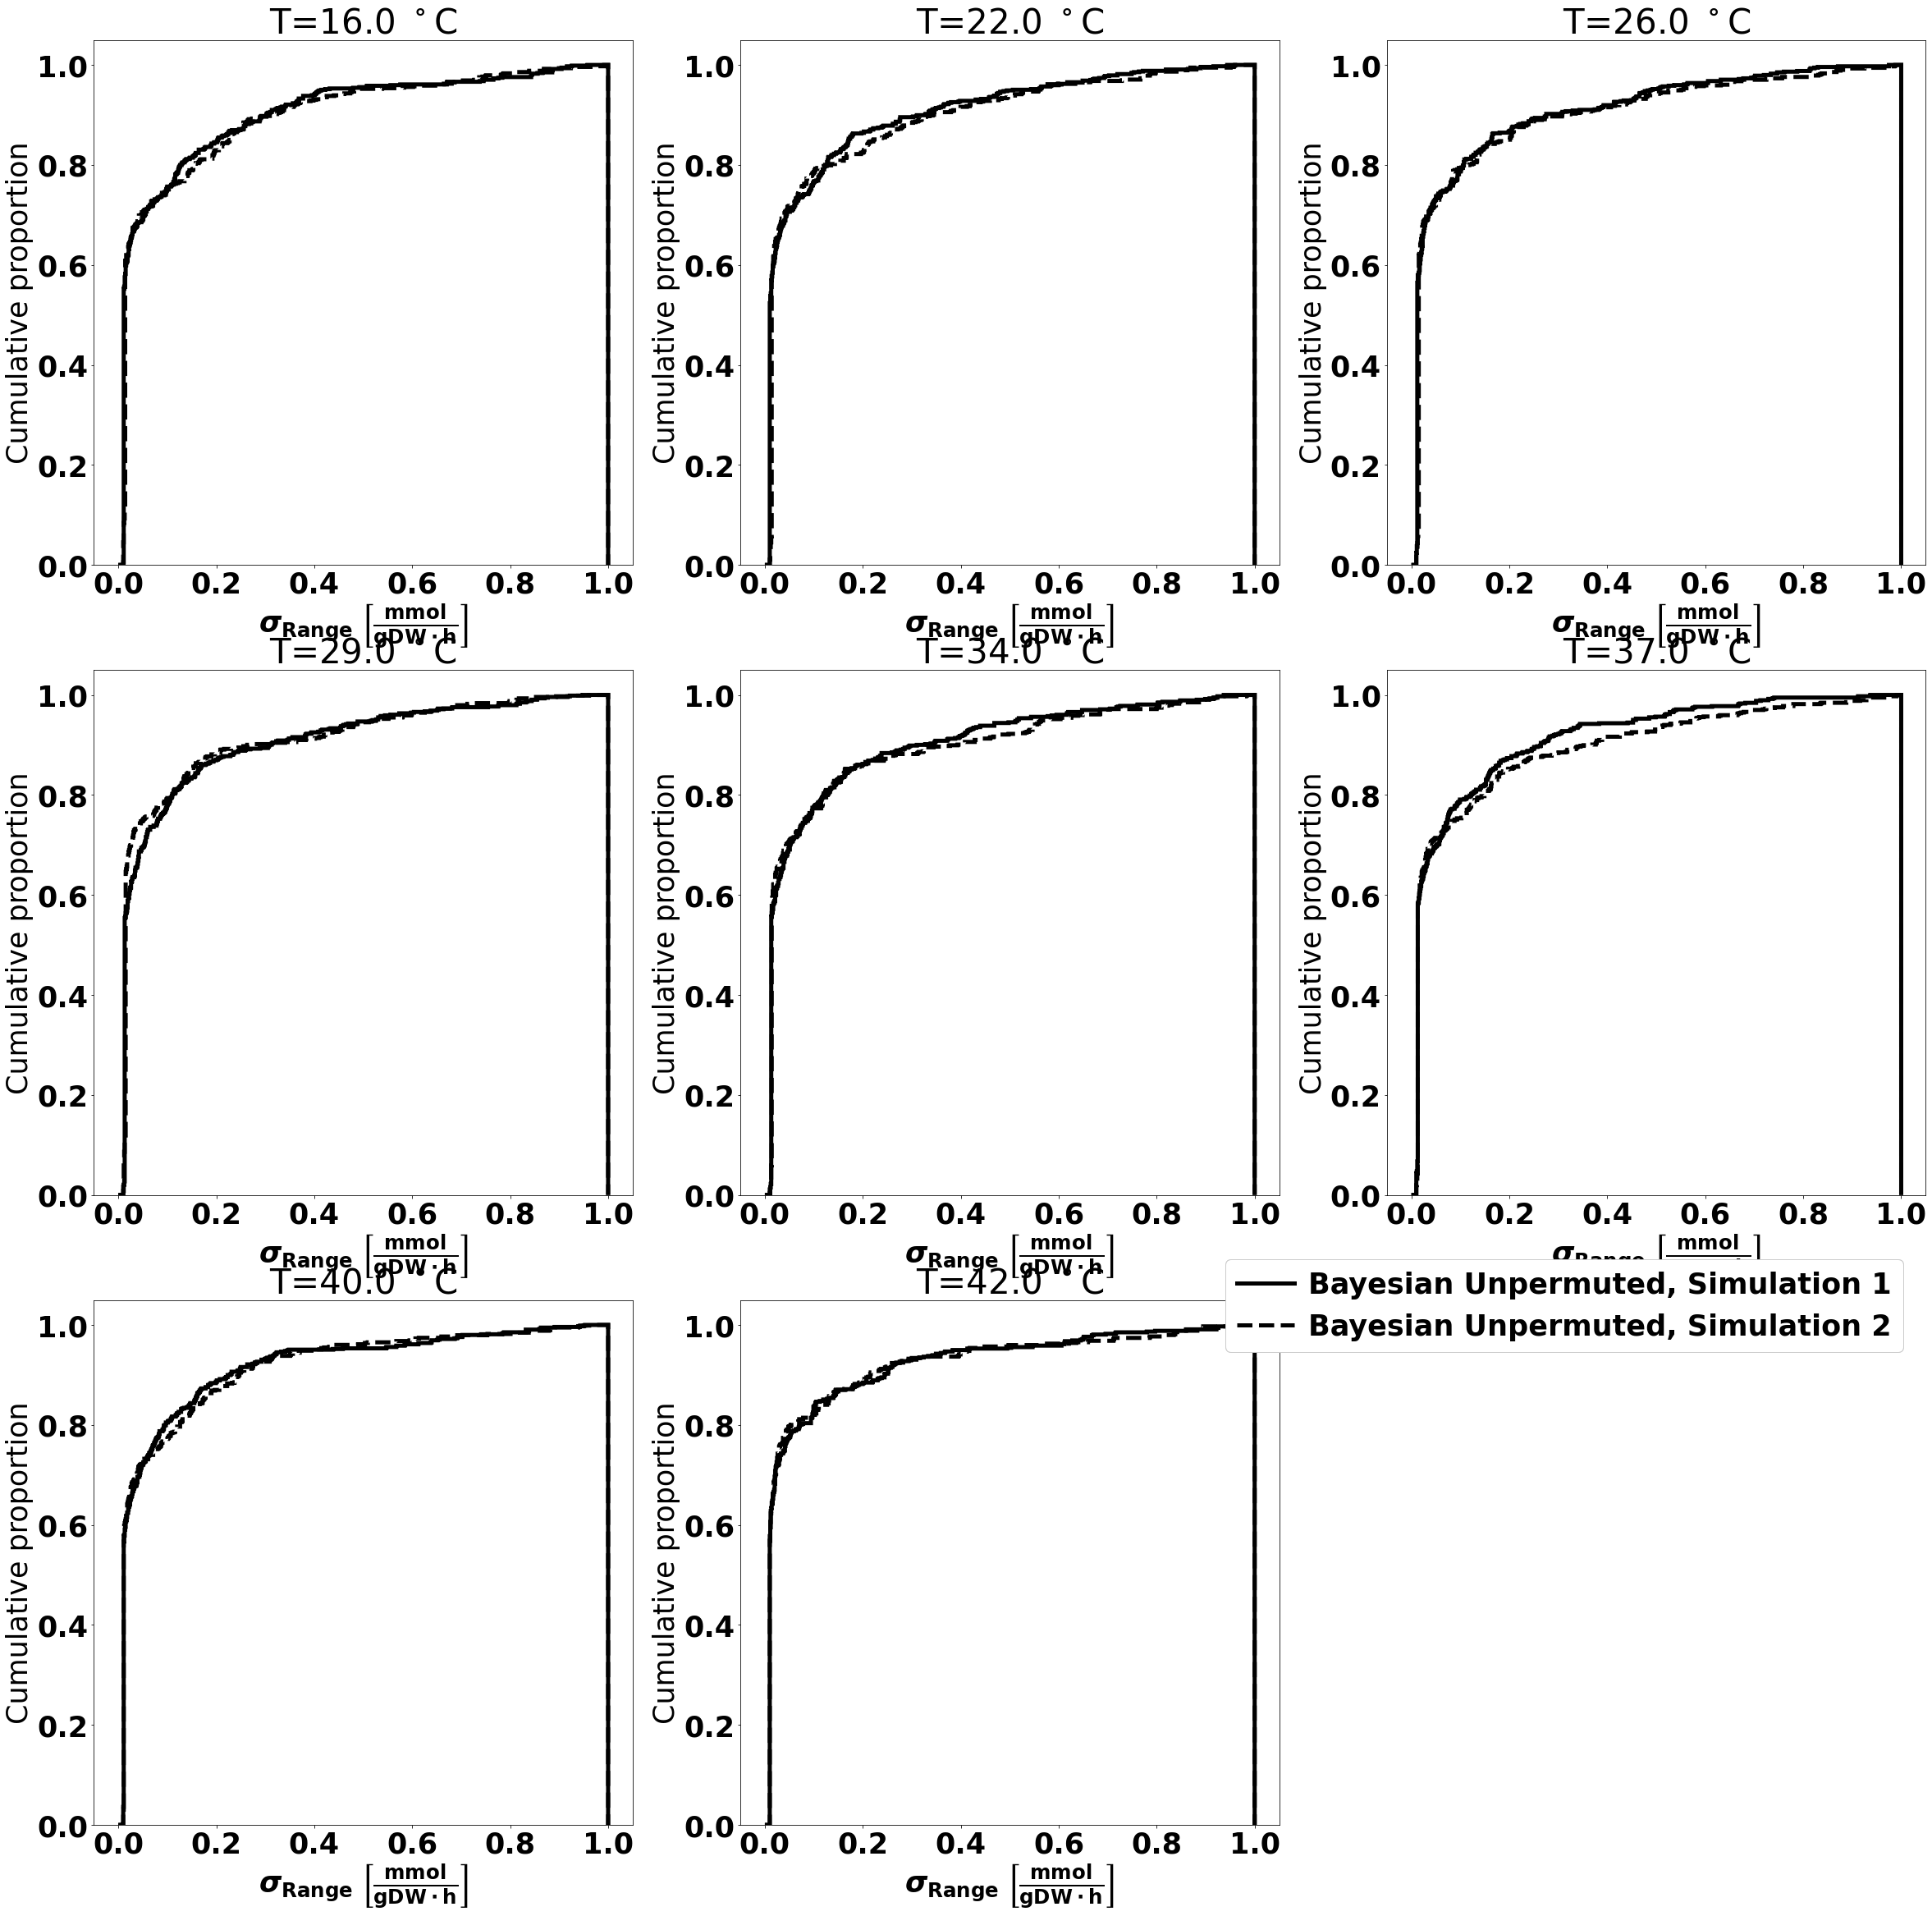

In [76]:
plt.figure(figsize=(40,40))
cumulative_range_std_compare_array(aggregated_fva_res.loc[("unpermuted","original","aerobic")].reset_index(),
                     aggregated_fva_res.loc[("unpermuted","replicate","aerobic")].reset_index(),
                                   label_1="Bayesian Unpermuted, Simulation 1",label_2="Bayesian Unpermuted, Simulation 2",what="range")